Replicate [Dynamic Return Dependencies Across Industries: A Machine Learning Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3120110&download=yes) by David Rapach, Jack Strauss, Jun Tu and Guofu Zhou.

1) Use Keras NNs instead of linear regression

2) Add additional variables, 3 and 12-month MA, interest rate change, yield curve, Mkt-RF, seasonal dummy variables. With cross-validation and regularization we hope to do that without overfitting and possibly produce a better result.


 

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd

import time 
import datetime
import copy
import random
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import chisquare

import tensorflow as tf
tf.set_random_seed(1764)
print(tf.__version__)
# confirm GPU is in use
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

import keras
from keras.layers.core import Dense, Activation
from keras.layers import Input
from keras.models import Model

from keras.layers.recurrent import LSTM, GRU
from keras.regularizers import l1
from keras.models import Sequential
from keras.models import load_model
    
import ffn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly as py
# print (py.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

random.seed(1764)
np.random.seed(1764)


1.8.0
[[22. 28.]
 [49. 64.]]


Using TensorFlow backend.


In [2]:
print("Loading data...")
data = pd.read_csv("30_Industry_Portfolios.csv")
data = data.set_index('yyyymm')
industries = list(data.columns)
# map industry names to col nums
ind_reverse_dict = dict([(industries[i], i) for i in range(len(industries))])

rfdata = pd.read_csv("F-F_Research_Data_Factors.csv")
rfdata = rfdata.set_index('yyyymm')
data['rf'] = rfdata['RF']

# subtract risk-free rate
# create a response variable led by 1 period to predict
for ind in industries:
    data[ind] = data[ind] - data['rf']

#for ind in industries:
#    data[ind+".3m"] = pd.rolling_mean(data[ind],3)
    
#for ind in industries:
#    data[ind+".6m"] = pd.rolling_mean(data[ind],6)

#for ind in industries:
#    data[ind+".12m"] = pd.rolling_mean(data[ind],12)
    
for ind in industries:
    data[ind+".lead"] = data[ind].shift(-1)

data = data.loc[data.index[data.index > 195911]]
data = data.drop(columns=['rf'])    
data = data.dropna(axis=0, how='any')

nresponses = len(industries)
npredictors = data.shape[1]-nresponses

predictors = list(data.columns[:npredictors])
predictor_reverse_dict = dict([(predictors[i], i) for i in range(len(predictors))])

responses = list(data.columns[-nresponses:])
response_reverse_dict = dict([(responses[i], i) for i in range(len(responses))])

print(data.shape)

data[['Food', 'Food.lead']]


Loading data...
(697, 60)


,Food,Food.lead
yyyymm,,
195912,2.01,-4.49
196001,-4.49,3.35
196002,3.35,-1.67
196003,-1.67,1.17
196004,1.17,8.20
196005,8.20,5.39
196006,5.39,-2.11
196007,-2.11,4.57
196008,4.57,-3.88


In [3]:
# exclude 2017 and later to tie to paper
data = data.loc[data.index[data.index < 201701]]
data = data.loc[data.index[data.index > 195911]]
data


,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
yyyymm,,,,,,,,,,,,,,,,,,,,,
195912,2.01,0.35,-3.02,1.64,7.29,0.67,1.87,-1.97,3.08,0.74,...,0.62,-6.18,-7.93,-9.41,-4.31,-5.33,-6.09,-10.08,-4.68,-3.98
196001,-4.49,-5.71,-2.05,1.21,-5.47,-7.84,-8.53,-6.68,-10.03,-4.77,...,8.07,9.13,5.09,3.00,-0.94,1.42,4.00,1.81,-0.98,6.32
196002,3.35,-2.14,2.27,4.23,2.39,9.31,1.44,-0.02,-0.74,0.32,...,-0.21,-0.31,3.34,-2.43,-4.99,-1.37,-0.13,-3.88,0.05,-2.43
196003,-1.67,-2.94,-0.18,-0.65,2.18,-0.56,-2.59,1.26,-2.75,-6.79,...,-1.24,7.14,1.77,0.41,-2.13,0.45,-0.53,8.86,-0.64,0.55
196004,1.17,-2.16,1.35,6.46,-1.17,-1.27,0.21,1.49,-5.53,-1.10,...,3.05,-1.75,11.90,2.85,0.90,1.65,3.11,0.80,-0.45,1.02
196005,8.20,-0.52,2.44,7.28,11.67,7.74,1.74,13.50,3.40,2.10,...,-0.58,-8.07,2.39,3.50,2.17,5.96,3.41,1.03,3.72,6.41
196006,5.39,0.47,4.73,2.24,0.02,6.38,-1.59,-0.40,0.45,4.04,...,-0.03,2.84,-2.02,-4.10,-3.11,-6.16,-2.99,-1.25,0.09,-5.95
196007,-2.11,-0.79,4.60,-4.72,0.23,-0.60,-1.10,-3.99,-6.80,-3.14,...,6.94,5.69,2.71,1.18,1.98,4.51,2.85,2.05,3.47,3.48
196008,4.57,3.24,5.20,7.16,3.63,5.09,3.34,2.29,1.17,-0.84,...,-6.07,-3.53,-7.61,-7.37,-7.07,-8.44,-8.57,-1.90,-5.78,-4.21


In [4]:
data.to_csv("data.csv")
desc = data.describe()
desc
# min, max line up with Table 1

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
count,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,...,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000
mean,0.690715,0.710613,0.982321,0.701708,0.528277,0.554190,0.669460,0.650905,0.519781,0.667416,...,0.520847,0.694234,0.584175,0.511241,0.582088,0.625562,0.662219,0.702730,0.609810,0.385620
std,4.339811,5.090215,6.061582,7.180918,5.809314,4.759874,6.386027,4.928072,5.518477,7.022552,...,4.628520,6.527984,6.738979,5.055314,5.739306,5.605317,5.349341,6.104515,5.411766,5.815446
min,-18.150000,-20.190000,-25.320000,-33.400000,-26.560000,-22.240000,-31.500000,-21.060000,-28.600000,-33.110000,...,-16.440000,-28.670000,-32.070000,-27.740000,-28.500000,-29.250000,-29.740000,-31.890000,-22.530000,-28.090000
25%,-1.640000,-2.100000,-2.780000,-3.490000,-2.690000,-2.110000,-2.810000,-2.240000,-2.800000,-3.200000,...,-2.110000,-3.090000,-3.290000,-2.430000,-2.780000,-2.570000,-2.430000,-2.940000,-2.420000,-2.990000
50%,0.740000,0.710000,1.280000,0.890000,0.510000,0.750000,0.690000,0.750000,0.670000,0.630000,...,0.610000,0.970000,0.560000,0.690000,0.860000,0.940000,0.470000,1.030000,0.820000,0.470000
75%,3.120000,3.660000,4.640000,5.310000,3.720000,3.550000,4.310000,3.560000,3.760000,4.490000,...,3.360000,4.290000,4.590000,3.460000,4.060000,3.880000,4.000000,4.330000,4.000000,4.200000
max,19.890000,25.510000,32.380000,34.520000,33.130000,18.220000,31.790000,29.010000,21.680000,59.030000,...,21.220000,23.380000,24.660000,21.000000,18.500000,17.530000,26.490000,27.380000,20.590000,19.960000


In [5]:
# annualized returns don't match Table 1, oddly
# geometric mean, annualized
pd.DataFrame((np.prod(data/100 + 1)**(12.0/len(data))-1)[:30], columns=['Mean Ann. Return'])

,Mean Ann. Return
Food,0.074020
Beer,0.072005
Smoke,0.100147
Games,0.054031
Books,0.043953
Hshld,0.054098
Clths,0.057170
Hlth,0.065463
Chems,0.044917
Txtls,0.051888


In [6]:
# try this way, arithmetic mean then annualize (not very correct)
#print(pd.DataFrame(((desc.loc['mean']/100+1)**12-1)[:30]))
#nope

# same
pd.DataFrame(((1 + np.mean(data, axis=0)/100)**12 -1)[:30], columns=['Mean Ann. Return'])

,Mean Ann. Return
Food,0.086108
Beer,0.088687
Smoke,0.124460
Games,0.087532
Books,0.065268
Hshld,0.068568
Clths,0.083360
Hlth,0.080966
Chems,0.064188
Txtls,0.083096


In [7]:
#annualized volatility 
pd.DataFrame((desc.loc['std']*np.sqrt(12))[:30].round(2))
# lines up with table 1

,std
Food,15.03
Beer,17.63
Smoke,21.00
Games,24.88
Books,20.12
Hshld,16.49
Clths,22.12
Hlth,17.07
Chems,19.12
Txtls,24.33


In [8]:
# skip last row to better match published r-squared
# looks like they forecast actuals 1960-2016 using 1959m12 to 2016m11
# not exact matches to Table 2 R-squared but almost within rounding error 
X = data.values[:-1,:npredictors]
Y = data.values[:-1,-nresponses:]
nrows = X.shape[0]
X.shape

(684, 30)

In [9]:
# use all predictors - higher in-sample R-squared
coef_dict_all = []
for _ in responses:
    coef_dict_all.append(range(len(predictors)))


In [10]:
# first iteration will train up to including 196911
# will use 196912 to predict 197001
# 1970101 will be first month of performance to use
# train on first 121 months up to 196912 (0:120), put first prediction in P[121] (122nd row)
# first month of performance will be 197002
FIRST_TRAIN_MONTHS = 121
FIRST_PREDICT_MONTH = FIRST_TRAIN_MONTHS # This is stupid but keeps my head straight

print(X[FIRST_TRAIN_MONTHS])
print(data.iloc[FIRST_TRAIN_MONTHS][:30])

[ -3.34  -1.95  -7.59  -7.76 -12.05  -7.5   -5.69  -7.71  -7.37  -5.26
  -9.84  -6.31  -7.15  -6.89  -9.35 -12.49  -2.34  -0.77 -12.16  -4.83
  -3.16 -11.17  -9.73  -8.89  -8.17  -8.28  -6.31 -13.12  -9.78  -6.2 ]
Food     -3.34
Beer     -1.95
Smoke    -7.59
Games    -7.76
Books   -12.05
Hshld    -7.50
Clths    -5.69
Hlth     -7.71
Chems    -7.37
Txtls    -5.26
Cnstr    -9.84
Steel    -6.31
FabPr    -7.15
ElcEq    -6.89
Autos    -9.35
Carry   -12.49
Mines    -2.34
Coal     -0.77
Oil     -12.16
Util     -4.83
Telcm    -3.16
Servs   -11.17
BusEq    -9.73
Paper    -8.89
Trans    -8.17
Whlsl    -8.28
Rtail    -6.31
Meals   -13.12
Fin      -9.78
Other    -6.20
Name: 197001, dtype: float64


In [1]:

class BacktestModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # transpose, scale, transpose back because scales by columns
            print("scaler: %s " %str(scaler))
            self.Xscale = scaler().fit_transform(Xscale.transpose()).transpose()
            self.Yscale = scaler().fit_transform(Yscale.transpose()).transpose()
        
        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):

        self.P = np.zeros_like(self.Y)

        progress_i = 0
        self.nrows, self.ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict(month_index, forecast_rows, verbose=False)
            
            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P[first_pred_row+row_index] = predictions[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        

    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        mse = np.mean(msetemp)
        print("MSE across all predictions: %.4f" % mse)
        
        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- mse/y_variance))
        
        return(mse)

    def evaluate_quantiles(self, chart=False, verbose=False):
    
        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(self.Y)
        
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=5
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(self.Y[row], N_QUANTILES, range(N_QUANTILES))

        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols) 
        
        nrows = nrows * ncols
        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()
            
        if verbose:
            print(chisquare(conf_mat))

        conf_mat_expected = np.array([[0.64, 0.16],[0.16, 0.04]])

        myscores = []
        for q in range(5):
            temp_pred = pred_quantiles == q
            temp_actual = true_quantiles == q
            conf_mat = confusion_matrix(temp_pred, temp_actual) / float(nrows)
            diff_mat = conf_mat - conf_mat_expected
            if verbose:
                print(conf_mat)
                print(diff_mat)
                print(chisquare(conf_mat.reshape(4)*nrows, conf_mat_expected.reshape(4)*nrows))
            # probably no valid statistical interpretation but 
            # average of improvement in true positive % and true negative %
            myscore = (diff_mat[0][0] + diff_mat[1][1])/2
            myscores.append(myscore)

        # average of my score for top and bottom quintiles
        finalscore = (myscores[0] + myscores[4])/2
        if verbose:
            print("Score: %f" % (finalscore))
            
        return finalscore

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-folds
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        return self.gen_predictions(splits=last_indexes, verbose=verbose)
    
    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.ycols
        longcount = [0] * self.ycols
        shortcount = [0] * self.ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
                
        for i in range(len(responses)):
            print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                         longcount[i], 
                                                                         shortcount[i], 
                                                                         indcount[i]))
        return self.R

    def report_returns(self, start_date='01/01/1970', freq='M'):

        first_pred_month=self.startindex        
        results = self.R[first_pred_month:]
        index = pd.date_range(start_date,periods=results.shape[0], freq=freq)
        perfdata = pd.DataFrame(results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + results / 100)
        self.cumulative_return = perfdata['Equity']

        stats = perfdata['Equity'].calc_stats()
        
        retframe = pd.DataFrame([stats.stats.loc['start'],
                                 stats.stats.loc['end'],
                                 stats.stats.loc['cagr'],
                                 stats.stats.loc['yearly_vol'],
                                 stats.stats.loc['yearly_sharpe'],
                                 stats.stats.loc['max_drawdown'],
                                 ffn.core.calc_sortino_ratio(perfdata.Returns, rf=0, nperiods=564, annualize=False),
                                ],
                                index = ['start',
                                         'end',
                                         'cagr',
                                         'yearly_vol',
                                         'yearly_sharpe',
                                         'max_drawdown',
                                         'sortino',
                                        ],
                                columns=['Value'])   
        return retframe

NameError: name 'FIRST_TRAIN_MONTHS' is not defined

In [12]:
NUMSTOCKS = 6 # top quintile (and bottom)

def calc_returns(prediction_row, return_row, numstocks=NUMSTOCKS, verbose=False):

    # ensure nan sorts to top for shorts
    short_sort_array = [999999 if np.isnan(x) else x for x in prediction_row]
    # pick bottom numstocks
    select_array = np.argsort(short_sort_array)
    short_indexes = select_array[:numstocks]

    # ensure nan sorts to bottom for longs
    long_sort_array = [-999999 if np.isnan(x) else x for x in prediction_row]
    # pick top numstocks
    select_array = np.argsort(long_sort_array)
    long_indexes = select_array[-numstocks:]
    
    if verbose:
        print("Longs: %s" %(str([(i,prediction_row[i]) for i in long_indexes])))
        print("Shorts: %s" %(str([(i,prediction_row[i]) for i in short_indexes])))

    # compute equal weighted long/short return
    return np.mean(return_row[long_indexes])/2 - np.mean(return_row[short_indexes])/2, long_indexes, short_indexes


In [13]:
start_date_int = data.index[FIRST_TRAIN_MONTHS]
start_year, start_month = start_date_int // 100, start_date_int % 100
start_date_str = "%02d/%02d/%d" % (start_month, 1, start_year)
start_date_str

'01/01/1970'

In [14]:
# use keras instead of sklearn MLPRegressor
# wrap keras model in a class 
# multioutput 30 predictions simultaneously to speed up 
# fit takes a list of response ys, predict returns a list of y_predict arrays
# no coef_dict
INPUT_DIM = X.shape[1]
print(INPUT_DIM)
OUTPUT_DIM = len(responses) # 30
BATCH_SIZE = 32
EPOCHS=500
# 500 is arbitrary, which bugs me
# something one could do is backtest and walk-forward xval with an xval set
# leave 30 months out of training fold, train until error on those 30 months is minimized, eval on following fold
# the other thing that bugs me is higher epochs take longer and yield worse results, there's some 'regularization thruogh under-training' going on
# but stochastically will never train at same speed, so you can pick a model and it might need more or less training than 100 in production

class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 32,
                 reg_penalty = 0.0001,
                 epochs=EPOCHS,
                 verbose=True):
        
        self.epochs=epochs
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        outputs = []
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            outputs.append(Dense(1,
                                 activation='linear',
                                 name='output%02d' % i)(lastlayer)
                          )
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss="mse", optimizer="adam", loss_weights=[1.]*OUTPUT_DIM)
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        Y_list = [Y[:,i] for i in range(OUTPUT_DIM)]
        
        if epochs:
            self.epochs = epochs
            
        return self.model.fit(X,
                              Y_list,
                              batch_size=BATCH_SIZE,
                              epochs=self.epochs,
                              verbose=verbose)
    
    def predict(self, X, verbose=False):
        y_list = self.model.predict(X)
        # convert list of ys to Y array
        npreds=len(y_list[0])
        Y_pred = [y.reshape(npreds) for y in y_list]
        Y_pred = np.array(Y_pred).transpose()    
        return Y_pred
    
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)


30


In [15]:
# no hidden layer, linear activation = LinearRegression
keras_model = KerasBacktestModel(n_hidden_layers = 0,
                                 reg_penalty = 0.0,
                                 verbose=True,
                                 epochs=2000)

backtestmodel = BacktestModel(X, Y, 
                              model=keras_model, 
                              coef_dict_param=coef_dict_all, 
                              startindex=FIRST_TRAIN_MONTHS)
print(backtestmodel.fit_predict(121, npredict=3, verbose=True))



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
output00 (Dense)                (None, 1)            31          main_input[0][0]                 
__________________________________________________________________________________________________
output01 (Dense)                (None, 1)            31          main_input[0][0]                 
__________________________________________________________________________________________________
output02 (Dense)                (None, 1)            31          main_input[0][0]                 
__________________________________________________________________________________________________
output03 (

121/121 [==============================] - 0s 2ms/step - loss: 2163.3716 - output00_loss: 28.0465 - output01_loss: 70.3127 - output02_loss: 69.6622 - output03_loss: 62.5432 - output04_loss: 141.3738 - output05_loss: 47.7258 - output06_loss: 118.5962 - output07_loss: 102.8755 - output08_loss: 43.9957 - output09_loss: 50.4786 - output10_loss: 39.7464 - output11_loss: 41.1924 - output12_loss: 52.9794 - output13_loss: 101.4511 - output14_loss: 64.0113 - output15_loss: 76.8493 - output16_loss: 36.9859 - output17_loss: 95.9093 - output18_loss: 37.1180 - output19_loss: 158.4899 - output20_loss: 88.4939 - output21_loss: 80.9500 - output22_loss: 40.9126 - output23_loss: 30.8416 - output24_loss: 55.9506 - output25_loss: 54.2333 - output26_loss: 31.4160 - output27_loss: 56.5673 - output28_loss: 142.3739 - output29_loss: 141.2898
Epoch 3/2000
121/121 [==============================] - 0s 2ms/step - loss: 2053.0590 - output00_loss: 27.7439 - output01_loss: 64.6385 - output02_loss: 65.3287 - output0

121/121 [==============================] - 0s 2ms/step - loss: 1451.3359 - output00_loss: 25.6088 - output01_loss: 35.1281 - output02_loss: 44.5635 - output03_loss: 58.0637 - output04_loss: 77.0903 - output05_loss: 42.8863 - output06_loss: 63.6011 - output07_loss: 63.5578 - output08_loss: 34.8544 - output09_loss: 46.8610 - output10_loss: 36.9969 - output11_loss: 38.3217 - output12_loss: 38.4079 - output13_loss: 53.9084 - output14_loss: 38.3287 - output15_loss: 47.8452 - output16_loss: 35.0733 - output17_loss: 65.1735 - output18_loss: 31.8978 - output19_loss: 78.5905 - output20_loss: 44.7314 - output21_loss: 59.8480 - output22_loss: 37.3941 - output23_loss: 26.5075 - output24_loss: 43.5763 - output25_loss: 50.4193 - output26_loss: 28.7038 - output27_loss: 48.1891 - output28_loss: 75.1180 - output29_loss: 80.0890
Epoch 12/2000
121/121 [==============================] - 0s 2ms/step - loss: 1409.7911 - output00_loss: 25.4052 - output01_loss: 33.3963 - output02_loss: 43.5276 - output03_loss

121/121 [==============================] - 0s 2ms/step - loss: 1205.2441 - output00_loss: 23.6873 - output01_loss: 27.5416 - output02_loss: 40.6174 - output03_loss: 56.3370 - output04_loss: 49.7532 - output05_loss: 39.4775 - output06_loss: 43.2248 - output07_loss: 52.6674 - output08_loss: 32.4179 - output09_loss: 44.5605 - output10_loss: 34.6187 - output11_loss: 36.6644 - output12_loss: 36.1154 - output13_loss: 38.9396 - output14_loss: 34.3655 - output15_loss: 42.7990 - output16_loss: 33.4942 - output17_loss: 57.5653 - output18_loss: 29.8578 - output19_loss: 38.3152 - output20_loss: 31.6024 - output21_loss: 56.0354 - output22_loss: 36.3267 - output23_loss: 25.2713 - output24_loss: 41.2256 - output25_loss: 47.9385 - output26_loss: 27.0549 - output27_loss: 46.7468 - output28_loss: 45.4366 - output29_loss: 54.5864
Epoch 21/2000
121/121 [==============================] - 0s 2ms/step - loss: 1191.4402 - output00_loss: 23.4926 - output01_loss: 27.2183 - output02_loss: 40.4582 - output03_loss

121/121 [==============================] - 0s 2ms/step - loss: 1112.7630 - output00_loss: 22.0677 - output01_loss: 26.2309 - output02_loss: 39.3094 - output03_loss: 54.7774 - output04_loss: 41.7417 - output05_loss: 36.6406 - output06_loss: 38.3454 - output07_loss: 49.2900 - output08_loss: 30.2632 - output09_loss: 42.4639 - output10_loss: 32.6693 - output11_loss: 35.1691 - output12_loss: 34.1899 - output13_loss: 36.2150 - output14_loss: 33.0945 - output15_loss: 41.8661 - output16_loss: 32.1865 - output17_loss: 53.9585 - output18_loss: 28.0227 - output19_loss: 22.6218 - output20_loss: 29.1662 - output21_loss: 53.6389 - output22_loss: 35.3544 - output23_loss: 24.1885 - output24_loss: 39.2350 - output25_loss: 45.7929 - output26_loss: 25.7129 - output27_loss: 45.2277 - output28_loss: 36.2009 - output29_loss: 47.1217
Epoch 30/2000
121/121 [==============================] - 0s 2ms/step - loss: 1105.4756 - output00_loss: 21.8906 - output01_loss: 26.1328 - output02_loss: 39.1653 - output03_loss

121/121 [==============================] - 0s 2ms/step - loss: 1061.2425 - output00_loss: 20.7153 - output01_loss: 25.3509 - output02_loss: 37.9775 - output03_loss: 53.3515 - output04_loss: 39.7197 - output05_loss: 34.2473 - output06_loss: 37.0509 - output07_loss: 46.8029 - output08_loss: 28.4066 - output09_loss: 40.5072 - output10_loss: 31.0584 - output11_loss: 33.7960 - output12_loss: 32.4373 - output13_loss: 35.4676 - output14_loss: 31.8619 - output15_loss: 41.0202 - output16_loss: 31.0326 - output17_loss: 50.6766 - output18_loss: 26.3501 - output19_loss: 17.7534 - output20_loss: 28.1017 - output21_loss: 51.3652 - output22_loss: 34.4489 - output23_loss: 23.2192 - output24_loss: 37.3651 - output25_loss: 43.9084 - output26_loss: 24.5605 - output27_loss: 43.8538 - output28_loss: 33.7206 - output29_loss: 45.1154
Epoch 39/2000
121/121 [==============================] - 0s 1ms/step - loss: 1056.9091 - output00_loss: 20.6072 - output01_loss: 25.2504 - output02_loss: 37.8418 - output03_loss

121/121 [==============================] - 0s 2ms/step - loss: 1022.4291 - output00_loss: 19.6061 - output01_loss: 24.4722 - output02_loss: 36.6822 - output03_loss: 52.0757 - output04_loss: 39.0146 - output05_loss: 32.2389 - output06_loss: 36.2639 - output07_loss: 44.4583 - output08_loss: 26.8749 - output09_loss: 38.7272 - output10_loss: 29.7436 - output11_loss: 32.6062 - output12_loss: 30.8234 - output13_loss: 34.9439 - output14_loss: 30.7357 - output15_loss: 40.2142 - output16_loss: 30.0299 - output17_loss: 47.7204 - output18_loss: 24.9007 - output19_loss: 16.4495 - output20_loss: 27.1137 - output21_loss: 49.3061 - output22_loss: 33.6422 - output23_loss: 22.3767 - output24_loss: 35.7291 - output25_loss: 42.2659 - output26_loss: 23.6108 - output27_loss: 42.5813 - output28_loss: 32.9184 - output29_loss: 44.3033
Epoch 48/2000
121/121 [==============================] - 0s 2ms/step - loss: 1018.4594 - output00_loss: 19.5079 - output01_loss: 24.3797 - output02_loss: 36.5571 - output03_loss

121/121 [==============================] - 0s 2ms/step - loss: 988.2654 - output00_loss: 18.6760 - output01_loss: 23.6418 - output02_loss: 35.4678 - output03_loss: 50.9161 - output04_loss: 38.4256 - output05_loss: 30.5490 - output06_loss: 35.4657 - output07_loss: 42.2783 - output08_loss: 25.5458 - output09_loss: 37.1170 - output10_loss: 28.6060 - output11_loss: 31.5024 - output12_loss: 29.3925 - output13_loss: 34.4171 - output14_loss: 29.7039 - output15_loss: 39.4249 - output16_loss: 29.1546 - output17_loss: 44.9690 - output18_loss: 23.6640 - output19_loss: 16.0077 - output20_loss: 26.1228 - output21_loss: 47.4118 - output22_loss: 32.8644 - output23_loss: 21.6308 - output24_loss: 34.2820 - output25_loss: 40.8474 - output26_loss: 22.7867 - output27_loss: 41.4385 - output28_loss: 32.3561 - output29_loss: 43.5999
Epoch 57/2000
121/121 [==============================] - 0s 2ms/step - loss: 984.7449 - output00_loss: 18.5984 - output01_loss: 23.5539 - output02_loss: 35.3343 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 957.5158 - output00_loss: 17.8980 - output01_loss: 22.8504 - output02_loss: 34.3399 - output03_loss: 49.8529 - output04_loss: 37.8554 - output05_loss: 29.1174 - output06_loss: 34.6594 - output07_loss: 40.3127 - output08_loss: 24.4402 - output09_loss: 35.6165 - output10_loss: 27.6353 - output11_loss: 30.5298 - output12_loss: 28.1390 - output13_loss: 33.8900 - output14_loss: 28.7736 - output15_loss: 38.6703 - output16_loss: 28.3977 - output17_loss: 42.4671 - output18_loss: 22.5705 - output19_loss: 15.7073 - output20_loss: 25.1714 - output21_loss: 45.7017 - output22_loss: 32.1631 - output23_loss: 20.9720 - output24_loss: 33.0061 - output25_loss: 39.5927 - output26_loss: 22.0868 - output27_loss: 40.4020 - output28_loss: 31.8093 - output29_loss: 42.8870
Epoch 66/2000
121/121 [==============================] - 0s 2ms/step - loss: 954.1846 - output00_loss: 17.8191 - output01_loss: 22.7496 - output02_loss: 34.2169 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 932.7539 - output00_loss: 17.3123 - output01_loss: 22.1811 - output02_loss: 33.3790 - output03_loss: 49.0032 - output04_loss: 37.3667 - output05_loss: 28.0372 - output06_loss: 33.9466 - output07_loss: 38.7361 - output08_loss: 23.5842 - output09_loss: 34.4007 - output10_loss: 26.9080 - output11_loss: 29.7396 - output12_loss: 27.1250 - output13_loss: 33.4446 - output14_loss: 28.0238 - output15_loss: 38.0355 - output16_loss: 27.7857 - output17_loss: 40.5199 - output18_loss: 21.7185 - output19_loss: 15.4699 - output20_loss: 24.3481 - output21_loss: 44.3228 - output22_loss: 31.6009 - output23_loss: 20.4782 - output24_loss: 31.9731 - output25_loss: 38.6376 - output26_loss: 21.5505 - output27_loss: 39.5647 - output28_loss: 31.3087 - output29_loss: 42.2518
Epoch 74/2000
121/121 [==============================] - 0s 2ms/step - loss: 929.5720 - output00_loss: 17.2230 - output01_loss: 22.0956 - output02_loss: 33.2690 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 907.2265 - output00_loss: 16.7259 - output01_loss: 21.4703 - output02_loss: 32.3949 - output03_loss: 48.0816 - output04_loss: 36.7866 - output05_loss: 26.9949 - output06_loss: 33.1519 - output07_loss: 37.1524 - output08_loss: 22.7770 - output09_loss: 33.1940 - output10_loss: 26.1956 - output11_loss: 28.9523 - output12_loss: 26.0929 - output13_loss: 32.9611 - output14_loss: 27.2824 - output15_loss: 37.3753 - output16_loss: 27.1816 - output17_loss: 38.4629 - output18_loss: 20.9274 - output19_loss: 15.2008 - output20_loss: 23.4583 - output21_loss: 42.8800 - output22_loss: 30.9984 - output23_loss: 19.9687 - output24_loss: 30.9460 - output25_loss: 37.6202 - output26_loss: 20.9995 - output27_loss: 38.7141 - output28_loss: 30.7500 - output29_loss: 41.5296
Epoch 83/2000
121/121 [==============================] - 0s 2ms/step - loss: 904.2952 - output00_loss: 16.6692 - output01_loss: 21.3899 - output02_loss: 32.2885 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 884.0505 - output00_loss: 16.2412 - output01_loss: 20.8225 - output02_loss: 31.5095 - output03_loss: 47.2589 - output04_loss: 36.2253 - output05_loss: 26.1031 - output06_loss: 32.3814 - output07_loss: 35.7381 - output08_loss: 22.0209 - output09_loss: 32.0411 - output10_loss: 25.5494 - output11_loss: 28.2305 - output12_loss: 25.1997 - output13_loss: 32.4825 - output14_loss: 26.5990 - output15_loss: 36.7475 - output16_loss: 26.6415 - output17_loss: 36.6824 - output18_loss: 20.1606 - output19_loss: 14.9450 - output20_loss: 22.6219 - output21_loss: 41.6089 - output22_loss: 30.4220 - output23_loss: 19.5159 - output24_loss: 30.0616 - output25_loss: 36.7600 - output26_loss: 20.5004 - output27_loss: 37.9543 - output28_loss: 30.2042 - output29_loss: 40.8216
Epoch 92/2000
121/121 [==============================] - 0s 2ms/step - loss: 881.6058 - output00_loss: 16.1833 - output01_loss: 20.7529 - output02_loss: 31.4091 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 863.0484 - output00_loss: 15.8187 - output01_loss: 20.2267 - output02_loss: 30.6955 - output03_loss: 46.4826 - output04_loss: 35.6813 - output05_loss: 25.3321 - output06_loss: 31.6310 - output07_loss: 34.4931 - output08_loss: 21.3781 - output09_loss: 31.0100 - output10_loss: 24.9985 - output11_loss: 27.5946 - output12_loss: 24.4065 - output13_loss: 32.0414 - output14_loss: 25.9829 - output15_loss: 36.1468 - output16_loss: 26.1370 - output17_loss: 35.0816 - output18_loss: 19.5335 - output19_loss: 14.6936 - output20_loss: 21.8524 - output21_loss: 40.4658 - output22_loss: 29.8969 - output23_loss: 19.1268 - output24_loss: 29.2265 - output25_loss: 35.9704 - output26_loss: 20.0669 - output27_loss: 37.2740 - output28_loss: 29.6673 - output29_loss: 40.1359
Epoch 101/2000
121/121 [==============================] - 0s 2ms/step - loss: 860.8695 - output00_loss: 15.7744 - output01_loss: 20.1645 - output02_loss: 30.6129 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 843.9083 - output00_loss: 15.4674 - output01_loss: 19.6702 - output02_loss: 29.9475 - output03_loss: 45.7560 - output04_loss: 35.1423 - output05_loss: 24.6582 - output06_loss: 30.8932 - output07_loss: 33.3660 - output08_loss: 20.8106 - output09_loss: 30.0609 - output10_loss: 24.4973 - output11_loss: 27.0155 - output12_loss: 23.6876 - output13_loss: 31.6143 - output14_loss: 25.4225 - output15_loss: 35.6130 - output16_loss: 25.7035 - output17_loss: 33.6721 - output18_loss: 18.9857 - output19_loss: 14.4580 - output20_loss: 21.1090 - output21_loss: 39.4285 - output22_loss: 29.4170 - output23_loss: 18.7712 - output24_loss: 28.5407 - output25_loss: 35.2791 - output26_loss: 19.6668 - output27_loss: 36.6623 - output28_loss: 29.1425 - output29_loss: 39.4494
Epoch 110/2000
121/121 [==============================] - 0s 2ms/step - loss: 841.9684 - output00_loss: 15.4438 - output01_loss: 19.6101 - output02_loss: 29.8716 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 826.6676 - output00_loss: 15.1706 - output01_loss: 19.1976 - output02_loss: 29.2804 - output03_loss: 45.0782 - output04_loss: 34.6321 - output05_loss: 24.0770 - output06_loss: 30.1888 - output07_loss: 32.3939 - output08_loss: 20.3065 - output09_loss: 29.2236 - output10_loss: 24.0532 - output11_loss: 26.5035 - output12_loss: 23.0468 - output13_loss: 31.2248 - output14_loss: 24.9147 - output15_loss: 35.1078 - output16_loss: 25.3148 - output17_loss: 32.4144 - output18_loss: 18.5176 - output19_loss: 14.2310 - output20_loss: 20.4409 - output21_loss: 38.5069 - output22_loss: 28.9723 - output23_loss: 18.4617 - output24_loss: 27.9115 - output25_loss: 34.6495 - output26_loss: 19.3186 - output27_loss: 36.0905 - output28_loss: 28.6481 - output29_loss: 38.7903
Epoch 119/2000
121/121 [==============================] - 0s 2ms/step - loss: 825.0271 - output00_loss: 15.1598 - output01_loss: 19.1126 - output02_loss: 29.2085 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 810.9085 - output00_loss: 14.9157 - output01_loss: 18.7080 - output02_loss: 28.6579 - output03_loss: 44.4536 - output04_loss: 34.1408 - output05_loss: 23.5648 - output06_loss: 29.5167 - output07_loss: 31.5193 - output08_loss: 19.8578 - output09_loss: 28.4419 - output10_loss: 23.6606 - output11_loss: 26.0380 - output12_loss: 22.4735 - output13_loss: 30.8485 - output14_loss: 24.4532 - output15_loss: 34.6482 - output16_loss: 24.9602 - output17_loss: 31.3206 - output18_loss: 18.1017 - output19_loss: 14.0165 - output20_loss: 19.8026 - output21_loss: 37.6989 - output22_loss: 28.5707 - output23_loss: 18.1903 - output24_loss: 27.3647 - output25_loss: 34.0900 - output26_loss: 18.9964 - output27_loss: 35.5874 - output28_loss: 28.1649 - output29_loss: 38.1451
Epoch 128/2000
121/121 [==============================] - 0s 2ms/step - loss: 809.2539 - output00_loss: 14.8845 - output01_loss: 18.6626 - output02_loss: 28.6196 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 796.5357 - output00_loss: 14.7013 - output01_loss: 18.2867 - output02_loss: 28.0930 - output03_loss: 43.8594 - output04_loss: 33.6704 - output05_loss: 23.0980 - output06_loss: 28.8878 - output07_loss: 30.7505 - output08_loss: 19.4466 - output09_loss: 27.7264 - output10_loss: 23.3105 - output11_loss: 25.6174 - output12_loss: 21.9635 - output13_loss: 30.5117 - output14_loss: 24.0161 - output15_loss: 34.2046 - output16_loss: 24.6481 - output17_loss: 30.3216 - output18_loss: 17.7256 - output19_loss: 13.8072 - output20_loss: 19.2138 - output21_loss: 36.9575 - output22_loss: 28.1915 - output23_loss: 17.9601 - output24_loss: 26.8718 - output25_loss: 33.6046 - output26_loss: 18.7152 - output27_loss: 35.1470 - output28_loss: 27.7093 - output29_loss: 37.5184
Epoch 137/2000
121/121 [==============================] - 0s 2ms/step - loss: 794.7611 - output00_loss: 14.6592 - output01_loss: 18.2400 - output02_loss: 28.0425 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 783.1473 - output00_loss: 14.4897 - output01_loss: 17.9085 - output02_loss: 27.5920 - output03_loss: 43.3082 - output04_loss: 33.2128 - output05_loss: 22.6888 - output06_loss: 28.2752 - output07_loss: 30.0455 - output08_loss: 19.0654 - output09_loss: 27.0877 - output10_loss: 22.9765 - output11_loss: 25.2375 - output12_loss: 21.4915 - output13_loss: 30.1582 - output14_loss: 23.6056 - output15_loss: 33.7952 - output16_loss: 24.3581 - output17_loss: 29.4821 - output18_loss: 17.3656 - output19_loss: 13.6121 - output20_loss: 18.6607 - output21_loss: 36.2721 - output22_loss: 27.8365 - output23_loss: 17.7318 - output24_loss: 26.4190 - output25_loss: 33.1416 - output26_loss: 18.4332 - output27_loss: 34.7188 - output28_loss: 27.2589 - output29_loss: 36.9185
Epoch 146/2000
121/121 [==============================] - 0s 2ms/step - loss: 781.7996 - output00_loss: 14.4691 - output01_loss: 17.8619 - output02_loss: 27.5352 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 771.0333 - output00_loss: 14.3187 - output01_loss: 17.5598 - output02_loss: 27.1206 - output03_loss: 42.7546 - output04_loss: 32.7858 - output05_loss: 22.3370 - output06_loss: 27.6922 - output07_loss: 29.4282 - output08_loss: 18.7212 - output09_loss: 26.4920 - output10_loss: 22.6825 - output11_loss: 24.8843 - output12_loss: 21.0770 - output13_loss: 29.8458 - output14_loss: 23.2464 - output15_loss: 33.4160 - output16_loss: 24.0817 - output17_loss: 28.7185 - output18_loss: 17.0869 - output19_loss: 13.4264 - output20_loss: 18.1516 - output21_loss: 35.6641 - output22_loss: 27.5184 - output23_loss: 17.5447 - output24_loss: 26.0271 - output25_loss: 32.7494 - output26_loss: 18.1868 - output27_loss: 34.3381 - output28_loss: 26.8347 - output29_loss: 36.3429
Epoch 155/2000
121/121 [==============================] - 0s 2ms/step - loss: 769.9551 - output00_loss: 14.3192 - output01_loss: 17.5167 - output02_loss: 27.0758 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 759.7101 - output00_loss: 14.1659 - output01_loss: 17.2213 - output02_loss: 26.7012 - output03_loss: 42.2564 - output04_loss: 32.3565 - output05_loss: 21.9928 - output06_loss: 27.1455 - output07_loss: 28.8500 - output08_loss: 18.3964 - output09_loss: 25.9537 - output10_loss: 22.3991 - output11_loss: 24.5706 - output12_loss: 20.7052 - output13_loss: 29.5567 - output14_loss: 22.8828 - output15_loss: 33.0633 - output16_loss: 23.8459 - output17_loss: 28.0313 - output18_loss: 16.8298 - output19_loss: 13.2451 - output20_loss: 17.6764 - output21_loss: 35.1174 - output22_loss: 27.2070 - output23_loss: 17.3584 - output24_loss: 25.6748 - output25_loss: 32.3590 - output26_loss: 17.9526 - output27_loss: 33.9802 - output28_loss: 26.4288 - output29_loss: 35.7858
Epoch 164/2000
121/121 [==============================] - 0s 2ms/step - loss: 758.6558 - output00_loss: 14.1538 - output01_loss: 17.1891 - output02_loss: 26.6718 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 749.3207 - output00_loss: 14.0258 - output01_loss: 16.9173 - output02_loss: 26.3312 - output03_loss: 41.7602 - output04_loss: 31.9534 - output05_loss: 21.6924 - output06_loss: 26.6276 - output07_loss: 28.3273 - output08_loss: 18.1004 - output09_loss: 25.4659 - output10_loss: 22.1417 - output11_loss: 24.2885 - output12_loss: 20.3594 - output13_loss: 29.2715 - output14_loss: 22.5675 - output15_loss: 32.7361 - output16_loss: 23.6192 - output17_loss: 27.4279 - output18_loss: 16.5888 - output19_loss: 13.0733 - output20_loss: 17.2442 - output21_loss: 34.6344 - output22_loss: 26.9077 - output23_loss: 17.1980 - output24_loss: 25.3398 - output25_loss: 32.0259 - output26_loss: 17.7406 - output27_loss: 33.6596 - output28_loss: 26.0479 - output29_loss: 35.2472
Epoch 173/2000
121/121 [==============================] - 0s 2ms/step - loss: 748.5153 - output00_loss: 14.0218 - output01_loss: 16.9019 - output02_loss: 26.3126 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 740.1715 - output00_loss: 13.9162 - output01_loss: 16.6550 - output02_loss: 25.9852 - output03_loss: 41.3411 - output04_loss: 31.5799 - output05_loss: 21.4350 - output06_loss: 26.1622 - output07_loss: 27.8728 - output08_loss: 17.8374 - output09_loss: 25.0311 - output10_loss: 21.9338 - output11_loss: 24.0278 - output12_loss: 20.0664 - output13_loss: 29.0133 - output14_loss: 22.2604 - output15_loss: 32.4358 - output16_loss: 23.4176 - output17_loss: 26.9002 - output18_loss: 16.3975 - output19_loss: 12.9134 - output20_loss: 16.8392 - output21_loss: 34.2198 - output22_loss: 26.6633 - output23_loss: 17.0753 - output24_loss: 25.0611 - output25_loss: 31.7400 - output26_loss: 17.5470 - output27_loss: 33.3959 - output28_loss: 25.6867 - output29_loss: 34.7611
Epoch 182/2000
121/121 [==============================] - 0s 2ms/step - loss: 739.3076 - output00_loss: 13.9107 - output01_loss: 16.6287 - output02_loss: 25.9494 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 731.4218 - output00_loss: 13.8065 - output01_loss: 16.4095 - output02_loss: 25.6783 - output03_loss: 40.8691 - output04_loss: 31.2236 - output05_loss: 21.1955 - output06_loss: 25.7051 - output07_loss: 27.4494 - output08_loss: 17.5808 - output09_loss: 24.6158 - output10_loss: 21.7279 - output11_loss: 23.7969 - output12_loss: 19.7793 - output13_loss: 28.7734 - output14_loss: 21.9784 - output15_loss: 32.1515 - output16_loss: 23.2372 - output17_loss: 26.4348 - output18_loss: 16.2094 - output19_loss: 12.7677 - output20_loss: 16.4633 - output21_loss: 33.8248 - output22_loss: 26.4254 - output23_loss: 16.9477 - output24_loss: 24.7977 - output25_loss: 31.4631 - output26_loss: 17.3626 - output27_loss: 33.1358 - output28_loss: 25.3480 - output29_loss: 34.2632
Epoch 191/2000
121/121 [==============================] - 0s 2ms/step - loss: 730.4004 - output00_loss: 13.7961 - output01_loss: 16.3804 - output02_loss: 25.6388 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 723.2130 - output00_loss: 13.7060 - output01_loss: 16.1816 - output02_loss: 25.3735 - output03_loss: 40.4544 - output04_loss: 30.8668 - output05_loss: 20.9778 - output06_loss: 25.2715 - output07_loss: 27.0488 - output08_loss: 17.3511 - output09_loss: 24.2488 - output10_loss: 21.5396 - output11_loss: 23.5729 - output12_loss: 19.5236 - output13_loss: 28.5272 - output14_loss: 21.7154 - output15_loss: 31.8820 - output16_loss: 23.0608 - output17_loss: 26.0191 - output18_loss: 16.0364 - output19_loss: 12.6160 - output20_loss: 16.1112 - output21_loss: 33.4570 - output22_loss: 26.1859 - output23_loss: 16.8282 - output24_loss: 24.5545 - output25_loss: 31.2077 - output26_loss: 17.1922 - output27_loss: 32.8799 - output28_loss: 25.0207 - output29_loss: 33.8026
Epoch 200/2000
121/121 [==============================] - 0s 2ms/step - loss: 722.5153 - output00_loss: 13.6935 - output01_loss: 16.1539 - output02_loss: 25.3444 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 715.8833 - output00_loss: 13.6120 - output01_loss: 15.9667 - output02_loss: 25.1072 - output03_loss: 40.0806 - output04_loss: 30.5418 - output05_loss: 20.7827 - output06_loss: 24.8660 - output07_loss: 26.6964 - output08_loss: 17.1513 - output09_loss: 23.9021 - output10_loss: 21.3699 - output11_loss: 23.3902 - output12_loss: 19.2952 - output13_loss: 28.3146 - output14_loss: 21.4815 - output15_loss: 31.6395 - output16_loss: 22.9157 - output17_loss: 25.6467 - output18_loss: 15.8947 - output19_loss: 12.4798 - output20_loss: 15.8018 - output21_loss: 33.1398 - output22_loss: 25.9707 - output23_loss: 16.7255 - output24_loss: 24.3539 - output25_loss: 30.9858 - output26_loss: 17.0353 - output27_loss: 32.6637 - output28_loss: 24.7134 - output29_loss: 33.3587
Epoch 209/2000
121/121 [==============================] - 0s 2ms/step - loss: 715.0013 - output00_loss: 13.6128 - output01_loss: 15.9475 - output02_loss: 25.0837 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 708.9146 - output00_loss: 13.5383 - output01_loss: 15.7715 - output02_loss: 24.8700 - output03_loss: 39.7047 - output04_loss: 30.2339 - output05_loss: 20.5880 - output06_loss: 24.5042 - output07_loss: 26.3455 - output08_loss: 16.9547 - output09_loss: 23.5822 - output10_loss: 21.2130 - output11_loss: 23.2185 - output12_loss: 19.0793 - output13_loss: 28.1042 - output14_loss: 21.2352 - output15_loss: 31.4109 - output16_loss: 22.7797 - output17_loss: 25.3131 - output18_loss: 15.7486 - output19_loss: 12.3470 - output20_loss: 15.4924 - output21_loss: 32.8502 - output22_loss: 25.7662 - output23_loss: 16.6355 - output24_loss: 24.1457 - output25_loss: 30.7795 - output26_loss: 16.8895 - output27_loss: 32.4517 - output28_loss: 24.4221 - output29_loss: 32.9393
Epoch 218/2000
121/121 [==============================] - 0s 2ms/step - loss: 708.0148 - output00_loss: 13.5373 - output01_loss: 15.7525 - output02_loss: 24.8346 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 702.3649 - output00_loss: 13.4653 - output01_loss: 15.5966 - output02_loss: 24.6298 - output03_loss: 39.3604 - output04_loss: 29.9303 - output05_loss: 20.4257 - output06_loss: 24.1463 - output07_loss: 26.0281 - output08_loss: 16.7579 - output09_loss: 23.3134 - output10_loss: 21.0589 - output11_loss: 23.0260 - output12_loss: 18.8729 - output13_loss: 27.9100 - output14_loss: 21.0199 - output15_loss: 31.1969 - output16_loss: 22.6173 - output17_loss: 25.0129 - output18_loss: 15.6108 - output19_loss: 12.2263 - output20_loss: 15.2213 - output21_loss: 32.5875 - output22_loss: 25.5922 - output23_loss: 16.5418 - output24_loss: 23.9524 - output25_loss: 30.5741 - output26_loss: 16.7457 - output27_loss: 32.2531 - output28_loss: 24.1394 - output29_loss: 32.5517
Epoch 227/2000
121/121 [==============================] - 0s 2ms/step - loss: 702.1351 - output00_loss: 13.4867 - output01_loss: 15.5900 - output02_loss: 24.6164 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 696.3762 - output00_loss: 13.4030 - output01_loss: 15.4338 - output02_loss: 24.4289 - output03_loss: 39.0054 - output04_loss: 29.6424 - output05_loss: 20.2729 - output06_loss: 23.8086 - output07_loss: 25.7337 - output08_loss: 16.6039 - output09_loss: 23.0299 - output10_loss: 20.9345 - output11_loss: 22.8798 - output12_loss: 18.6962 - output13_loss: 27.7188 - output14_loss: 20.8183 - output15_loss: 30.9639 - output16_loss: 22.4906 - output17_loss: 24.7543 - output18_loss: 15.5087 - output19_loss: 12.1047 - output20_loss: 14.9625 - output21_loss: 32.3529 - output22_loss: 25.4117 - output23_loss: 16.4702 - output24_loss: 23.7920 - output25_loss: 30.4187 - output26_loss: 16.6303 - output27_loss: 32.0654 - output28_loss: 23.8800 - output29_loss: 32.1604
Epoch 236/2000
121/121 [==============================] - 0s 2ms/step - loss: 695.7694 - output00_loss: 13.3991 - output01_loss: 15.4173 - output02_loss: 24.3969 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 691.0335 - output00_loss: 13.3485 - output01_loss: 15.2802 - output02_loss: 24.2219 - output03_loss: 38.6994 - output04_loss: 29.3792 - output05_loss: 20.1577 - output06_loss: 23.5098 - output07_loss: 25.4731 - output08_loss: 16.4460 - output09_loss: 22.7937 - output10_loss: 20.8155 - output11_loss: 22.7544 - output12_loss: 18.5445 - output13_loss: 27.5497 - output14_loss: 20.6349 - output15_loss: 30.7689 - output16_loss: 22.3782 - output17_loss: 24.5085 - output18_loss: 15.4316 - output19_loss: 11.9916 - output20_loss: 14.7284 - output21_loss: 32.1367 - output22_loss: 25.2639 - output23_loss: 16.4203 - output24_loss: 23.6464 - output25_loss: 30.2610 - output26_loss: 16.5143 - output27_loss: 31.9276 - output28_loss: 23.6359 - output29_loss: 31.8115
Epoch 245/2000
121/121 [==============================] - 0s 2ms/step - loss: 690.2713 - output00_loss: 13.3363 - output01_loss: 15.2654 - output02_loss: 24.2044 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 685.6812 - output00_loss: 13.2889 - output01_loss: 15.1388 - output02_loss: 24.0372 - output03_loss: 38.3938 - output04_loss: 29.1248 - output05_loss: 20.0063 - output06_loss: 23.2174 - output07_loss: 25.2155 - output08_loss: 16.2869 - output09_loss: 22.5701 - output10_loss: 20.7031 - output11_loss: 22.6152 - output12_loss: 18.3980 - output13_loss: 27.3869 - output14_loss: 20.4470 - output15_loss: 30.5847 - output16_loss: 22.2742 - output17_loss: 24.2900 - output18_loss: 15.3137 - output19_loss: 11.8833 - output20_loss: 14.5136 - output21_loss: 31.9352 - output22_loss: 25.1000 - output23_loss: 16.3460 - output24_loss: 23.4982 - output25_loss: 30.1115 - output26_loss: 16.3870 - output27_loss: 31.7504 - output28_loss: 23.4047 - output29_loss: 31.4587
Epoch 254/2000
121/121 [==============================] - 0s 2ms/step - loss: 685.0454 - output00_loss: 13.2800 - output01_loss: 15.1204 - output02_loss: 24.0189 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 680.7340 - output00_loss: 13.2320 - output01_loss: 15.0013 - output02_loss: 23.8671 - output03_loss: 38.0989 - output04_loss: 28.8818 - output05_loss: 19.8900 - output06_loss: 22.9403 - output07_loss: 24.9581 - output08_loss: 16.1506 - output09_loss: 22.3582 - output10_loss: 20.5873 - output11_loss: 22.4926 - output12_loss: 18.2482 - output13_loss: 27.2231 - output14_loss: 20.2768 - output15_loss: 30.4124 - output16_loss: 22.1724 - output17_loss: 24.0973 - output18_loss: 15.2332 - output19_loss: 11.7767 - output20_loss: 14.3055 - output21_loss: 31.7620 - output22_loss: 24.9517 - output23_loss: 16.2786 - output24_loss: 23.3677 - output25_loss: 29.9675 - output26_loss: 16.2811 - output27_loss: 31.5970 - output28_loss: 23.1830 - output29_loss: 31.1418
Epoch 263/2000
121/121 [==============================] - 0s 2ms/step - loss: 680.2902 - output00_loss: 13.2304 - output01_loss: 14.9957 - output02_loss: 23.8481 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 676.3223 - output00_loss: 13.1910 - output01_loss: 14.8780 - output02_loss: 23.7067 - output03_loss: 37.8350 - output04_loss: 28.6639 - output05_loss: 19.7879 - output06_loss: 22.6944 - output07_loss: 24.7393 - output08_loss: 16.0243 - output09_loss: 22.1772 - output10_loss: 20.4997 - output11_loss: 22.3802 - output12_loss: 18.1248 - output13_loss: 27.0774 - output14_loss: 20.1240 - output15_loss: 30.2602 - output16_loss: 22.0840 - output17_loss: 23.9078 - output18_loss: 15.1499 - output19_loss: 11.6740 - output20_loss: 14.1160 - output21_loss: 31.6018 - output22_loss: 24.8258 - output23_loss: 16.2320 - output24_loss: 23.2545 - output25_loss: 29.8464 - output26_loss: 16.1885 - output27_loss: 31.4599 - output28_loss: 22.9868 - output29_loss: 30.8311
Epoch 272/2000
121/121 [==============================] - 0s 2ms/step - loss: 675.7549 - output00_loss: 13.1789 - output01_loss: 14.8664 - output02_loss: 23.6904 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 672.1401 - output00_loss: 13.1450 - output01_loss: 14.7654 - output02_loss: 23.5665 - output03_loss: 37.5733 - output04_loss: 28.4436 - output05_loss: 19.6855 - output06_loss: 22.4531 - output07_loss: 24.5253 - output08_loss: 15.9062 - output09_loss: 21.9929 - output10_loss: 20.4169 - output11_loss: 22.2828 - output12_loss: 18.0154 - output13_loss: 26.9434 - output14_loss: 19.9697 - output15_loss: 30.0981 - output16_loss: 22.0004 - output17_loss: 23.7683 - output18_loss: 15.0844 - output19_loss: 11.5841 - output20_loss: 13.9493 - output21_loss: 31.4581 - output22_loss: 24.6985 - output23_loss: 16.1895 - output24_loss: 23.1371 - output25_loss: 29.7376 - output26_loss: 16.0958 - output27_loss: 31.3320 - output28_loss: 22.7853 - output29_loss: 30.5364
Epoch 281/2000
121/121 [==============================] - 0s 2ms/step - loss: 671.5383 - output00_loss: 13.1396 - output01_loss: 14.7498 - output02_loss: 23.5493 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 668.0758 - output00_loss: 13.1037 - output01_loss: 14.6545 - output02_loss: 23.4220 - output03_loss: 37.3444 - output04_loss: 28.2310 - output05_loss: 19.5957 - output06_loss: 22.2311 - output07_loss: 24.3164 - output08_loss: 15.7894 - output09_loss: 21.8180 - output10_loss: 20.3240 - output11_loss: 22.1787 - output12_loss: 17.9033 - output13_loss: 26.8063 - output14_loss: 19.8217 - output15_loss: 29.9525 - output16_loss: 21.9229 - output17_loss: 23.5996 - output18_loss: 15.0139 - output19_loss: 11.4919 - output20_loss: 13.7829 - output21_loss: 31.3265 - output22_loss: 24.5777 - output23_loss: 16.1283 - output24_loss: 23.0413 - output25_loss: 29.6182 - output26_loss: 15.9993 - output27_loss: 31.2258 - output28_loss: 22.5926 - output29_loss: 30.2624
Epoch 290/2000
121/121 [==============================] - 0s 2ms/step - loss: 667.7489 - output00_loss: 13.1037 - output01_loss: 14.6418 - output02_loss: 23.4162 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 664.2825 - output00_loss: 13.0654 - output01_loss: 14.5489 - output02_loss: 23.2881 - output03_loss: 37.0692 - output04_loss: 28.0416 - output05_loss: 19.5283 - output06_loss: 22.0088 - output07_loss: 24.1332 - output08_loss: 15.6890 - output09_loss: 21.6676 - output10_loss: 20.2439 - output11_loss: 22.0941 - output12_loss: 17.8061 - output13_loss: 26.6784 - output14_loss: 19.6898 - output15_loss: 29.8161 - output16_loss: 21.8572 - output17_loss: 23.4582 - output18_loss: 14.9462 - output19_loss: 11.3944 - output20_loss: 13.6252 - output21_loss: 31.1915 - output22_loss: 24.4598 - output23_loss: 16.0946 - output24_loss: 22.9353 - output25_loss: 29.5186 - output26_loss: 15.9185 - output27_loss: 31.1035 - output28_loss: 22.4161 - output29_loss: 29.9951
Epoch 299/2000
121/121 [==============================] - 0s 2ms/step - loss: 663.8237 - output00_loss: 13.0606 - output01_loss: 14.5345 - output02_loss: 23.2705 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 660.9398 - output00_loss: 13.0342 - output01_loss: 14.4582 - output02_loss: 23.1640 - output03_loss: 36.8626 - output04_loss: 27.8591 - output05_loss: 19.4527 - output06_loss: 21.8084 - output07_loss: 23.9627 - output08_loss: 15.6026 - output09_loss: 21.5492 - output10_loss: 20.1797 - output11_loss: 22.0224 - output12_loss: 17.7168 - output13_loss: 26.5618 - output14_loss: 19.5717 - output15_loss: 29.7028 - output16_loss: 21.7850 - output17_loss: 23.3357 - output18_loss: 14.8958 - output19_loss: 11.3063 - output20_loss: 13.4849 - output21_loss: 31.0816 - output22_loss: 24.3531 - output23_loss: 16.0465 - output24_loss: 22.8623 - output25_loss: 29.4388 - output26_loss: 15.8514 - output27_loss: 30.9859 - output28_loss: 22.2585 - output29_loss: 29.7449
Epoch 308/2000
121/121 [==============================] - 0s 2ms/step - loss: 660.3772 - output00_loss: 13.0293 - output01_loss: 14.4399 - output02_loss: 23.1518 - output03_loss:

121/121 [==============================] - 0s 1ms/step - loss: 657.4795 - output00_loss: 12.9990 - output01_loss: 14.3565 - output02_loss: 23.0687 - output03_loss: 36.6493 - output04_loss: 27.6849 - output05_loss: 19.3652 - output06_loss: 21.6203 - output07_loss: 23.7812 - output08_loss: 15.5010 - output09_loss: 21.3911 - output10_loss: 20.1051 - output11_loss: 21.9380 - output12_loss: 17.6322 - output13_loss: 26.4420 - output14_loss: 19.4532 - output15_loss: 29.5544 - output16_loss: 21.7238 - output17_loss: 23.2193 - output18_loss: 14.8506 - output19_loss: 11.2257 - output20_loss: 13.3523 - output21_loss: 30.9790 - output22_loss: 24.2461 - output23_loss: 16.0069 - output24_loss: 22.7664 - output25_loss: 29.3314 - output26_loss: 15.7769 - output27_loss: 30.8634 - output28_loss: 22.1001 - output29_loss: 29.4955
Epoch 317/2000
121/121 [==============================] - 0s 2ms/step - loss: 657.6579 - output00_loss: 12.9997 - output01_loss: 14.3552 - output02_loss: 23.0579 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 654.4463 - output00_loss: 12.9748 - output01_loss: 14.2738 - output02_loss: 22.9434 - output03_loss: 36.4303 - output04_loss: 27.5131 - output05_loss: 19.2977 - output06_loss: 21.4488 - output07_loss: 23.6209 - output08_loss: 15.4153 - output09_loss: 21.2702 - output10_loss: 20.0548 - output11_loss: 21.8662 - output12_loss: 17.5608 - output13_loss: 26.3316 - output14_loss: 19.3308 - output15_loss: 29.4368 - output16_loss: 21.6683 - output17_loss: 23.1154 - output18_loss: 14.8175 - output19_loss: 11.1428 - output20_loss: 13.2296 - output21_loss: 30.8869 - output22_loss: 24.1452 - output23_loss: 15.9810 - output24_loss: 22.6981 - output25_loss: 29.2694 - output26_loss: 15.7164 - output27_loss: 30.7715 - output28_loss: 21.9650 - output29_loss: 29.2700
Epoch 326/2000
121/121 [==============================] - 0s 1ms/step - loss: 654.0636 - output00_loss: 12.9636 - output01_loss: 14.2647 - output02_loss: 22.9334 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 651.3864 - output00_loss: 12.9380 - output01_loss: 14.2002 - output02_loss: 22.8568 - output03_loss: 36.2223 - output04_loss: 27.3491 - output05_loss: 19.2387 - output06_loss: 21.2760 - output07_loss: 23.4735 - output08_loss: 15.3359 - output09_loss: 21.1496 - output10_loss: 19.9884 - output11_loss: 21.7977 - output12_loss: 17.4785 - output13_loss: 26.2304 - output14_loss: 19.2278 - output15_loss: 29.3135 - output16_loss: 21.6061 - output17_loss: 23.0142 - output18_loss: 14.7501 - output19_loss: 11.0646 - output20_loss: 13.1103 - output21_loss: 30.7960 - output22_loss: 24.0568 - output23_loss: 15.9419 - output24_loss: 22.6090 - output25_loss: 29.1838 - output26_loss: 15.6412 - output27_loss: 30.6876 - output28_loss: 21.8055 - output29_loss: 29.0430
Epoch 335/2000
121/121 [==============================] - 0s 2ms/step - loss: 651.1756 - output00_loss: 12.9370 - output01_loss: 14.1913 - output02_loss: 22.8251 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 648.7040 - output00_loss: 12.9107 - output01_loss: 14.1163 - output02_loss: 22.7475 - output03_loss: 36.0369 - output04_loss: 27.2078 - output05_loss: 19.1929 - output06_loss: 21.1265 - output07_loss: 23.3341 - output08_loss: 15.2642 - output09_loss: 21.0453 - output10_loss: 19.9383 - output11_loss: 21.7435 - output12_loss: 17.4170 - output13_loss: 26.1365 - output14_loss: 19.1264 - output15_loss: 29.2090 - output16_loss: 21.5574 - output17_loss: 22.9435 - output18_loss: 14.7164 - output19_loss: 10.9894 - output20_loss: 13.0002 - output21_loss: 30.7140 - output22_loss: 23.9788 - output23_loss: 15.9150 - output24_loss: 22.5415 - output25_loss: 29.1113 - output26_loss: 15.5787 - output27_loss: 30.5944 - output28_loss: 21.6721 - output29_loss: 28.8384
Epoch 344/2000
121/121 [==============================] - 0s 2ms/step - loss: 648.3065 - output00_loss: 12.9064 - output01_loss: 14.1104 - output02_loss: 22.7401 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 646.1409 - output00_loss: 12.8926 - output01_loss: 14.0433 - output02_loss: 22.6668 - output03_loss: 35.8513 - output04_loss: 27.0740 - output05_loss: 19.1382 - output06_loss: 20.9768 - output07_loss: 23.1975 - output08_loss: 15.1890 - output09_loss: 20.9422 - output10_loss: 19.8958 - output11_loss: 21.6816 - output12_loss: 17.3529 - output13_loss: 26.0455 - output14_loss: 19.0358 - output15_loss: 29.0949 - output16_loss: 21.5135 - output17_loss: 22.8327 - output18_loss: 14.6763 - output19_loss: 10.9182 - output20_loss: 12.9000 - output21_loss: 30.6583 - output22_loss: 23.8919 - output23_loss: 15.9070 - output24_loss: 22.4849 - output25_loss: 29.0469 - output26_loss: 15.5297 - output27_loss: 30.5131 - output28_loss: 21.5583 - output29_loss: 28.6321
Epoch 353/2000
121/121 [==============================] - 0s 2ms/step - loss: 645.8090 - output00_loss: 12.8890 - output01_loss: 14.0370 - output02_loss: 22.6463 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 643.5792 - output00_loss: 12.8651 - output01_loss: 13.9744 - output02_loss: 22.5757 - output03_loss: 35.6709 - output04_loss: 26.9178 - output05_loss: 19.0955 - output06_loss: 20.8289 - output07_loss: 23.0783 - output08_loss: 15.1285 - output09_loss: 20.8422 - output10_loss: 19.8383 - output11_loss: 21.6199 - output12_loss: 17.2960 - output13_loss: 25.9599 - output14_loss: 18.9514 - output15_loss: 29.0020 - output16_loss: 21.4688 - output17_loss: 22.7575 - output18_loss: 14.6490 - output19_loss: 10.8497 - output20_loss: 12.8047 - output21_loss: 30.5745 - output22_loss: 23.8214 - output23_loss: 15.8604 - output24_loss: 22.4191 - output25_loss: 28.9677 - output26_loss: 15.4677 - output27_loss: 30.4249 - output28_loss: 21.4251 - output29_loss: 28.4440
Epoch 362/2000
121/121 [==============================] - 0s 2ms/step - loss: 643.3110 - output00_loss: 12.8557 - output01_loss: 13.9701 - output02_loss: 22.5523 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 641.5639 - output00_loss: 12.8493 - output01_loss: 13.9242 - output02_loss: 22.4822 - output03_loss: 35.5299 - output04_loss: 26.7955 - output05_loss: 19.0614 - output06_loss: 20.7047 - output07_loss: 22.9743 - output08_loss: 15.0857 - output09_loss: 20.7849 - output10_loss: 19.8212 - output11_loss: 21.5895 - output12_loss: 17.2605 - output13_loss: 25.8905 - output14_loss: 18.8560 - output15_loss: 28.9104 - output16_loss: 21.4240 - output17_loss: 22.7121 - output18_loss: 14.6144 - output19_loss: 10.7825 - output20_loss: 12.7211 - output21_loss: 30.5119 - output22_loss: 23.7503 - output23_loss: 15.8510 - output24_loss: 22.3697 - output25_loss: 28.9427 - output26_loss: 15.4160 - output27_loss: 30.3598 - output28_loss: 21.3269 - output29_loss: 28.2613
Epoch 371/2000
121/121 [==============================] - 0s 2ms/step - loss: 640.8432 - output00_loss: 12.8343 - output01_loss: 13.9100 - output02_loss: 22.4771 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 639.1407 - output00_loss: 12.8262 - output01_loss: 13.8864 - output02_loss: 22.4086 - output03_loss: 35.3600 - output04_loss: 26.6682 - output05_loss: 19.0106 - output06_loss: 20.5731 - output07_loss: 22.8513 - output08_loss: 15.0092 - output09_loss: 20.6787 - output10_loss: 19.7692 - output11_loss: 21.5301 - output12_loss: 17.1995 - output13_loss: 25.7942 - output14_loss: 18.7680 - output15_loss: 28.8063 - output16_loss: 21.3889 - output17_loss: 22.6133 - output18_loss: 14.5792 - output19_loss: 10.7175 - output20_loss: 12.6246 - output21_loss: 30.4441 - output22_loss: 23.6851 - output23_loss: 15.8238 - output24_loss: 22.3014 - output25_loss: 28.8775 - output26_loss: 15.3670 - output27_loss: 30.2811 - output28_loss: 21.2011 - output29_loss: 28.0965
Epoch 380/2000
121/121 [==============================] - 0s 2ms/step - loss: 638.9820 - output00_loss: 12.8207 - output01_loss: 13.8403 - output02_loss: 22.3966 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 637.1319 - output00_loss: 12.8073 - output01_loss: 13.8078 - output02_loss: 22.3496 - output03_loss: 35.2116 - output04_loss: 26.5533 - output05_loss: 18.9787 - output06_loss: 20.4595 - output07_loss: 22.7411 - output08_loss: 14.9489 - output09_loss: 20.6106 - output10_loss: 19.7284 - output11_loss: 21.4907 - output12_loss: 17.1581 - output13_loss: 25.7281 - output14_loss: 18.6954 - output15_loss: 28.7275 - output16_loss: 21.3536 - output17_loss: 22.5786 - output18_loss: 14.5622 - output19_loss: 10.6571 - output20_loss: 12.5451 - output21_loss: 30.3894 - output22_loss: 23.6301 - output23_loss: 15.7983 - output24_loss: 22.2576 - output25_loss: 28.8127 - output26_loss: 15.3231 - output27_loss: 30.2122 - output28_loss: 21.0974 - output29_loss: 27.9178
Epoch 389/2000
121/121 [==============================] - 0s 2ms/step - loss: 636.8242 - output00_loss: 12.8035 - output01_loss: 13.7895 - output02_loss: 22.3209 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 635.1930 - output00_loss: 12.7864 - output01_loss: 13.7378 - output02_loss: 22.2579 - output03_loss: 35.0592 - output04_loss: 26.4517 - output05_loss: 18.9592 - output06_loss: 20.3420 - output07_loss: 22.6452 - output08_loss: 14.9060 - output09_loss: 20.5255 - output10_loss: 19.6952 - output11_loss: 21.4609 - output12_loss: 17.1239 - output13_loss: 25.6720 - output14_loss: 18.6227 - output15_loss: 28.6584 - output16_loss: 21.3179 - output17_loss: 22.4870 - output18_loss: 14.5261 - output19_loss: 10.5950 - output20_loss: 12.4859 - output21_loss: 30.3392 - output22_loss: 23.5564 - output23_loss: 15.7954 - output24_loss: 22.2124 - output25_loss: 28.7717 - output26_loss: 15.2837 - output27_loss: 30.1398 - output28_loss: 21.0018 - output29_loss: 27.7764
Epoch 398/2000
121/121 [==============================] - 0s 2ms/step - loss: 635.0456 - output00_loss: 12.7908 - output01_loss: 13.7378 - output02_loss: 22.2521 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 633.1694 - output00_loss: 12.7605 - output01_loss: 13.6868 - output02_loss: 22.1918 - output03_loss: 34.9496 - output04_loss: 26.3353 - output05_loss: 18.9051 - output06_loss: 20.2373 - output07_loss: 22.5378 - output08_loss: 14.8497 - output09_loss: 20.4491 - output10_loss: 19.6587 - output11_loss: 21.4040 - output12_loss: 17.0811 - output13_loss: 25.5894 - output14_loss: 18.5508 - output15_loss: 28.5583 - output16_loss: 21.2887 - output17_loss: 22.4163 - output18_loss: 14.4996 - output19_loss: 10.5351 - output20_loss: 12.4161 - output21_loss: 30.2825 - output22_loss: 23.4766 - output23_loss: 15.7549 - output24_loss: 22.1588 - output25_loss: 28.7243 - output26_loss: 15.2518 - output27_loss: 30.0999 - output28_loss: 20.9118 - output29_loss: 27.6078
Epoch 407/2000
121/121 [==============================] - 0s 2ms/step - loss: 632.8620 - output00_loss: 12.7547 - output01_loss: 13.6850 - output02_loss: 22.1839 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 631.4231 - output00_loss: 12.7433 - output01_loss: 13.6402 - output02_loss: 22.1379 - output03_loss: 34.8026 - output04_loss: 26.2502 - output05_loss: 18.8851 - output06_loss: 20.1344 - output07_loss: 22.4507 - output08_loss: 14.8046 - output09_loss: 20.3931 - output10_loss: 19.6237 - output11_loss: 21.3708 - output12_loss: 17.0358 - output13_loss: 25.5330 - output14_loss: 18.4912 - output15_loss: 28.5014 - output16_loss: 21.2670 - output17_loss: 22.3610 - output18_loss: 14.4752 - output19_loss: 10.4777 - output20_loss: 12.3320 - output21_loss: 30.2383 - output22_loss: 23.4321 - output23_loss: 15.7378 - output24_loss: 22.1178 - output25_loss: 28.6741 - output26_loss: 15.2020 - output27_loss: 30.0259 - output28_loss: 20.8167 - output29_loss: 27.4673
Epoch 416/2000
121/121 [==============================] - 0s 2ms/step - loss: 631.6428 - output00_loss: 12.7436 - output01_loss: 13.6397 - output02_loss: 22.1296 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 629.7165 - output00_loss: 12.7257 - output01_loss: 13.5911 - output02_loss: 22.0736 - output03_loss: 34.6690 - output04_loss: 26.1580 - output05_loss: 18.8504 - output06_loss: 20.0391 - output07_loss: 22.3609 - output08_loss: 14.7621 - output09_loss: 20.3288 - output10_loss: 19.5939 - output11_loss: 21.3409 - output12_loss: 17.0053 - output13_loss: 25.4733 - output14_loss: 18.4252 - output15_loss: 28.4204 - output16_loss: 21.2343 - output17_loss: 22.3078 - output18_loss: 14.4625 - output19_loss: 10.4261 - output20_loss: 12.2725 - output21_loss: 30.1949 - output22_loss: 23.3683 - output23_loss: 15.7168 - output24_loss: 22.0894 - output25_loss: 28.6468 - output26_loss: 15.1664 - output27_loss: 29.9482 - output28_loss: 20.7355 - output29_loss: 27.3292
Epoch 425/2000
121/121 [==============================] - 0s 2ms/step - loss: 629.7019 - output00_loss: 12.7360 - output01_loss: 13.5869 - output02_loss: 22.0745 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 628.6494 - output00_loss: 12.7299 - output01_loss: 13.5559 - output02_loss: 22.0525 - output03_loss: 34.5867 - output04_loss: 26.0872 - output05_loss: 18.8458 - output06_loss: 19.9613 - output07_loss: 22.3192 - output08_loss: 14.7331 - output09_loss: 20.2772 - output10_loss: 19.5946 - output11_loss: 21.3359 - output12_loss: 16.9991 - output13_loss: 25.4267 - output14_loss: 18.3705 - output15_loss: 28.3758 - output16_loss: 21.2148 - output17_loss: 22.2771 - output18_loss: 14.4527 - output19_loss: 10.3758 - output20_loss: 12.2305 - output21_loss: 30.1663 - output22_loss: 23.3466 - output23_loss: 15.7411 - output24_loss: 22.0472 - output25_loss: 28.6297 - output26_loss: 15.1423 - output27_loss: 29.9097 - output28_loss: 20.6628 - output29_loss: 27.2015
Epoch 434/2000
121/121 [==============================] - 0s 2ms/step - loss: 628.0318 - output00_loss: 12.7140 - output01_loss: 13.5583 - output02_loss: 22.0117 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 626.6455 - output00_loss: 12.6981 - output01_loss: 13.5045 - output02_loss: 21.9642 - output03_loss: 34.4458 - output04_loss: 25.9753 - output05_loss: 18.8046 - output06_loss: 19.8620 - output07_loss: 22.2056 - output08_loss: 14.6939 - output09_loss: 20.2056 - output10_loss: 19.5423 - output11_loss: 21.2731 - output12_loss: 16.9484 - output13_loss: 25.3695 - output14_loss: 18.3102 - output15_loss: 28.2782 - output16_loss: 21.1830 - output17_loss: 22.2055 - output18_loss: 14.4295 - output19_loss: 10.3277 - output20_loss: 12.1632 - output21_loss: 30.1136 - output22_loss: 23.2813 - output23_loss: 15.6998 - output24_loss: 22.0085 - output25_loss: 28.5605 - output26_loss: 15.1081 - output27_loss: 29.8398 - output28_loss: 20.5815 - output29_loss: 27.0622
Epoch 443/2000
121/121 [==============================] - 0s 2ms/step - loss: 626.4090 - output00_loss: 12.6937 - output01_loss: 13.4978 - output02_loss: 21.9506 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 625.2748 - output00_loss: 12.6803 - output01_loss: 13.4652 - output02_loss: 21.9075 - output03_loss: 34.3432 - output04_loss: 25.9043 - output05_loss: 18.7843 - output06_loss: 19.7914 - output07_loss: 22.1392 - output08_loss: 14.6494 - output09_loss: 20.1530 - output10_loss: 19.5188 - output11_loss: 21.2494 - output12_loss: 16.9170 - output13_loss: 25.3272 - output14_loss: 18.2492 - output15_loss: 28.2274 - output16_loss: 21.1730 - output17_loss: 22.1640 - output18_loss: 14.4053 - output19_loss: 10.2858 - output20_loss: 12.1063 - output21_loss: 30.0766 - output22_loss: 23.2352 - output23_loss: 15.6741 - output24_loss: 21.9798 - output25_loss: 28.5323 - output26_loss: 15.0732 - output27_loss: 29.7949 - output28_loss: 20.5114 - output29_loss: 26.9559
Epoch 451/2000
121/121 [==============================] - 0s 2ms/step - loss: 625.3691 - output00_loss: 12.6872 - output01_loss: 13.4638 - output02_loss: 21.9138 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 624.0205 - output00_loss: 12.6705 - output01_loss: 13.4266 - output02_loss: 21.8629 - output03_loss: 34.2459 - output04_loss: 25.8301 - output05_loss: 18.7684 - output06_loss: 19.7099 - output07_loss: 22.0744 - output08_loss: 14.6168 - output09_loss: 20.1119 - output10_loss: 19.4956 - output11_loss: 21.2176 - output12_loss: 16.8984 - output13_loss: 25.2874 - output14_loss: 18.2163 - output15_loss: 28.1831 - output16_loss: 21.1402 - output17_loss: 22.1244 - output18_loss: 14.4068 - output19_loss: 10.2443 - output20_loss: 12.0557 - output21_loss: 30.0533 - output22_loss: 23.1921 - output23_loss: 15.6601 - output24_loss: 21.9567 - output25_loss: 28.4969 - output26_loss: 15.0498 - output27_loss: 29.7369 - output28_loss: 20.4437 - output29_loss: 26.8437
Epoch 460/2000
121/121 [==============================] - 0s 2ms/step - loss: 623.8559 - output00_loss: 12.6683 - output01_loss: 13.4198 - output02_loss: 21.8592 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 622.6233 - output00_loss: 12.6594 - output01_loss: 13.3906 - output02_loss: 21.8181 - output03_loss: 34.1477 - output04_loss: 25.7498 - output05_loss: 18.7595 - output06_loss: 19.6344 - output07_loss: 22.0093 - output08_loss: 14.5854 - output09_loss: 20.0531 - output10_loss: 19.4780 - output11_loss: 21.1907 - output12_loss: 16.8677 - output13_loss: 25.2395 - output14_loss: 18.1460 - output15_loss: 28.1002 - output16_loss: 21.1215 - output17_loss: 22.0815 - output18_loss: 14.3783 - output19_loss: 10.1960 - output20_loss: 12.0083 - output21_loss: 30.0101 - output22_loss: 23.1538 - output23_loss: 15.6533 - output24_loss: 21.9075 - output25_loss: 28.4615 - output26_loss: 15.0233 - output27_loss: 29.7031 - output28_loss: 20.3765 - output29_loss: 26.7189
Epoch 469/2000
121/121 [==============================] - 0s 2ms/step - loss: 622.5489 - output00_loss: 12.6569 - output01_loss: 13.3876 - output02_loss: 21.8161 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 621.6159 - output00_loss: 12.6574 - output01_loss: 13.3570 - output02_loss: 21.7799 - output03_loss: 34.0757 - output04_loss: 25.6862 - output05_loss: 18.7328 - output06_loss: 19.5726 - output07_loss: 21.9547 - output08_loss: 14.5606 - output09_loss: 20.0251 - output10_loss: 19.4684 - output11_loss: 21.1784 - output12_loss: 16.8579 - output13_loss: 25.2008 - output14_loss: 18.1060 - output15_loss: 28.0512 - output16_loss: 21.1039 - output17_loss: 22.0530 - output18_loss: 14.3701 - output19_loss: 10.1567 - output20_loss: 11.9733 - output21_loss: 29.9958 - output22_loss: 23.1204 - output23_loss: 15.6452 - output24_loss: 21.8818 - output25_loss: 28.4439 - output26_loss: 15.0102 - output27_loss: 29.6579 - output28_loss: 20.3242 - output29_loss: 26.6146
Epoch 478/2000
121/121 [==============================] - 0s 2ms/step - loss: 621.7460 - output00_loss: 12.6776 - output01_loss: 13.3656 - output02_loss: 21.7910 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 620.3759 - output00_loss: 12.6384 - output01_loss: 13.3220 - output02_loss: 21.7357 - output03_loss: 33.9762 - output04_loss: 25.6263 - output05_loss: 18.7216 - output06_loss: 19.4989 - output07_loss: 21.8962 - output08_loss: 14.5291 - output09_loss: 19.9663 - output10_loss: 19.4389 - output11_loss: 21.1547 - output12_loss: 16.8320 - output13_loss: 25.1662 - output14_loss: 18.0846 - output15_loss: 27.9901 - output16_loss: 21.0840 - output17_loss: 22.0210 - output18_loss: 14.3639 - output19_loss: 10.1166 - output20_loss: 11.9220 - output21_loss: 29.9594 - output22_loss: 23.0783 - output23_loss: 15.6252 - output24_loss: 21.8629 - output25_loss: 28.4113 - output26_loss: 14.9729 - output27_loss: 29.6071 - output28_loss: 20.2620 - output29_loss: 26.5120
Epoch 487/2000
121/121 [==============================] - 0s 2ms/step - loss: 620.4497 - output00_loss: 12.6453 - output01_loss: 13.3212 - output02_loss: 21.7297 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 619.4436 - output00_loss: 12.6309 - output01_loss: 13.2927 - output02_loss: 21.6897 - output03_loss: 33.9006 - output04_loss: 25.5613 - output05_loss: 18.7061 - output06_loss: 19.4540 - output07_loss: 21.8363 - output08_loss: 14.5045 - output09_loss: 19.9478 - output10_loss: 19.4338 - output11_loss: 21.1388 - output12_loss: 16.8193 - output13_loss: 25.1315 - output14_loss: 18.0176 - output15_loss: 27.9571 - output16_loss: 21.0803 - output17_loss: 21.9854 - output18_loss: 14.3537 - output19_loss: 10.0795 - output20_loss: 11.8810 - output21_loss: 29.9401 - output22_loss: 23.0446 - output23_loss: 15.6212 - output24_loss: 21.8361 - output25_loss: 28.4082 - output26_loss: 14.9562 - output27_loss: 29.5850 - output28_loss: 20.2169 - output29_loss: 26.4334
Epoch 496/2000
121/121 [==============================] - 0s 2ms/step - loss: 618.9513 - output00_loss: 12.6213 - output01_loss: 13.2856 - output02_loss: 21.6837 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 618.2149 - output00_loss: 12.6296 - output01_loss: 13.2610 - output02_loss: 21.6498 - output03_loss: 33.8067 - output04_loss: 25.4931 - output05_loss: 18.6834 - output06_loss: 19.3804 - output07_loss: 21.7831 - output08_loss: 14.4896 - output09_loss: 19.8938 - output10_loss: 19.4139 - output11_loss: 21.1159 - output12_loss: 16.7984 - output13_loss: 25.0951 - output14_loss: 17.9726 - output15_loss: 27.8939 - output16_loss: 21.0559 - output17_loss: 21.9531 - output18_loss: 14.3323 - output19_loss: 10.0466 - output20_loss: 11.8385 - output21_loss: 29.9061 - output22_loss: 23.0039 - output23_loss: 15.6121 - output24_loss: 21.8103 - output25_loss: 28.3585 - output26_loss: 14.9384 - output27_loss: 29.5291 - output28_loss: 20.1619 - output29_loss: 26.3078
Epoch 505/2000
121/121 [==============================] - 0s 2ms/step - loss: 618.0104 - output00_loss: 12.6157 - output01_loss: 13.2579 - output02_loss: 21.6439 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 617.4074 - output00_loss: 12.6170 - output01_loss: 13.2360 - output02_loss: 21.6205 - output03_loss: 33.7516 - output04_loss: 25.4494 - output05_loss: 18.6683 - output06_loss: 19.3276 - output07_loss: 21.7344 - output08_loss: 14.4564 - output09_loss: 19.8538 - output10_loss: 19.4155 - output11_loss: 21.1066 - output12_loss: 16.7910 - output13_loss: 25.0619 - output14_loss: 17.9509 - output15_loss: 27.8385 - output16_loss: 21.0648 - output17_loss: 21.9069 - output18_loss: 14.3381 - output19_loss: 10.0128 - output20_loss: 11.8020 - output21_loss: 29.8886 - output22_loss: 22.9700 - output23_loss: 15.6128 - output24_loss: 21.8141 - output25_loss: 28.3441 - output26_loss: 14.9316 - output27_loss: 29.4985 - output28_loss: 20.1184 - output29_loss: 26.2253
Epoch 514/2000
121/121 [==============================] - 0s 2ms/step - loss: 617.4748 - output00_loss: 12.6195 - output01_loss: 13.2574 - output02_loss: 21.6085 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 616.3463 - output00_loss: 12.5977 - output01_loss: 13.2049 - output02_loss: 21.5749 - output03_loss: 33.6665 - output04_loss: 25.3814 - output05_loss: 18.6729 - output06_loss: 19.2672 - output07_loss: 21.6982 - output08_loss: 14.4326 - output09_loss: 19.8213 - output10_loss: 19.3811 - output11_loss: 21.0771 - output12_loss: 16.7649 - output13_loss: 25.0414 - output14_loss: 17.8951 - output15_loss: 27.8008 - output16_loss: 21.0269 - output17_loss: 21.8809 - output18_loss: 14.3189 - output19_loss: 9.9689 - output20_loss: 11.7690 - output21_loss: 29.8686 - output22_loss: 22.9556 - output23_loss: 15.6031 - output24_loss: 21.7680 - output25_loss: 28.3566 - output26_loss: 14.8984 - output27_loss: 29.4618 - output28_loss: 20.0505 - output29_loss: 26.1412
Epoch 523/2000
121/121 [==============================] - 0s 2ms/step - loss: 616.0188 - output00_loss: 12.5979 - output01_loss: 13.1992 - output02_loss: 21.5715 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 615.3104 - output00_loss: 12.5979 - output01_loss: 13.1747 - output02_loss: 21.5455 - output03_loss: 33.5900 - output04_loss: 25.3229 - output05_loss: 18.6450 - output06_loss: 19.2142 - output07_loss: 21.6423 - output08_loss: 14.4115 - output09_loss: 19.7825 - output10_loss: 19.3612 - output11_loss: 21.0541 - output12_loss: 16.7405 - output13_loss: 25.0151 - output14_loss: 17.8769 - output15_loss: 27.7437 - output16_loss: 21.0091 - output17_loss: 21.8486 - output18_loss: 14.3180 - output19_loss: 9.9519 - output20_loss: 11.7358 - output21_loss: 29.8317 - output22_loss: 22.9136 - output23_loss: 15.5771 - output24_loss: 21.7341 - output25_loss: 28.3085 - output26_loss: 14.8912 - output27_loss: 29.4160 - output28_loss: 20.0101 - output29_loss: 26.0468
Epoch 532/2000
121/121 [==============================] - 0s 2ms/step - loss: 615.3062 - output00_loss: 12.5942 - output01_loss: 13.1763 - output02_loss: 21.5547 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 614.5229 - output00_loss: 12.5833 - output01_loss: 13.1561 - output02_loss: 21.5190 - output03_loss: 33.5389 - output04_loss: 25.2779 - output05_loss: 18.6345 - output06_loss: 19.1669 - output07_loss: 21.6111 - output08_loss: 14.3942 - output09_loss: 19.7672 - output10_loss: 19.3468 - output11_loss: 21.0406 - output12_loss: 16.7334 - output13_loss: 24.9858 - output14_loss: 17.8370 - output15_loss: 27.7087 - output16_loss: 21.0005 - output17_loss: 21.8363 - output18_loss: 14.3036 - output19_loss: 9.9146 - output20_loss: 11.7149 - output21_loss: 29.8204 - output22_loss: 22.8851 - output23_loss: 15.5743 - output24_loss: 21.7167 - output25_loss: 28.2752 - output26_loss: 14.8606 - output27_loss: 29.3837 - output28_loss: 19.9599 - output29_loss: 25.9757
Epoch 539/2000
121/121 [==============================] - 0s 2ms/step - loss: 614.3783 - output00_loss: 12.5833 - output01_loss: 13.1539 - output02_loss: 21.5200 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 613.7915 - output00_loss: 12.5787 - output01_loss: 13.1303 - output02_loss: 21.5020 - output03_loss: 33.4794 - output04_loss: 25.2374 - output05_loss: 18.6270 - output06_loss: 19.1231 - output07_loss: 21.5692 - output08_loss: 14.3782 - output09_loss: 19.7398 - output10_loss: 19.3395 - output11_loss: 21.0360 - output12_loss: 16.7271 - output13_loss: 24.9552 - output14_loss: 17.8043 - output15_loss: 27.6812 - output16_loss: 20.9964 - output17_loss: 21.8034 - output18_loss: 14.2965 - output19_loss: 9.8875 - output20_loss: 11.6778 - output21_loss: 29.7931 - output22_loss: 22.8603 - output23_loss: 15.5690 - output24_loss: 21.7227 - output25_loss: 28.2589 - output26_loss: 14.8445 - output27_loss: 29.3540 - output28_loss: 19.9186 - output29_loss: 25.9005
Epoch 548/2000
121/121 [==============================] - 0s 2ms/step - loss: 613.8269 - output00_loss: 12.5871 - output01_loss: 13.1448 - output02_loss: 21.4909 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 613.1497 - output00_loss: 12.5757 - output01_loss: 13.1167 - output02_loss: 21.4678 - output03_loss: 33.4246 - output04_loss: 25.1973 - output05_loss: 18.6332 - output06_loss: 19.0852 - output07_loss: 21.5454 - output08_loss: 14.3632 - output09_loss: 19.7148 - output10_loss: 19.3356 - output11_loss: 21.0241 - output12_loss: 16.7141 - output13_loss: 24.9443 - output14_loss: 17.7697 - output15_loss: 27.6401 - output16_loss: 20.9836 - output17_loss: 21.7816 - output18_loss: 14.2789 - output19_loss: 9.8545 - output20_loss: 11.6544 - output21_loss: 29.7900 - output22_loss: 22.8490 - output23_loss: 15.5644 - output24_loss: 21.6860 - output25_loss: 28.2674 - output26_loss: 14.8302 - output27_loss: 29.3500 - output28_loss: 19.8816 - output29_loss: 25.8264
Epoch 557/2000
121/121 [==============================] - 0s 2ms/step - loss: 612.8608 - output00_loss: 12.5767 - output01_loss: 13.1040 - output02_loss: 21.4545 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 612.5559 - output00_loss: 12.5885 - output01_loss: 13.0858 - output02_loss: 21.4332 - output03_loss: 33.3861 - output04_loss: 25.1457 - output05_loss: 18.6299 - output06_loss: 19.0477 - output07_loss: 21.5040 - output08_loss: 14.3725 - output09_loss: 19.6743 - output10_loss: 19.3221 - output11_loss: 21.0194 - output12_loss: 16.7116 - output13_loss: 24.9101 - output14_loss: 17.7588 - output15_loss: 27.6062 - output16_loss: 20.9789 - output17_loss: 21.7509 - output18_loss: 14.3272 - output19_loss: 9.8403 - output20_loss: 11.6257 - output21_loss: 29.7755 - output22_loss: 22.8127 - output23_loss: 15.5670 - output24_loss: 21.6882 - output25_loss: 28.2246 - output26_loss: 14.8337 - output27_loss: 29.3097 - output28_loss: 19.8707 - output29_loss: 25.7547
Epoch 566/2000
121/121 [==============================] - 0s 2ms/step - loss: 612.1896 - output00_loss: 12.5601 - output01_loss: 13.0900 - output02_loss: 21.4273 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 611.4304 - output00_loss: 12.5578 - output01_loss: 13.0644 - output02_loss: 21.4012 - output03_loss: 33.3032 - output04_loss: 25.1025 - output05_loss: 18.6069 - output06_loss: 18.9953 - output07_loss: 21.4564 - output08_loss: 14.3142 - output09_loss: 19.6439 - output10_loss: 19.3010 - output11_loss: 20.9906 - output12_loss: 16.6886 - output13_loss: 24.8871 - output14_loss: 17.7042 - output15_loss: 27.5572 - output16_loss: 20.9605 - output17_loss: 21.7283 - output18_loss: 14.2625 - output19_loss: 9.8017 - output20_loss: 11.5985 - output21_loss: 29.7612 - output22_loss: 22.7924 - output23_loss: 15.5476 - output24_loss: 21.6500 - output25_loss: 28.2104 - output26_loss: 14.7975 - output27_loss: 29.2623 - output28_loss: 19.7970 - output29_loss: 25.6861
Epoch 575/2000
121/121 [==============================] - 0s 2ms/step - loss: 611.2274 - output00_loss: 12.5495 - output01_loss: 13.0616 - output02_loss: 21.3987 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 610.8225 - output00_loss: 12.5519 - output01_loss: 13.0682 - output02_loss: 21.3761 - output03_loss: 33.2645 - output04_loss: 25.0543 - output05_loss: 18.5957 - output06_loss: 18.9504 - output07_loss: 21.4250 - output08_loss: 14.2981 - output09_loss: 19.6167 - output10_loss: 19.3075 - output11_loss: 20.9801 - output12_loss: 16.6835 - output13_loss: 24.8665 - output14_loss: 17.6783 - output15_loss: 27.5292 - output16_loss: 20.9490 - output17_loss: 21.7013 - output18_loss: 14.2675 - output19_loss: 9.7796 - output20_loss: 11.5701 - output21_loss: 29.7098 - output22_loss: 22.7634 - output23_loss: 15.5501 - output24_loss: 21.6546 - output25_loss: 28.1880 - output26_loss: 14.8010 - output27_loss: 29.2649 - output28_loss: 19.7687 - output29_loss: 25.6085
Epoch 584/2000
121/121 [==============================] - 0s 2ms/step - loss: 611.3353 - output00_loss: 12.5783 - output01_loss: 13.0461 - output02_loss: 21.3849 - output03_loss: 

121/121 [==============================] - 0s 1ms/step - loss: 610.1296 - output00_loss: 12.5438 - output01_loss: 13.0219 - output02_loss: 21.3597 - output03_loss: 33.2036 - output04_loss: 25.0113 - output05_loss: 18.5823 - output06_loss: 18.9218 - output07_loss: 21.3948 - output08_loss: 14.2906 - output09_loss: 19.5977 - output10_loss: 19.2854 - output11_loss: 20.9691 - output12_loss: 16.6728 - output13_loss: 24.8484 - output14_loss: 17.6584 - output15_loss: 27.4863 - output16_loss: 20.9325 - output17_loss: 21.6868 - output18_loss: 14.2751 - output19_loss: 9.7574 - output20_loss: 11.5501 - output21_loss: 29.7162 - output22_loss: 22.7412 - output23_loss: 15.5433 - output24_loss: 21.6142 - output25_loss: 28.1836 - output26_loss: 14.7713 - output27_loss: 29.2206 - output28_loss: 19.7358 - output29_loss: 25.5535
Epoch 593/2000
121/121 [==============================] - 0s 2ms/step - loss: 610.4890 - output00_loss: 12.5555 - output01_loss: 13.0179 - output02_loss: 21.3433 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 610.2437 - output00_loss: 12.5746 - output01_loss: 13.0277 - output02_loss: 21.3544 - output03_loss: 33.2444 - output04_loss: 25.0008 - output05_loss: 18.6175 - output06_loss: 18.9123 - output07_loss: 21.4053 - output08_loss: 14.2881 - output09_loss: 19.5880 - output10_loss: 19.2994 - output11_loss: 20.9654 - output12_loss: 16.6829 - output13_loss: 24.8699 - output14_loss: 17.6513 - output15_loss: 27.4853 - output16_loss: 20.9351 - output17_loss: 21.6848 - output18_loss: 14.2834 - output19_loss: 9.7394 - output20_loss: 11.5220 - output21_loss: 29.7269 - output22_loss: 22.7737 - output23_loss: 15.5482 - output24_loss: 21.6127 - output25_loss: 28.1987 - output26_loss: 14.7878 - output27_loss: 29.2320 - output28_loss: 19.7221 - output29_loss: 25.5095
Epoch 602/2000
121/121 [==============================] - 0s 2ms/step - loss: 609.5830 - output00_loss: 12.5372 - output01_loss: 13.0061 - output02_loss: 21.3324 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 608.9069 - output00_loss: 12.5322 - output01_loss: 12.9837 - output02_loss: 21.2987 - output03_loss: 33.1300 - output04_loss: 24.9538 - output05_loss: 18.5693 - output06_loss: 18.8419 - output07_loss: 21.3367 - output08_loss: 14.2610 - output09_loss: 19.5734 - output10_loss: 19.2697 - output11_loss: 20.9478 - output12_loss: 16.6521 - output13_loss: 24.8134 - output14_loss: 17.6121 - output15_loss: 27.4268 - output16_loss: 20.9276 - output17_loss: 21.6476 - output18_loss: 14.2463 - output19_loss: 9.7132 - output20_loss: 11.5024 - output21_loss: 29.6799 - output22_loss: 22.7025 - output23_loss: 15.5264 - output24_loss: 21.5907 - output25_loss: 28.1522 - output26_loss: 14.7522 - output27_loss: 29.1574 - output28_loss: 19.6761 - output29_loss: 25.4300
Epoch 611/2000
121/121 [==============================] - 0s 2ms/step - loss: 608.6928 - output00_loss: 12.5285 - output01_loss: 12.9766 - output02_loss: 21.2943 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 608.1706 - output00_loss: 12.5214 - output01_loss: 12.9717 - output02_loss: 21.2814 - output03_loss: 33.0754 - output04_loss: 24.9073 - output05_loss: 18.5554 - output06_loss: 18.8080 - output07_loss: 21.3098 - output08_loss: 14.2459 - output09_loss: 19.5360 - output10_loss: 19.2509 - output11_loss: 20.9355 - output12_loss: 16.6413 - output13_loss: 24.7923 - output14_loss: 17.5800 - output15_loss: 27.3857 - output16_loss: 20.9139 - output17_loss: 21.6242 - output18_loss: 14.2394 - output19_loss: 9.6972 - output20_loss: 11.4756 - output21_loss: 29.6613 - output22_loss: 22.6763 - output23_loss: 15.5131 - output24_loss: 21.5701 - output25_loss: 28.1262 - output26_loss: 14.7386 - output27_loss: 29.1285 - output28_loss: 19.6380 - output29_loss: 25.3704
Epoch 620/2000
121/121 [==============================] - 0s 2ms/step - loss: 608.3605 - output00_loss: 12.5325 - output01_loss: 12.9598 - output02_loss: 21.2790 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 607.6890 - output00_loss: 12.5178 - output01_loss: 12.9465 - output02_loss: 21.2615 - output03_loss: 33.0382 - output04_loss: 24.8802 - output05_loss: 18.5522 - output06_loss: 18.7785 - output07_loss: 21.2834 - output08_loss: 14.2356 - output09_loss: 19.5108 - output10_loss: 19.2475 - output11_loss: 20.9283 - output12_loss: 16.6358 - output13_loss: 24.7899 - output14_loss: 17.5713 - output15_loss: 27.3545 - output16_loss: 20.9045 - output17_loss: 21.6074 - output18_loss: 14.2410 - output19_loss: 9.6702 - output20_loss: 11.4586 - output21_loss: 29.6615 - output22_loss: 22.6655 - output23_loss: 15.5128 - output24_loss: 21.5638 - output25_loss: 28.1174 - output26_loss: 14.7342 - output27_loss: 29.1011 - output28_loss: 19.6080 - output29_loss: 25.3111
Epoch 629/2000
121/121 [==============================] - 0s 2ms/step - loss: 607.7380 - output00_loss: 12.5183 - output01_loss: 12.9481 - output02_loss: 21.2536 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 607.1048 - output00_loss: 12.5134 - output01_loss: 12.9271 - output02_loss: 21.2354 - output03_loss: 32.9929 - output04_loss: 24.8416 - output05_loss: 18.5412 - output06_loss: 18.7468 - output07_loss: 21.2571 - output08_loss: 14.2238 - output09_loss: 19.4950 - output10_loss: 19.2365 - output11_loss: 20.9344 - output12_loss: 16.6309 - output13_loss: 24.7613 - output14_loss: 17.5367 - output15_loss: 27.3272 - output16_loss: 20.9245 - output17_loss: 21.5928 - output18_loss: 14.2325 - output19_loss: 9.6564 - output20_loss: 11.4449 - output21_loss: 29.6217 - output22_loss: 22.6433 - output23_loss: 15.5055 - output24_loss: 21.5475 - output25_loss: 28.1012 - output26_loss: 14.7191 - output27_loss: 29.0773 - output28_loss: 19.5821 - output29_loss: 25.2546
Epoch 638/2000
121/121 [==============================] - 0s 2ms/step - loss: 607.0927 - output00_loss: 12.5114 - output01_loss: 12.9253 - output02_loss: 21.2374 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 606.7115 - output00_loss: 12.5094 - output01_loss: 12.9165 - output02_loss: 21.2156 - output03_loss: 32.9426 - output04_loss: 24.8178 - output05_loss: 18.5413 - output06_loss: 18.7279 - output07_loss: 21.2359 - output08_loss: 14.2141 - output09_loss: 19.4877 - output10_loss: 19.2332 - output11_loss: 20.9163 - output12_loss: 16.6291 - output13_loss: 24.7535 - output14_loss: 17.5217 - output15_loss: 27.3116 - output16_loss: 20.8959 - output17_loss: 21.5773 - output18_loss: 14.2342 - output19_loss: 9.6429 - output20_loss: 11.4244 - output21_loss: 29.6248 - output22_loss: 22.6290 - output23_loss: 15.5165 - output24_loss: 21.5470 - output25_loss: 28.0992 - output26_loss: 14.7146 - output27_loss: 29.0544 - output28_loss: 19.5554 - output29_loss: 25.2217
Epoch 647/2000
121/121 [==============================] - 0s 2ms/step - loss: 606.7404 - output00_loss: 12.5218 - output01_loss: 12.9163 - output02_loss: 21.2153 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 606.1197 - output00_loss: 12.5110 - output01_loss: 12.8966 - output02_loss: 21.1977 - output03_loss: 32.9027 - output04_loss: 24.7846 - output05_loss: 18.5357 - output06_loss: 18.6902 - output07_loss: 21.2139 - output08_loss: 14.2013 - output09_loss: 19.4573 - output10_loss: 19.2252 - output11_loss: 20.9069 - output12_loss: 16.6165 - output13_loss: 24.7383 - output14_loss: 17.4984 - output15_loss: 27.2680 - output16_loss: 20.8847 - output17_loss: 21.5838 - output18_loss: 14.2296 - output19_loss: 9.6203 - output20_loss: 11.4041 - output21_loss: 29.6084 - output22_loss: 22.6196 - output23_loss: 15.4974 - output24_loss: 21.5252 - output25_loss: 28.0820 - output26_loss: 14.7053 - output27_loss: 29.0279 - output28_loss: 19.5297 - output29_loss: 25.1574
Epoch 656/2000
121/121 [==============================] - 0s 2ms/step - loss: 606.2102 - output00_loss: 12.5202 - output01_loss: 12.8956 - output02_loss: 21.2076 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 605.9196 - output00_loss: 12.5235 - output01_loss: 12.9014 - output02_loss: 21.1854 - output03_loss: 32.8871 - output04_loss: 24.7568 - output05_loss: 18.5408 - output06_loss: 18.6892 - output07_loss: 21.1976 - output08_loss: 14.2016 - output09_loss: 19.4453 - output10_loss: 19.2359 - output11_loss: 20.9046 - output12_loss: 16.6185 - output13_loss: 24.7318 - output14_loss: 17.4821 - output15_loss: 27.2420 - output16_loss: 20.8914 - output17_loss: 21.5602 - output18_loss: 14.2225 - output19_loss: 9.6077 - output20_loss: 11.3853 - output21_loss: 29.6004 - output22_loss: 22.6058 - output23_loss: 15.5189 - output24_loss: 21.5186 - output25_loss: 28.0868 - output26_loss: 14.7087 - output27_loss: 29.0355 - output28_loss: 19.5223 - output29_loss: 25.1121
Epoch 665/2000
121/121 [==============================] - 0s 2ms/step - loss: 606.5410 - output00_loss: 12.5348 - output01_loss: 12.9050 - output02_loss: 21.2151 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 605.6352 - output00_loss: 12.5055 - output01_loss: 12.8711 - output02_loss: 21.1664 - output03_loss: 32.8701 - output04_loss: 24.7491 - output05_loss: 18.5308 - output06_loss: 18.6603 - output07_loss: 21.1813 - output08_loss: 14.1871 - output09_loss: 19.4374 - output10_loss: 19.2229 - output11_loss: 20.9028 - output12_loss: 16.6180 - output13_loss: 24.7475 - output14_loss: 17.4710 - output15_loss: 27.2499 - output16_loss: 20.8881 - output17_loss: 21.5271 - output18_loss: 14.2213 - output19_loss: 9.5972 - output20_loss: 11.3783 - output21_loss: 29.6211 - output22_loss: 22.6068 - output23_loss: 15.5025 - output24_loss: 21.5172 - output25_loss: 28.0843 - output26_loss: 14.6993 - output27_loss: 29.0200 - output28_loss: 19.4932 - output29_loss: 25.1073
Epoch 674/2000
121/121 [==============================] - 0s 2ms/step - loss: 605.6391 - output00_loss: 12.5046 - output01_loss: 12.8663 - output02_loss: 21.1657 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 604.7478 - output00_loss: 12.4901 - output01_loss: 12.8559 - output02_loss: 21.1455 - output03_loss: 32.8074 - output04_loss: 24.7029 - output05_loss: 18.5176 - output06_loss: 18.6155 - output07_loss: 21.1585 - output08_loss: 14.1717 - output09_loss: 19.4122 - output10_loss: 19.2047 - output11_loss: 20.8879 - output12_loss: 16.6025 - output13_loss: 24.7079 - output14_loss: 17.4450 - output15_loss: 27.1938 - output16_loss: 20.8704 - output17_loss: 21.5129 - output18_loss: 14.2183 - output19_loss: 9.5776 - output20_loss: 11.3623 - output21_loss: 29.5681 - output22_loss: 22.5669 - output23_loss: 15.4890 - output24_loss: 21.4911 - output25_loss: 28.0448 - output26_loss: 14.6793 - output27_loss: 28.9671 - output28_loss: 19.4604 - output29_loss: 25.0206
Epoch 683/2000
121/121 [==============================] - 0s 2ms/step - loss: 604.7643 - output00_loss: 12.4935 - output01_loss: 12.8499 - output02_loss: 21.1506 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 604.5171 - output00_loss: 12.4861 - output01_loss: 12.8400 - output02_loss: 21.1284 - output03_loss: 32.7714 - output04_loss: 24.7042 - output05_loss: 18.5183 - output06_loss: 18.5936 - output07_loss: 21.1404 - output08_loss: 14.1727 - output09_loss: 19.4104 - output10_loss: 19.2171 - output11_loss: 20.8873 - output12_loss: 16.5986 - output13_loss: 24.7009 - output14_loss: 17.4268 - output15_loss: 27.1831 - output16_loss: 20.8721 - output17_loss: 21.5031 - output18_loss: 14.2114 - output19_loss: 9.5619 - output20_loss: 11.3611 - output21_loss: 29.5644 - output22_loss: 22.5617 - output23_loss: 15.4879 - output24_loss: 21.4985 - output25_loss: 28.0403 - output26_loss: 14.6921 - output27_loss: 28.9610 - output28_loss: 19.4412 - output29_loss: 24.9811
Epoch 692/2000
121/121 [==============================] - 0s 2ms/step - loss: 604.8511 - output00_loss: 12.5061 - output01_loss: 12.8399 - output02_loss: 21.1249 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 604.3067 - output00_loss: 12.4940 - output01_loss: 12.8379 - output02_loss: 21.1116 - output03_loss: 32.7634 - output04_loss: 24.6917 - output05_loss: 18.5292 - output06_loss: 18.5835 - output07_loss: 21.1260 - output08_loss: 14.1685 - output09_loss: 19.3842 - output10_loss: 19.2049 - output11_loss: 20.8787 - output12_loss: 16.5972 - output13_loss: 24.7113 - output14_loss: 17.4238 - output15_loss: 27.1563 - output16_loss: 20.8633 - output17_loss: 21.4935 - output18_loss: 14.2148 - output19_loss: 9.5558 - output20_loss: 11.3415 - output21_loss: 29.5563 - output22_loss: 22.5702 - output23_loss: 15.4997 - output24_loss: 21.4786 - output25_loss: 28.0513 - output26_loss: 14.6839 - output27_loss: 28.9543 - output28_loss: 19.4248 - output29_loss: 24.9564
Epoch 701/2000
121/121 [==============================] - 0s 2ms/step - loss: 604.0761 - output00_loss: 12.4864 - output01_loss: 12.8288 - output02_loss: 21.1167 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 604.2940 - output00_loss: 12.4997 - output01_loss: 12.8503 - output02_loss: 21.1214 - output03_loss: 32.7334 - output04_loss: 24.6547 - output05_loss: 18.5368 - output06_loss: 18.5777 - output07_loss: 21.1227 - output08_loss: 14.1572 - output09_loss: 19.3818 - output10_loss: 19.2198 - output11_loss: 20.8984 - output12_loss: 16.6084 - output13_loss: 24.7056 - output14_loss: 17.4178 - output15_loss: 27.1839 - output16_loss: 20.8735 - output17_loss: 21.4860 - output18_loss: 14.2265 - output19_loss: 9.5438 - output20_loss: 11.3217 - output21_loss: 29.5570 - output22_loss: 22.5642 - output23_loss: 15.4913 - output24_loss: 21.5008 - output25_loss: 28.0813 - output26_loss: 14.6686 - output27_loss: 28.9460 - output28_loss: 19.4197 - output29_loss: 24.9437
Epoch 710/2000
121/121 [==============================] - 0s 2ms/step - loss: 603.6747 - output00_loss: 12.4810 - output01_loss: 12.8174 - output02_loss: 21.0985 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 603.4973 - output00_loss: 12.4906 - output01_loss: 12.8034 - output02_loss: 21.0976 - output03_loss: 32.7181 - output04_loss: 24.6138 - output05_loss: 18.5143 - output06_loss: 18.5366 - output07_loss: 21.0922 - output08_loss: 14.1413 - output09_loss: 19.3600 - output10_loss: 19.1887 - output11_loss: 20.8710 - output12_loss: 16.5960 - output13_loss: 24.6825 - output14_loss: 17.3931 - output15_loss: 27.1335 - output16_loss: 20.8586 - output17_loss: 21.4573 - output18_loss: 14.2108 - output19_loss: 9.5315 - output20_loss: 11.3081 - output21_loss: 29.5505 - output22_loss: 22.5255 - output23_loss: 15.4844 - output24_loss: 21.4662 - output25_loss: 28.0166 - output26_loss: 14.6692 - output27_loss: 28.9201 - output28_loss: 19.3944 - output29_loss: 24.8714
Epoch 719/2000
121/121 [==============================] - 0s 2ms/step - loss: 603.3505 - output00_loss: 12.4821 - output01_loss: 12.8034 - output02_loss: 21.0839 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 603.1233 - output00_loss: 12.4858 - output01_loss: 12.8176 - output02_loss: 21.0735 - output03_loss: 32.6883 - output04_loss: 24.5912 - output05_loss: 18.5081 - output06_loss: 18.5202 - output07_loss: 21.0771 - output08_loss: 14.1329 - output09_loss: 19.3505 - output10_loss: 19.1874 - output11_loss: 20.8661 - output12_loss: 16.5814 - output13_loss: 24.6643 - output14_loss: 17.3725 - output15_loss: 27.0943 - output16_loss: 20.8511 - output17_loss: 21.4797 - output18_loss: 14.2001 - output19_loss: 9.5165 - output20_loss: 11.2948 - output21_loss: 29.5358 - output22_loss: 22.5204 - output23_loss: 15.4774 - output24_loss: 21.4573 - output25_loss: 28.0171 - output26_loss: 14.6513 - output27_loss: 28.9114 - output28_loss: 19.3677 - output29_loss: 24.8318
Epoch 728/2000
121/121 [==============================] - 0s 2ms/step - loss: 603.1500 - output00_loss: 12.4852 - output01_loss: 12.8064 - output02_loss: 21.1030 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 602.7158 - output00_loss: 12.4715 - output01_loss: 12.7824 - output02_loss: 21.0642 - output03_loss: 32.6581 - output04_loss: 24.5752 - output05_loss: 18.4999 - output06_loss: 18.4961 - output07_loss: 21.0823 - output08_loss: 14.1284 - output09_loss: 19.3356 - output10_loss: 19.1747 - output11_loss: 20.8617 - output12_loss: 16.5844 - output13_loss: 24.6620 - output14_loss: 17.3604 - output15_loss: 27.0713 - output16_loss: 20.8497 - output17_loss: 21.4472 - output18_loss: 14.1981 - output19_loss: 9.5113 - output20_loss: 11.2933 - output21_loss: 29.5160 - output22_loss: 22.4996 - output23_loss: 15.4695 - output24_loss: 21.4435 - output25_loss: 27.9996 - output26_loss: 14.6473 - output27_loss: 28.8767 - output28_loss: 19.3508 - output29_loss: 24.8051
Epoch 737/2000
121/121 [==============================] - 0s 2ms/step - loss: 603.2490 - output00_loss: 12.5098 - output01_loss: 12.7977 - output02_loss: 21.0845 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 602.3021 - output00_loss: 12.4683 - output01_loss: 12.7674 - output02_loss: 21.0486 - output03_loss: 32.6119 - output04_loss: 24.5480 - output05_loss: 18.4900 - output06_loss: 18.4818 - output07_loss: 21.0502 - output08_loss: 14.1271 - output09_loss: 19.3401 - output10_loss: 19.1736 - output11_loss: 20.8552 - output12_loss: 16.5774 - output13_loss: 24.6480 - output14_loss: 17.3479 - output15_loss: 27.0463 - output16_loss: 20.8427 - output17_loss: 21.4264 - output18_loss: 14.1939 - output19_loss: 9.4989 - output20_loss: 11.2716 - output21_loss: 29.5012 - output22_loss: 22.4907 - output23_loss: 15.4673 - output24_loss: 21.4388 - output25_loss: 27.9898 - output26_loss: 14.6397 - output27_loss: 28.8566 - output28_loss: 19.3338 - output29_loss: 24.7691
Epoch 746/2000
121/121 [==============================] - 0s 2ms/step - loss: 602.2875 - output00_loss: 12.4751 - output01_loss: 12.7671 - output02_loss: 21.0498 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 602.4112 - output00_loss: 12.4824 - output01_loss: 12.7982 - output02_loss: 21.0704 - output03_loss: 32.6060 - output04_loss: 24.5400 - output05_loss: 18.5177 - output06_loss: 18.4682 - output07_loss: 21.0548 - output08_loss: 14.1233 - output09_loss: 19.3214 - output10_loss: 19.1885 - output11_loss: 20.8661 - output12_loss: 16.5765 - output13_loss: 24.6513 - output14_loss: 17.3342 - output15_loss: 27.0431 - output16_loss: 20.8366 - output17_loss: 21.4457 - output18_loss: 14.2057 - output19_loss: 9.4962 - output20_loss: 11.2683 - output21_loss: 29.5019 - output22_loss: 22.5066 - output23_loss: 15.4741 - output24_loss: 21.4470 - output25_loss: 27.9975 - output26_loss: 14.6425 - output27_loss: 28.8781 - output28_loss: 19.3280 - output29_loss: 24.7408
Epoch 755/2000
121/121 [==============================] - 0s 2ms/step - loss: 602.0554 - output00_loss: 12.4713 - output01_loss: 12.7677 - output02_loss: 21.0432 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 601.7921 - output00_loss: 12.4683 - output01_loss: 12.7491 - output02_loss: 21.0211 - output03_loss: 32.5774 - output04_loss: 24.5085 - output05_loss: 18.4892 - output06_loss: 18.4488 - output07_loss: 21.0246 - output08_loss: 14.1147 - output09_loss: 19.3105 - output10_loss: 19.1607 - output11_loss: 20.8492 - output12_loss: 16.5742 - output13_loss: 24.6384 - output14_loss: 17.3296 - output15_loss: 27.0200 - output16_loss: 20.8383 - output17_loss: 21.4005 - output18_loss: 14.1906 - output19_loss: 9.4944 - output20_loss: 11.2856 - output21_loss: 29.5022 - output22_loss: 22.4703 - output23_loss: 15.4601 - output24_loss: 21.4294 - output25_loss: 27.9729 - output26_loss: 14.6307 - output27_loss: 28.8220 - output28_loss: 19.3021 - output29_loss: 24.7088
Epoch 764/2000
121/121 [==============================] - 0s 2ms/step - loss: 601.8320 - output00_loss: 12.4751 - output01_loss: 12.7617 - output02_loss: 21.0285 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 601.4288 - output00_loss: 12.4616 - output01_loss: 12.7433 - output02_loss: 21.0231 - output03_loss: 32.5468 - output04_loss: 24.4886 - output05_loss: 18.4794 - output06_loss: 18.4340 - output07_loss: 21.0135 - output08_loss: 14.1045 - output09_loss: 19.3003 - output10_loss: 19.1610 - output11_loss: 20.8365 - output12_loss: 16.5657 - output13_loss: 24.6289 - output14_loss: 17.3047 - output15_loss: 27.0015 - output16_loss: 20.8285 - output17_loss: 21.3951 - output18_loss: 14.2045 - output19_loss: 9.4728 - output20_loss: 11.2435 - output21_loss: 29.4828 - output22_loss: 22.4597 - output23_loss: 15.4539 - output24_loss: 21.4204 - output25_loss: 27.9693 - output26_loss: 14.6257 - output27_loss: 28.8180 - output28_loss: 19.2879 - output29_loss: 24.6732
Epoch 773/2000
121/121 [==============================] - 0s 2ms/step - loss: 601.2656 - output00_loss: 12.4563 - output01_loss: 12.7429 - output02_loss: 21.0154 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 601.2484 - output00_loss: 12.4631 - output01_loss: 12.7343 - output02_loss: 21.0216 - output03_loss: 32.5355 - output04_loss: 24.4792 - output05_loss: 18.4801 - output06_loss: 18.4192 - output07_loss: 20.9983 - output08_loss: 14.0982 - output09_loss: 19.2835 - output10_loss: 19.1555 - output11_loss: 20.8368 - output12_loss: 16.5667 - output13_loss: 24.6237 - output14_loss: 17.3079 - output15_loss: 26.9780 - output16_loss: 20.8304 - output17_loss: 21.3802 - output18_loss: 14.2120 - output19_loss: 9.4742 - output20_loss: 11.2391 - output21_loss: 29.4844 - output22_loss: 22.4469 - output23_loss: 15.4607 - output24_loss: 21.4167 - output25_loss: 27.9606 - output26_loss: 14.6351 - output27_loss: 28.7996 - output28_loss: 19.2836 - output29_loss: 24.6434
Epoch 782/2000
121/121 [==============================] - 0s 2ms/step - loss: 601.2234 - output00_loss: 12.4609 - output01_loss: 12.7362 - output02_loss: 21.0019 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 600.9577 - output00_loss: 12.4582 - output01_loss: 12.7320 - output02_loss: 21.0057 - output03_loss: 32.5126 - output04_loss: 24.4574 - output05_loss: 18.4825 - output06_loss: 18.4047 - output07_loss: 20.9959 - output08_loss: 14.0975 - output09_loss: 19.2772 - output10_loss: 19.1509 - output11_loss: 20.8342 - output12_loss: 16.5611 - output13_loss: 24.6228 - output14_loss: 17.2831 - output15_loss: 26.9667 - output16_loss: 20.8223 - output17_loss: 21.3764 - output18_loss: 14.1956 - output19_loss: 9.4688 - output20_loss: 11.2373 - output21_loss: 29.4678 - output22_loss: 22.4452 - output23_loss: 15.4468 - output24_loss: 21.4155 - output25_loss: 27.9573 - output26_loss: 14.6186 - output27_loss: 28.7892 - output28_loss: 19.2612 - output29_loss: 24.6131
Epoch 791/2000
121/121 [==============================] - 0s 2ms/step - loss: 601.3670 - output00_loss: 12.4660 - output01_loss: 12.7346 - output02_loss: 20.9907 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 601.2082 - output00_loss: 12.4893 - output01_loss: 12.7435 - output02_loss: 20.9961 - output03_loss: 32.5076 - output04_loss: 24.4771 - output05_loss: 18.5041 - output06_loss: 18.4166 - output07_loss: 20.9851 - output08_loss: 14.0905 - output09_loss: 19.2694 - output10_loss: 19.1817 - output11_loss: 20.8404 - output12_loss: 16.5608 - output13_loss: 24.6316 - output14_loss: 17.2818 - output15_loss: 26.9574 - output16_loss: 20.8387 - output17_loss: 21.3690 - output18_loss: 14.1826 - output19_loss: 9.4590 - output20_loss: 11.2305 - output21_loss: 29.4934 - output22_loss: 22.4761 - output23_loss: 15.4746 - output24_loss: 21.4069 - output25_loss: 27.9821 - output26_loss: 14.6563 - output27_loss: 28.8160 - output28_loss: 19.2813 - output29_loss: 24.6090
Epoch 800/2000
121/121 [==============================] - 0s 2ms/step - loss: 600.7783 - output00_loss: 12.4574 - output01_loss: 12.7182 - output02_loss: 20.9821 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 600.6074 - output00_loss: 12.4597 - output01_loss: 12.7170 - output02_loss: 21.0139 - output03_loss: 32.4894 - output04_loss: 24.4305 - output05_loss: 18.4824 - output06_loss: 18.3806 - output07_loss: 21.0005 - output08_loss: 14.0880 - output09_loss: 19.2702 - output10_loss: 19.1541 - output11_loss: 20.8409 - output12_loss: 16.5640 - output13_loss: 24.6257 - output14_loss: 17.2655 - output15_loss: 26.9380 - output16_loss: 20.8379 - output17_loss: 21.3611 - output18_loss: 14.1829 - output19_loss: 9.4515 - output20_loss: 11.2152 - output21_loss: 29.4524 - output22_loss: 22.4457 - output23_loss: 15.4460 - output24_loss: 21.3919 - output25_loss: 27.9363 - output26_loss: 14.6140 - output27_loss: 28.7513 - output28_loss: 19.2358 - output29_loss: 24.5652
Epoch 809/2000
121/121 [==============================] - 0s 2ms/step - loss: 600.9993 - output00_loss: 12.4618 - output01_loss: 12.7205 - output02_loss: 20.9778 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 600.7113 - output00_loss: 12.4580 - output01_loss: 12.7034 - output02_loss: 20.9749 - output03_loss: 32.4623 - output04_loss: 24.4384 - output05_loss: 18.4809 - output06_loss: 18.3850 - output07_loss: 20.9896 - output08_loss: 14.0947 - output09_loss: 19.2790 - output10_loss: 19.1664 - output11_loss: 20.8521 - output12_loss: 16.5732 - output13_loss: 24.6389 - output14_loss: 17.2770 - output15_loss: 26.9420 - output16_loss: 20.8372 - output17_loss: 21.3590 - output18_loss: 14.2011 - output19_loss: 9.4455 - output20_loss: 11.2152 - output21_loss: 29.4742 - output22_loss: 22.4346 - output23_loss: 15.4593 - output24_loss: 21.4246 - output25_loss: 27.9598 - output26_loss: 14.6230 - output27_loss: 28.7644 - output28_loss: 19.2422 - output29_loss: 24.5551
Epoch 818/2000
121/121 [==============================] - 0s 2ms/step - loss: 600.1013 - output00_loss: 12.4457 - output01_loss: 12.6985 - output02_loss: 20.9767 - output03_loss: 

121/121 [==============================] - 0s 1ms/step - loss: 600.8651 - output00_loss: 12.5033 - output01_loss: 12.7163 - output02_loss: 20.9730 - output03_loss: 32.4538 - output04_loss: 24.4161 - output05_loss: 18.5161 - output06_loss: 18.3850 - output07_loss: 20.9720 - output08_loss: 14.1204 - output09_loss: 19.2717 - output10_loss: 19.1703 - output11_loss: 20.8363 - output12_loss: 16.5760 - output13_loss: 24.6562 - output14_loss: 17.2882 - output15_loss: 26.9344 - output16_loss: 20.8331 - output17_loss: 21.3529 - output18_loss: 14.2171 - output19_loss: 9.4577 - output20_loss: 11.2357 - output21_loss: 29.4899 - output22_loss: 22.4521 - output23_loss: 15.4526 - output24_loss: 21.3929 - output25_loss: 27.9674 - output26_loss: 14.6614 - output27_loss: 28.7572 - output28_loss: 19.2526 - output29_loss: 24.5532
Epoch 827/2000
121/121 [==============================] - 0s 2ms/step - loss: 599.9453 - output00_loss: 12.4450 - output01_loss: 12.6885 - output02_loss: 20.9626 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 600.1554 - output00_loss: 12.4650 - output01_loss: 12.6917 - output02_loss: 20.9528 - output03_loss: 32.4270 - output04_loss: 24.3893 - output05_loss: 18.4847 - output06_loss: 18.3654 - output07_loss: 20.9678 - output08_loss: 14.0895 - output09_loss: 19.2476 - output10_loss: 19.1485 - output11_loss: 20.8271 - output12_loss: 16.5542 - output13_loss: 24.6144 - output14_loss: 17.2507 - output15_loss: 26.9040 - output16_loss: 20.8118 - output17_loss: 21.3589 - output18_loss: 14.2137 - output19_loss: 9.4511 - output20_loss: 11.2274 - output21_loss: 29.4515 - output22_loss: 22.4179 - output23_loss: 15.4498 - output24_loss: 21.3875 - output25_loss: 27.9352 - output26_loss: 14.6110 - output27_loss: 28.7297 - output28_loss: 19.2225 - output29_loss: 24.5074
Epoch 836/2000
121/121 [==============================] - 0s 2ms/step - loss: 599.8754 - output00_loss: 12.4606 - output01_loss: 12.6929 - output02_loss: 20.9580 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 599.5907 - output00_loss: 12.4480 - output01_loss: 12.6782 - output02_loss: 20.9396 - output03_loss: 32.4108 - output04_loss: 24.3740 - output05_loss: 18.4620 - output06_loss: 18.3309 - output07_loss: 20.9323 - output08_loss: 14.0843 - output09_loss: 19.2506 - output10_loss: 19.1373 - output11_loss: 20.8200 - output12_loss: 16.5469 - output13_loss: 24.5907 - output14_loss: 17.2440 - output15_loss: 26.8816 - output16_loss: 20.8077 - output17_loss: 21.3315 - output18_loss: 14.1710 - output19_loss: 9.4247 - output20_loss: 11.1940 - output21_loss: 29.4225 - output22_loss: 22.4000 - output23_loss: 15.4342 - output24_loss: 21.3775 - output25_loss: 27.9167 - output26_loss: 14.6086 - output27_loss: 28.7080 - output28_loss: 19.1953 - output29_loss: 24.4677
Epoch 845/2000
121/121 [==============================] - 0s 2ms/step - loss: 600.0152 - output00_loss: 12.4620 - output01_loss: 12.6845 - output02_loss: 20.9597 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 599.8702 - output00_loss: 12.4566 - output01_loss: 12.6843 - output02_loss: 20.9491 - output03_loss: 32.4140 - output04_loss: 24.3641 - output05_loss: 18.4717 - output06_loss: 18.3455 - output07_loss: 20.9330 - output08_loss: 14.0813 - output09_loss: 19.2357 - output10_loss: 19.1509 - output11_loss: 20.8269 - output12_loss: 16.5669 - output13_loss: 24.6071 - output14_loss: 17.2449 - output15_loss: 26.9018 - output16_loss: 20.8209 - output17_loss: 21.3211 - output18_loss: 14.2140 - output19_loss: 9.4354 - output20_loss: 11.1845 - output21_loss: 29.4453 - output22_loss: 22.3998 - output23_loss: 15.4479 - output24_loss: 21.3916 - output25_loss: 27.9400 - output26_loss: 14.6183 - output27_loss: 28.7178 - output28_loss: 19.2093 - output29_loss: 24.4910
Epoch 854/2000
121/121 [==============================] - 0s 2ms/step - loss: 599.5642 - output00_loss: 12.4422 - output01_loss: 12.6899 - output02_loss: 20.9342 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 599.1801 - output00_loss: 12.4380 - output01_loss: 12.6638 - output02_loss: 20.9215 - output03_loss: 32.3808 - output04_loss: 24.3427 - output05_loss: 18.4631 - output06_loss: 18.3129 - output07_loss: 20.9196 - output08_loss: 14.0747 - output09_loss: 19.2255 - output10_loss: 19.1287 - output11_loss: 20.8161 - output12_loss: 16.5397 - output13_loss: 24.5864 - output14_loss: 17.2149 - output15_loss: 26.8556 - output16_loss: 20.8025 - output17_loss: 21.3111 - output18_loss: 14.1796 - output19_loss: 9.4147 - output20_loss: 11.1889 - output21_loss: 29.4128 - output22_loss: 22.3884 - output23_loss: 15.4343 - output24_loss: 21.3669 - output25_loss: 27.9088 - output26_loss: 14.5921 - output27_loss: 28.6919 - output28_loss: 19.1747 - output29_loss: 24.4292
Epoch 863/2000
121/121 [==============================] - 0s 2ms/step - loss: 599.9320 - output00_loss: 12.4788 - output01_loss: 12.6837 - output02_loss: 20.9326 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 599.0606 - output00_loss: 12.4434 - output01_loss: 12.6673 - output02_loss: 20.9217 - output03_loss: 32.3708 - output04_loss: 24.3299 - output05_loss: 18.4567 - output06_loss: 18.3067 - output07_loss: 20.9138 - output08_loss: 14.0571 - output09_loss: 19.2223 - output10_loss: 19.1267 - output11_loss: 20.8102 - output12_loss: 16.5423 - output13_loss: 24.5828 - output14_loss: 17.2115 - output15_loss: 26.8555 - output16_loss: 20.8013 - output17_loss: 21.3120 - output18_loss: 14.1713 - output19_loss: 9.4099 - output20_loss: 11.1784 - output21_loss: 29.4156 - output22_loss: 22.3855 - output23_loss: 15.4328 - output24_loss: 21.3709 - output25_loss: 27.9081 - output26_loss: 14.5945 - output27_loss: 28.6825 - output28_loss: 19.1670 - output29_loss: 24.4122
Epoch 872/2000
121/121 [==============================] - 0s 2ms/step - loss: 599.0416 - output00_loss: 12.4383 - output01_loss: 12.6592 - output02_loss: 20.9237 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 598.8815 - output00_loss: 12.4355 - output01_loss: 12.6542 - output02_loss: 20.9059 - output03_loss: 32.3638 - output04_loss: 24.3410 - output05_loss: 18.4568 - output06_loss: 18.2985 - output07_loss: 20.9036 - output08_loss: 14.0511 - output09_loss: 19.2059 - output10_loss: 19.1240 - output11_loss: 20.8076 - output12_loss: 16.5399 - output13_loss: 24.5763 - output14_loss: 17.2030 - output15_loss: 26.8359 - output16_loss: 20.8040 - output17_loss: 21.3120 - output18_loss: 14.1694 - output19_loss: 9.4064 - output20_loss: 11.1649 - output21_loss: 29.4103 - output22_loss: 22.3757 - output23_loss: 15.4431 - output24_loss: 21.3644 - output25_loss: 27.9002 - output26_loss: 14.5943 - output27_loss: 28.6849 - output28_loss: 19.1579 - output29_loss: 24.3908
Epoch 881/2000
121/121 [==============================] - 0s 2ms/step - loss: 599.1073 - output00_loss: 12.4477 - output01_loss: 12.6518 - output02_loss: 20.9225 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 598.8923 - output00_loss: 12.4432 - output01_loss: 12.6526 - output02_loss: 20.9108 - output03_loss: 32.3454 - output04_loss: 24.3104 - output05_loss: 18.4505 - output06_loss: 18.2984 - output07_loss: 20.9112 - output08_loss: 14.0562 - output09_loss: 19.2071 - output10_loss: 19.1288 - output11_loss: 20.8152 - output12_loss: 16.5432 - output13_loss: 24.5774 - output14_loss: 17.2225 - output15_loss: 26.8278 - output16_loss: 20.8126 - output17_loss: 21.3284 - output18_loss: 14.2129 - output19_loss: 9.4123 - output20_loss: 11.1578 - output21_loss: 29.4009 - output22_loss: 22.3698 - output23_loss: 15.4417 - output24_loss: 21.3604 - output25_loss: 27.8965 - output26_loss: 14.5937 - output27_loss: 28.6623 - output28_loss: 19.1636 - output29_loss: 24.3786
Epoch 890/2000
121/121 [==============================] - 0s 2ms/step - loss: 598.7945 - output00_loss: 12.4458 - output01_loss: 12.6553 - output02_loss: 20.8986 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 598.8613 - output00_loss: 12.4462 - output01_loss: 12.6557 - output02_loss: 20.9019 - output03_loss: 32.3567 - output04_loss: 24.3058 - output05_loss: 18.4697 - output06_loss: 18.2959 - output07_loss: 20.9132 - output08_loss: 14.0514 - output09_loss: 19.2205 - output10_loss: 19.1293 - output11_loss: 20.8110 - output12_loss: 16.5444 - output13_loss: 24.5861 - output14_loss: 17.2024 - output15_loss: 26.8289 - output16_loss: 20.7970 - output17_loss: 21.2958 - output18_loss: 14.1659 - output19_loss: 9.4026 - output20_loss: 11.1577 - output21_loss: 29.4146 - output22_loss: 22.3885 - output23_loss: 15.4371 - output24_loss: 21.3731 - output25_loss: 27.9140 - output26_loss: 14.5974 - output27_loss: 28.6703 - output28_loss: 19.1502 - output29_loss: 24.3781
Epoch 899/2000
121/121 [==============================] - 0s 2ms/step - loss: 598.5620 - output00_loss: 12.4349 - output01_loss: 12.6442 - output02_loss: 20.8926 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 598.3137 - output00_loss: 12.4296 - output01_loss: 12.6347 - output02_loss: 20.8836 - output03_loss: 32.3191 - output04_loss: 24.2872 - output05_loss: 18.4433 - output06_loss: 18.2685 - output07_loss: 20.8864 - output08_loss: 14.0440 - output09_loss: 19.1958 - output10_loss: 19.1151 - output11_loss: 20.8044 - output12_loss: 16.5370 - output13_loss: 24.5660 - output14_loss: 17.1817 - output15_loss: 26.8011 - output16_loss: 20.7959 - output17_loss: 21.2911 - output18_loss: 14.1687 - output19_loss: 9.4034 - output20_loss: 11.1541 - output21_loss: 29.3909 - output22_loss: 22.3516 - output23_loss: 15.4279 - output24_loss: 21.3539 - output25_loss: 27.8823 - output26_loss: 14.5827 - output27_loss: 28.6373 - output28_loss: 19.1331 - output29_loss: 24.3434
Epoch 908/2000
121/121 [==============================] - 0s 2ms/step - loss: 598.5194 - output00_loss: 12.4412 - output01_loss: 12.6348 - output02_loss: 20.8872 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 598.4111 - output00_loss: 12.4506 - output01_loss: 12.6453 - output02_loss: 20.9350 - output03_loss: 32.3178 - output04_loss: 24.2794 - output05_loss: 18.4578 - output06_loss: 18.2663 - output07_loss: 20.8870 - output08_loss: 14.0398 - output09_loss: 19.1925 - output10_loss: 19.1225 - output11_loss: 20.7967 - output12_loss: 16.5314 - output13_loss: 24.5658 - output14_loss: 17.1757 - output15_loss: 26.8023 - output16_loss: 20.7974 - output17_loss: 21.2856 - output18_loss: 14.1618 - output19_loss: 9.3997 - output20_loss: 11.1485 - output21_loss: 29.3876 - output22_loss: 22.3627 - output23_loss: 15.4342 - output24_loss: 21.3643 - output25_loss: 27.8880 - output26_loss: 14.6028 - output27_loss: 28.6345 - output28_loss: 19.1463 - output29_loss: 24.3321
Epoch 917/2000
121/121 [==============================] - 0s 2ms/step - loss: 598.2791 - output00_loss: 12.4350 - output01_loss: 12.6328 - output02_loss: 20.9072 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 598.3541 - output00_loss: 12.4374 - output01_loss: 12.6589 - output02_loss: 20.8926 - output03_loss: 32.3020 - output04_loss: 24.2720 - output05_loss: 18.4510 - output06_loss: 18.2624 - output07_loss: 20.8968 - output08_loss: 14.0589 - output09_loss: 19.2025 - output10_loss: 19.1295 - output11_loss: 20.7982 - output12_loss: 16.5331 - output13_loss: 24.5791 - output14_loss: 17.1823 - output15_loss: 26.7956 - output16_loss: 20.7900 - output17_loss: 21.3038 - output18_loss: 14.1812 - output19_loss: 9.4028 - output20_loss: 11.1462 - output21_loss: 29.3895 - output22_loss: 22.3577 - output23_loss: 15.4291 - output24_loss: 21.3511 - output25_loss: 27.8879 - output26_loss: 14.5902 - output27_loss: 28.6215 - output28_loss: 19.1384 - output29_loss: 24.3125
Epoch 926/2000
121/121 [==============================] - 0s 2ms/step - loss: 598.4731 - output00_loss: 12.4482 - output01_loss: 12.6241 - output02_loss: 20.8865 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 598.0743 - output00_loss: 12.4318 - output01_loss: 12.6262 - output02_loss: 20.8729 - output03_loss: 32.3002 - output04_loss: 24.2617 - output05_loss: 18.4527 - output06_loss: 18.2562 - output07_loss: 20.8740 - output08_loss: 14.0371 - output09_loss: 19.1861 - output10_loss: 19.1154 - output11_loss: 20.7953 - output12_loss: 16.5320 - output13_loss: 24.5703 - output14_loss: 17.1679 - output15_loss: 26.7859 - output16_loss: 20.7839 - output17_loss: 21.2712 - output18_loss: 14.1688 - output19_loss: 9.3914 - output20_loss: 11.1516 - output21_loss: 29.3921 - output22_loss: 22.3529 - output23_loss: 15.4289 - output24_loss: 21.3445 - output25_loss: 27.8828 - output26_loss: 14.5822 - output27_loss: 28.6377 - output28_loss: 19.1211 - output29_loss: 24.2996
Epoch 935/2000
121/121 [==============================] - 0s 2ms/step - loss: 598.1643 - output00_loss: 12.4297 - output01_loss: 12.6245 - output02_loss: 20.8701 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 598.0338 - output00_loss: 12.4392 - output01_loss: 12.6280 - output02_loss: 20.8781 - output03_loss: 32.2969 - output04_loss: 24.2576 - output05_loss: 18.4519 - output06_loss: 18.2543 - output07_loss: 20.8739 - output08_loss: 14.0342 - output09_loss: 19.1822 - output10_loss: 19.1222 - output11_loss: 20.8013 - output12_loss: 16.5337 - output13_loss: 24.5700 - output14_loss: 17.1615 - output15_loss: 26.7744 - output16_loss: 20.7881 - output17_loss: 21.2893 - output18_loss: 14.1679 - output19_loss: 9.3880 - output20_loss: 11.1350 - output21_loss: 29.3844 - output22_loss: 22.3586 - output23_loss: 15.4320 - output24_loss: 21.3379 - output25_loss: 27.8793 - output26_loss: 14.5889 - output27_loss: 28.6269 - output28_loss: 19.1159 - output29_loss: 24.2822
Epoch 944/2000
121/121 [==============================] - 0s 2ms/step - loss: 597.8867 - output00_loss: 12.4266 - output01_loss: 12.6145 - output02_loss: 20.8755 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 598.3151 - output00_loss: 12.4364 - output01_loss: 12.6358 - output02_loss: 20.8682 - output03_loss: 32.2989 - output04_loss: 24.2836 - output05_loss: 18.4563 - output06_loss: 18.2593 - output07_loss: 20.8746 - output08_loss: 14.0485 - output09_loss: 19.1784 - output10_loss: 19.1595 - output11_loss: 20.8308 - output12_loss: 16.5549 - output13_loss: 24.5718 - output14_loss: 17.1667 - output15_loss: 26.7751 - output16_loss: 20.8245 - output17_loss: 21.2624 - output18_loss: 14.1699 - output19_loss: 9.3829 - output20_loss: 11.1415 - output21_loss: 29.4050 - output22_loss: 22.3522 - output23_loss: 15.4449 - output24_loss: 21.3582 - output25_loss: 27.9048 - output26_loss: 14.5953 - output27_loss: 28.6757 - output28_loss: 19.1300 - output29_loss: 24.2689
Epoch 953/2000
121/121 [==============================] - 0s 2ms/step - loss: 597.7708 - output00_loss: 12.4303 - output01_loss: 12.6125 - output02_loss: 20.8680 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 597.7676 - output00_loss: 12.4273 - output01_loss: 12.6102 - output02_loss: 20.8655 - output03_loss: 32.2675 - output04_loss: 24.2343 - output05_loss: 18.4395 - output06_loss: 18.2488 - output07_loss: 20.8625 - output08_loss: 14.0271 - output09_loss: 19.1730 - output10_loss: 19.1197 - output11_loss: 20.8113 - output12_loss: 16.5327 - output13_loss: 24.5624 - output14_loss: 17.1519 - output15_loss: 26.7604 - output16_loss: 20.7935 - output17_loss: 21.2939 - output18_loss: 14.1615 - output19_loss: 9.3827 - output20_loss: 11.1262 - output21_loss: 29.3825 - output22_loss: 22.3412 - output23_loss: 15.4226 - output24_loss: 21.3379 - output25_loss: 27.8725 - output26_loss: 14.5772 - output27_loss: 28.6187 - output28_loss: 19.1058 - output29_loss: 24.2573
Epoch 962/2000
121/121 [==============================] - 0s 2ms/step - loss: 597.9250 - output00_loss: 12.4270 - output01_loss: 12.6108 - output02_loss: 20.8560 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 597.7318 - output00_loss: 12.4325 - output01_loss: 12.6075 - output02_loss: 20.8580 - output03_loss: 32.2537 - output04_loss: 24.2257 - output05_loss: 18.4452 - output06_loss: 18.2502 - output07_loss: 20.8567 - output08_loss: 14.0349 - output09_loss: 19.1679 - output10_loss: 19.1183 - output11_loss: 20.7906 - output12_loss: 16.5280 - output13_loss: 24.5699 - output14_loss: 17.1583 - output15_loss: 26.7503 - output16_loss: 20.7810 - output17_loss: 21.2502 - output18_loss: 14.1908 - output19_loss: 9.3957 - output20_loss: 11.1351 - output21_loss: 29.3786 - output22_loss: 22.3450 - output23_loss: 15.4287 - output24_loss: 21.3378 - output25_loss: 27.8897 - output26_loss: 14.5872 - output27_loss: 28.5916 - output28_loss: 19.0948 - output29_loss: 24.2781
Epoch 971/2000
121/121 [==============================] - 0s 2ms/step - loss: 597.6064 - output00_loss: 12.4338 - output01_loss: 12.6106 - output02_loss: 20.8632 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 597.6160 - output00_loss: 12.4248 - output01_loss: 12.6068 - output02_loss: 20.8592 - output03_loss: 32.2509 - output04_loss: 24.2159 - output05_loss: 18.4337 - output06_loss: 18.2404 - output07_loss: 20.8551 - output08_loss: 14.0309 - output09_loss: 19.1727 - output10_loss: 19.1103 - output11_loss: 20.8061 - output12_loss: 16.5386 - output13_loss: 24.5742 - output14_loss: 17.1496 - output15_loss: 26.7749 - output16_loss: 20.7960 - output17_loss: 21.2475 - output18_loss: 14.1860 - output19_loss: 9.3791 - output20_loss: 11.1219 - output21_loss: 29.3654 - output22_loss: 22.3261 - output23_loss: 15.4221 - output24_loss: 21.3632 - output25_loss: 27.8776 - output26_loss: 14.5695 - output27_loss: 28.5811 - output28_loss: 19.0857 - output29_loss: 24.2506
Epoch 980/2000
121/121 [==============================] - 0s 2ms/step - loss: 597.4621 - output00_loss: 12.4226 - output01_loss: 12.6022 - output02_loss: 20.8461 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 597.3728 - output00_loss: 12.4235 - output01_loss: 12.5982 - output02_loss: 20.8427 - output03_loss: 32.2467 - output04_loss: 24.2108 - output05_loss: 18.4351 - output06_loss: 18.2261 - output07_loss: 20.8503 - output08_loss: 14.0262 - output09_loss: 19.1655 - output10_loss: 19.1119 - output11_loss: 20.8017 - output12_loss: 16.5382 - output13_loss: 24.5525 - output14_loss: 17.1406 - output15_loss: 26.7327 - output16_loss: 20.7879 - output17_loss: 21.2428 - output18_loss: 14.1563 - output19_loss: 9.3769 - output20_loss: 11.1204 - output21_loss: 29.3575 - output22_loss: 22.3244 - output23_loss: 15.4321 - output24_loss: 21.3348 - output25_loss: 27.8598 - output26_loss: 14.5761 - output27_loss: 28.5804 - output28_loss: 19.0958 - output29_loss: 24.2251
Epoch 989/2000
121/121 [==============================] - 0s 2ms/step - loss: 597.3974 - output00_loss: 12.4263 - output01_loss: 12.6014 - output02_loss: 20.8451 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 597.1483 - output00_loss: 12.4172 - output01_loss: 12.5937 - output02_loss: 20.8436 - output03_loss: 32.2322 - output04_loss: 24.1978 - output05_loss: 18.4298 - output06_loss: 18.2171 - output07_loss: 20.8344 - output08_loss: 14.0171 - output09_loss: 19.1546 - output10_loss: 19.0956 - output11_loss: 20.7907 - output12_loss: 16.5232 - output13_loss: 24.5556 - output14_loss: 17.1313 - output15_loss: 26.7388 - output16_loss: 20.7805 - output17_loss: 21.2440 - output18_loss: 14.1563 - output19_loss: 9.3757 - output20_loss: 11.1178 - output21_loss: 29.3514 - output22_loss: 22.3188 - output23_loss: 15.4161 - output24_loss: 21.3245 - output25_loss: 27.8595 - output26_loss: 14.5694 - output27_loss: 28.5675 - output28_loss: 19.0731 - output29_loss: 24.2208
Epoch 998/2000
121/121 [==============================] - 0s 2ms/step - loss: 597.4020 - output00_loss: 12.4285 - output01_loss: 12.5997 - output02_loss: 20.8377 - output03_loss: 

121/121 [==============================] - 0s 2ms/step - loss: 597.4224 - output00_loss: 12.4270 - output01_loss: 12.5918 - output02_loss: 20.8344 - output03_loss: 32.2450 - output04_loss: 24.2252 - output05_loss: 18.4465 - output06_loss: 18.2268 - output07_loss: 20.8434 - output08_loss: 14.0258 - output09_loss: 19.1655 - output10_loss: 19.1106 - output11_loss: 20.7950 - output12_loss: 16.5299 - output13_loss: 24.5724 - output14_loss: 17.1432 - output15_loss: 26.7425 - output16_loss: 20.7876 - output17_loss: 21.2356 - output18_loss: 14.1529 - output19_loss: 9.3826 - output20_loss: 11.1170 - output21_loss: 29.3971 - output22_loss: 22.3322 - output23_loss: 15.4267 - output24_loss: 21.3405 - output25_loss: 27.8609 - output26_loss: 14.5742 - output27_loss: 28.5878 - output28_loss: 19.0825 - output29_loss: 24.2199
Epoch 1006/2000
121/121 [==============================] - 0s 2ms/step - loss: 597.1473 - output00_loss: 12.4202 - output01_loss: 12.5876 - output02_loss: 20.8412 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 597.0233 - output00_loss: 12.4203 - output01_loss: 12.5845 - output02_loss: 20.8284 - output03_loss: 32.2236 - output04_loss: 24.1952 - output05_loss: 18.4389 - output06_loss: 18.2061 - output07_loss: 20.8318 - output08_loss: 14.0138 - output09_loss: 19.1572 - output10_loss: 19.0969 - output11_loss: 20.7851 - output12_loss: 16.5210 - output13_loss: 24.5448 - output14_loss: 17.1236 - output15_loss: 26.7336 - output16_loss: 20.7774 - output17_loss: 21.2341 - output18_loss: 14.1556 - output19_loss: 9.3736 - output20_loss: 11.1092 - output21_loss: 29.3476 - output22_loss: 22.3162 - output23_loss: 15.4169 - output24_loss: 21.3183 - output25_loss: 27.8556 - output26_loss: 14.5681 - output27_loss: 28.5698 - output28_loss: 19.0716 - output29_loss: 24.2043
Epoch 1015/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.9876 - output00_loss: 12.4222 - output01_loss: 12.5852 - output02_loss: 20.8294 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.9498 - output00_loss: 12.4201 - output01_loss: 12.5910 - output02_loss: 20.8341 - output03_loss: 32.2167 - output04_loss: 24.1796 - output05_loss: 18.4279 - output06_loss: 18.2042 - output07_loss: 20.8259 - output08_loss: 14.0149 - output09_loss: 19.1438 - output10_loss: 19.0967 - output11_loss: 20.7856 - output12_loss: 16.5230 - output13_loss: 24.5485 - output14_loss: 17.1235 - output15_loss: 26.7159 - output16_loss: 20.7786 - output17_loss: 21.2408 - output18_loss: 14.1648 - output19_loss: 9.3740 - output20_loss: 11.1128 - output21_loss: 29.3602 - output22_loss: 22.3100 - output23_loss: 15.4109 - output24_loss: 21.3201 - output25_loss: 27.8531 - output26_loss: 14.5635 - output27_loss: 28.5551 - output28_loss: 19.0672 - output29_loss: 24.1873
Epoch 1024/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.7491 - output00_loss: 12.4113 - output01_loss: 12.5783 - output02_loss: 20.8206 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.8261 - output00_loss: 12.4144 - output01_loss: 12.5764 - output02_loss: 20.8285 - output03_loss: 32.2105 - output04_loss: 24.1773 - output05_loss: 18.4265 - output06_loss: 18.1996 - output07_loss: 20.8257 - output08_loss: 14.0193 - output09_loss: 19.1461 - output10_loss: 19.0914 - output11_loss: 20.7845 - output12_loss: 16.5219 - output13_loss: 24.5456 - output14_loss: 17.1197 - output15_loss: 26.7148 - output16_loss: 20.7824 - output17_loss: 21.2270 - output18_loss: 14.1824 - output19_loss: 9.3754 - output20_loss: 11.1086 - output21_loss: 29.3441 - output22_loss: 22.3032 - output23_loss: 15.4115 - output24_loss: 21.3205 - output25_loss: 27.8387 - output26_loss: 14.5642 - output27_loss: 28.5405 - output28_loss: 19.0587 - output29_loss: 24.1667
Epoch 1033/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.9733 - output00_loss: 12.4226 - output01_loss: 12.5851 - output02_loss: 20.8285 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.7701 - output00_loss: 12.4189 - output01_loss: 12.5793 - output02_loss: 20.8191 - output03_loss: 32.2026 - output04_loss: 24.1711 - output05_loss: 18.4327 - output06_loss: 18.1974 - output07_loss: 20.8238 - output08_loss: 14.0166 - output09_loss: 19.1431 - output10_loss: 19.0970 - output11_loss: 20.7854 - output12_loss: 16.5240 - output13_loss: 24.5498 - output14_loss: 17.1194 - output15_loss: 26.6974 - output16_loss: 20.7720 - output17_loss: 21.2149 - output18_loss: 14.1654 - output19_loss: 9.3778 - output20_loss: 11.1134 - output21_loss: 29.3417 - output22_loss: 22.3060 - output23_loss: 15.4162 - output24_loss: 21.3146 - output25_loss: 27.8421 - output26_loss: 14.5674 - output27_loss: 28.5341 - output28_loss: 19.0645 - output29_loss: 24.1624
Epoch 1042/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.8023 - output00_loss: 12.4216 - output01_loss: 12.5743 - output02_loss: 20.8226 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.7816 - output00_loss: 12.4235 - output01_loss: 12.5741 - output02_loss: 20.8164 - output03_loss: 32.1985 - output04_loss: 24.1658 - output05_loss: 18.4375 - output06_loss: 18.1948 - output07_loss: 20.8302 - output08_loss: 14.0196 - output09_loss: 19.1439 - output10_loss: 19.0949 - output11_loss: 20.7823 - output12_loss: 16.5289 - output13_loss: 24.5470 - output14_loss: 17.1154 - output15_loss: 26.6953 - output16_loss: 20.7730 - output17_loss: 21.2181 - output18_loss: 14.1663 - output19_loss: 9.3695 - output20_loss: 11.1178 - output21_loss: 29.3486 - output22_loss: 22.3139 - output23_loss: 15.4206 - output24_loss: 21.3164 - output25_loss: 27.8417 - output26_loss: 14.5645 - output27_loss: 28.5392 - output28_loss: 19.0639 - output29_loss: 24.1601
Epoch 1051/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.7681 - output00_loss: 12.4208 - output01_loss: 12.5741 - output02_loss: 20.8205 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.5150 - output00_loss: 12.4122 - output01_loss: 12.5762 - output02_loss: 20.8126 - output03_loss: 32.1894 - output04_loss: 24.1607 - output05_loss: 18.4254 - output06_loss: 18.1840 - output07_loss: 20.8114 - output08_loss: 14.0062 - output09_loss: 19.1377 - output10_loss: 19.0954 - output11_loss: 20.7916 - output12_loss: 16.5170 - output13_loss: 24.5366 - output14_loss: 17.1061 - output15_loss: 26.6797 - output16_loss: 20.7709 - output17_loss: 21.2117 - output18_loss: 14.1500 - output19_loss: 9.3788 - output20_loss: 11.0987 - output21_loss: 29.3317 - output22_loss: 22.2935 - output23_loss: 15.4152 - output24_loss: 21.3056 - output25_loss: 27.8375 - output26_loss: 14.5622 - output27_loss: 28.5297 - output28_loss: 19.0468 - output29_loss: 24.1403
Epoch 1059/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.5814 - output00_loss: 12.4198 - output01_loss: 12.5707 - output02_loss: 20.8107 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.4949 - output00_loss: 12.4145 - output01_loss: 12.5688 - output02_loss: 20.8186 - output03_loss: 32.1859 - output04_loss: 24.1474 - output05_loss: 18.4223 - output06_loss: 18.1839 - output07_loss: 20.8166 - output08_loss: 14.0049 - output09_loss: 19.1430 - output10_loss: 19.0922 - output11_loss: 20.7816 - output12_loss: 16.5201 - output13_loss: 24.5387 - output14_loss: 17.1059 - output15_loss: 26.6793 - output16_loss: 20.7737 - output17_loss: 21.2282 - output18_loss: 14.1553 - output19_loss: 9.3692 - output20_loss: 11.0955 - output21_loss: 29.3281 - output22_loss: 22.3028 - output23_loss: 15.4079 - output24_loss: 21.3066 - output25_loss: 27.8342 - output26_loss: 14.5612 - output27_loss: 28.5253 - output28_loss: 19.0450 - output29_loss: 24.1381
Epoch 1068/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.7938 - output00_loss: 12.4299 - output01_loss: 12.5853 - output02_loss: 20.8128 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.5651 - output00_loss: 12.4177 - output01_loss: 12.5656 - output02_loss: 20.8102 - output03_loss: 32.1870 - output04_loss: 24.1461 - output05_loss: 18.4276 - output06_loss: 18.1872 - output07_loss: 20.8141 - output08_loss: 14.0090 - output09_loss: 19.1412 - output10_loss: 19.0936 - output11_loss: 20.7802 - output12_loss: 16.5207 - output13_loss: 24.5582 - output14_loss: 17.1067 - output15_loss: 26.6945 - output16_loss: 20.7693 - output17_loss: 21.2076 - output18_loss: 14.1544 - output19_loss: 9.3652 - output20_loss: 11.0983 - output21_loss: 29.3336 - output22_loss: 22.3003 - output23_loss: 15.4152 - output24_loss: 21.3226 - output25_loss: 27.8460 - output26_loss: 14.5637 - output27_loss: 28.5356 - output28_loss: 19.0443 - output29_loss: 24.1494
Epoch 1077/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.7240 - output00_loss: 12.4379 - output01_loss: 12.5796 - output02_loss: 20.8102 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.9472 - output00_loss: 12.4252 - output01_loss: 12.5963 - output02_loss: 20.8185 - output03_loss: 32.2221 - output04_loss: 24.1645 - output05_loss: 18.4421 - output06_loss: 18.1932 - output07_loss: 20.8340 - output08_loss: 14.0062 - output09_loss: 19.1530 - output10_loss: 19.1331 - output11_loss: 20.8179 - output12_loss: 16.5450 - output13_loss: 24.5430 - output14_loss: 17.1036 - output15_loss: 26.6881 - output16_loss: 20.7986 - output17_loss: 21.2257 - output18_loss: 14.1589 - output19_loss: 9.3651 - output20_loss: 11.0963 - output21_loss: 29.3470 - output22_loss: 22.3087 - output23_loss: 15.4256 - output24_loss: 21.3374 - output25_loss: 27.8553 - output26_loss: 14.5750 - output27_loss: 28.5534 - output28_loss: 19.0678 - output29_loss: 24.1462
Epoch 1086/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.4867 - output00_loss: 12.4176 - output01_loss: 12.5642 - output02_loss: 20.8056 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.3141 - output00_loss: 12.4111 - output01_loss: 12.5579 - output02_loss: 20.8109 - output03_loss: 32.1629 - output04_loss: 24.1571 - output05_loss: 18.4186 - output06_loss: 18.1740 - output07_loss: 20.7996 - output08_loss: 14.0009 - output09_loss: 19.1316 - output10_loss: 19.0862 - output11_loss: 20.7772 - output12_loss: 16.5153 - output13_loss: 24.5427 - output14_loss: 17.1035 - output15_loss: 26.6815 - output16_loss: 20.7690 - output17_loss: 21.2001 - output18_loss: 14.1493 - output19_loss: 9.3629 - output20_loss: 11.0932 - output21_loss: 29.3299 - output22_loss: 22.2893 - output23_loss: 15.4127 - output24_loss: 21.3037 - output25_loss: 27.8443 - output26_loss: 14.5583 - output27_loss: 28.5091 - output28_loss: 19.0340 - output29_loss: 24.1277
Epoch 1095/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.6591 - output00_loss: 12.4194 - output01_loss: 12.5752 - output02_loss: 20.8096 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.2675 - output00_loss: 12.4129 - output01_loss: 12.5581 - output02_loss: 20.8016 - output03_loss: 32.1620 - output04_loss: 24.1323 - output05_loss: 18.4226 - output06_loss: 18.1682 - output07_loss: 20.8080 - output08_loss: 14.0031 - output09_loss: 19.1444 - output10_loss: 19.0885 - output11_loss: 20.7856 - output12_loss: 16.5191 - output13_loss: 24.5323 - output14_loss: 17.0936 - output15_loss: 26.6658 - output16_loss: 20.7809 - output17_loss: 21.2186 - output18_loss: 14.1506 - output19_loss: 9.3681 - output20_loss: 11.0928 - output21_loss: 29.3222 - output22_loss: 22.2927 - output23_loss: 15.4067 - output24_loss: 21.3104 - output25_loss: 27.8227 - output26_loss: 14.5581 - output27_loss: 28.5026 - output28_loss: 19.0372 - output29_loss: 24.1060
Epoch 1104/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.3053 - output00_loss: 12.4141 - output01_loss: 12.5626 - output02_loss: 20.8027 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.8394 - output00_loss: 12.4345 - output01_loss: 12.5575 - output02_loss: 20.8129 - output03_loss: 32.1791 - output04_loss: 24.1658 - output05_loss: 18.4431 - output06_loss: 18.1885 - output07_loss: 20.8172 - output08_loss: 14.0381 - output09_loss: 19.1688 - output10_loss: 19.1132 - output11_loss: 20.8108 - output12_loss: 16.5400 - output13_loss: 24.5685 - output14_loss: 17.1165 - output15_loss: 26.6957 - output16_loss: 20.7928 - output17_loss: 21.2196 - output18_loss: 14.1547 - output19_loss: 9.3860 - output20_loss: 11.0941 - output21_loss: 29.3414 - output22_loss: 22.2960 - output23_loss: 15.4255 - output24_loss: 21.3412 - output25_loss: 27.8451 - output26_loss: 14.5755 - output27_loss: 28.5174 - output28_loss: 19.0577 - output29_loss: 24.1421
Epoch 1113/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.6791 - output00_loss: 12.4265 - output01_loss: 12.5598 - output02_loss: 20.8061 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.1061 - output00_loss: 12.4140 - output01_loss: 12.5581 - output02_loss: 20.7984 - output03_loss: 32.1570 - output04_loss: 24.1222 - output05_loss: 18.4169 - output06_loss: 18.1670 - output07_loss: 20.7909 - output08_loss: 14.0019 - output09_loss: 19.1220 - output10_loss: 19.0869 - output11_loss: 20.7742 - output12_loss: 16.5140 - output13_loss: 24.5340 - output14_loss: 17.0965 - output15_loss: 26.6482 - output16_loss: 20.7741 - output17_loss: 21.1927 - output18_loss: 14.1564 - output19_loss: 9.3673 - output20_loss: 11.0856 - output21_loss: 29.3255 - output22_loss: 22.2890 - output23_loss: 15.4087 - output24_loss: 21.2954 - output25_loss: 27.8183 - output26_loss: 14.5664 - output27_loss: 28.4960 - output28_loss: 19.0326 - output29_loss: 24.0962
Epoch 1122/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.5029 - output00_loss: 12.4244 - output01_loss: 12.5568 - output02_loss: 20.8127 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 596.2514 - output00_loss: 12.4193 - output01_loss: 12.5594 - output02_loss: 20.8131 - output03_loss: 32.1759 - output04_loss: 24.1182 - output05_loss: 18.4224 - output06_loss: 18.1717 - output07_loss: 20.8108 - output08_loss: 14.0010 - output09_loss: 19.1500 - output10_loss: 19.0962 - output11_loss: 20.7834 - output12_loss: 16.5323 - output13_loss: 24.5357 - output14_loss: 17.0884 - output15_loss: 26.6500 - output16_loss: 20.7704 - output17_loss: 21.2014 - output18_loss: 14.1504 - output19_loss: 9.3651 - output20_loss: 11.0870 - output21_loss: 29.3208 - output22_loss: 22.2879 - output23_loss: 15.4091 - output24_loss: 21.2963 - output25_loss: 27.8240 - output26_loss: 14.5633 - output27_loss: 28.5125 - output28_loss: 19.0389 - output29_loss: 24.0964
Epoch 1131/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.2515 - output00_loss: 12.4272 - output01_loss: 12.5730 - output02_loss: 20.7927 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.9929 - output00_loss: 12.4139 - output01_loss: 12.5475 - output02_loss: 20.8017 - output03_loss: 32.1431 - output04_loss: 24.1147 - output05_loss: 18.4164 - output06_loss: 18.1611 - output07_loss: 20.7892 - output08_loss: 14.0000 - output09_loss: 19.1200 - output10_loss: 19.0897 - output11_loss: 20.7817 - output12_loss: 16.5144 - output13_loss: 24.5304 - output14_loss: 17.0858 - output15_loss: 26.6442 - output16_loss: 20.7647 - output17_loss: 21.2037 - output18_loss: 14.1565 - output19_loss: 9.3615 - output20_loss: 11.0864 - output21_loss: 29.3155 - output22_loss: 22.2795 - output23_loss: 15.4042 - output24_loss: 21.2949 - output25_loss: 27.8198 - output26_loss: 14.5555 - output27_loss: 28.4879 - output28_loss: 19.0245 - output29_loss: 24.0845
Epoch 1140/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.0804 - output00_loss: 12.4154 - output01_loss: 12.5485 - output02_loss: 20.7956 - output03_loss:

121/121 [==============================] - 0s 1ms/step - loss: 596.3381 - output00_loss: 12.4319 - output01_loss: 12.5782 - output02_loss: 20.7880 - output03_loss: 32.1642 - output04_loss: 24.1295 - output05_loss: 18.4495 - output06_loss: 18.1790 - output07_loss: 20.7954 - output08_loss: 14.0043 - output09_loss: 19.1246 - output10_loss: 19.1136 - output11_loss: 20.7804 - output12_loss: 16.5280 - output13_loss: 24.5463 - output14_loss: 17.0918 - output15_loss: 26.6519 - output16_loss: 20.7644 - output17_loss: 21.2035 - output18_loss: 14.1546 - output19_loss: 9.3742 - output20_loss: 11.0823 - output21_loss: 29.3202 - output22_loss: 22.2899 - output23_loss: 15.4262 - output24_loss: 21.3100 - output25_loss: 27.8308 - output26_loss: 14.5734 - output27_loss: 28.5002 - output28_loss: 19.0526 - output29_loss: 24.0993
Epoch 1149/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.1447 - output00_loss: 12.4191 - output01_loss: 12.5511 - output02_loss: 20.8044 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.9332 - output00_loss: 12.4124 - output01_loss: 12.5474 - output02_loss: 20.7831 - output03_loss: 32.1427 - output04_loss: 24.1037 - output05_loss: 18.4131 - output06_loss: 18.1695 - output07_loss: 20.7873 - output08_loss: 13.9980 - output09_loss: 19.1192 - output10_loss: 19.0862 - output11_loss: 20.7757 - output12_loss: 16.5134 - output13_loss: 24.5305 - output14_loss: 17.0790 - output15_loss: 26.6377 - output16_loss: 20.7637 - output17_loss: 21.2210 - output18_loss: 14.1471 - output19_loss: 9.3690 - output20_loss: 11.0838 - output21_loss: 29.3102 - output22_loss: 22.2823 - output23_loss: 15.4052 - output24_loss: 21.2964 - output25_loss: 27.8190 - output26_loss: 14.5619 - output27_loss: 28.4856 - output28_loss: 19.0196 - output29_loss: 24.0695
Epoch 1158/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.3789 - output00_loss: 12.4187 - output01_loss: 12.5700 - output02_loss: 20.7917 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.8692 - output00_loss: 12.4064 - output01_loss: 12.5464 - output02_loss: 20.7870 - output03_loss: 32.1327 - output04_loss: 24.1006 - output05_loss: 18.4142 - output06_loss: 18.1555 - output07_loss: 20.7884 - output08_loss: 13.9936 - output09_loss: 19.1135 - output10_loss: 19.0833 - output11_loss: 20.7782 - output12_loss: 16.5169 - output13_loss: 24.5366 - output14_loss: 17.0816 - output15_loss: 26.6342 - output16_loss: 20.7699 - output17_loss: 21.2009 - output18_loss: 14.1510 - output19_loss: 9.3589 - output20_loss: 11.0860 - output21_loss: 29.3187 - output22_loss: 22.2738 - output23_loss: 15.4091 - output24_loss: 21.2938 - output25_loss: 27.8173 - output26_loss: 14.5583 - output27_loss: 28.4755 - output28_loss: 19.0177 - output29_loss: 24.0691
Epoch 1167/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.3357 - output00_loss: 12.4279 - output01_loss: 12.5654 - output02_loss: 20.7768 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.7894 - output00_loss: 12.4085 - output01_loss: 12.5417 - output02_loss: 20.7835 - output03_loss: 32.1322 - output04_loss: 24.0963 - output05_loss: 18.4104 - output06_loss: 18.1531 - output07_loss: 20.7860 - output08_loss: 14.0005 - output09_loss: 19.1139 - output10_loss: 19.0835 - output11_loss: 20.7736 - output12_loss: 16.5131 - output13_loss: 24.5259 - output14_loss: 17.0842 - output15_loss: 26.6256 - output16_loss: 20.7621 - output17_loss: 21.1881 - output18_loss: 14.1545 - output19_loss: 9.3652 - output20_loss: 11.0853 - output21_loss: 29.3079 - output22_loss: 22.2728 - output23_loss: 15.4079 - output24_loss: 21.2887 - output25_loss: 27.8162 - output26_loss: 14.5569 - output27_loss: 28.4727 - output28_loss: 19.0194 - output29_loss: 24.0600
Epoch 1176/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.8616 - output00_loss: 12.4066 - output01_loss: 12.5523 - output02_loss: 20.7839 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.8133 - output00_loss: 12.4076 - output01_loss: 12.5383 - output02_loss: 20.7795 - output03_loss: 32.1323 - output04_loss: 24.0930 - output05_loss: 18.4134 - output06_loss: 18.1620 - output07_loss: 20.7759 - output08_loss: 13.9927 - output09_loss: 19.1179 - output10_loss: 19.0822 - output11_loss: 20.7699 - output12_loss: 16.5132 - output13_loss: 24.5298 - output14_loss: 17.0771 - output15_loss: 26.6374 - output16_loss: 20.7657 - output17_loss: 21.1843 - output18_loss: 14.1581 - output19_loss: 9.3620 - output20_loss: 11.0891 - output21_loss: 29.3093 - output22_loss: 22.2731 - output23_loss: 15.4074 - output24_loss: 21.2992 - output25_loss: 27.8244 - output26_loss: 14.5682 - output27_loss: 28.4690 - output28_loss: 19.0187 - output29_loss: 24.0624
Epoch 1184/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.7290 - output00_loss: 12.4153 - output01_loss: 12.5410 - output02_loss: 20.7844 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.8135 - output00_loss: 12.4093 - output01_loss: 12.5440 - output02_loss: 20.7820 - output03_loss: 32.1265 - output04_loss: 24.0896 - output05_loss: 18.4193 - output06_loss: 18.1545 - output07_loss: 20.7773 - output08_loss: 14.0041 - output09_loss: 19.1160 - output10_loss: 19.0868 - output11_loss: 20.7847 - output12_loss: 16.5229 - output13_loss: 24.5335 - output14_loss: 17.0896 - output15_loss: 26.6297 - output16_loss: 20.7647 - output17_loss: 21.2020 - output18_loss: 14.1582 - output19_loss: 9.3594 - output20_loss: 11.0758 - output21_loss: 29.3046 - output22_loss: 22.2716 - output23_loss: 15.4031 - output24_loss: 21.2910 - output25_loss: 27.8138 - output26_loss: 14.5527 - output27_loss: 28.4812 - output28_loss: 19.0120 - output29_loss: 24.0537
Epoch 1193/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.6887 - output00_loss: 12.4073 - output01_loss: 12.5416 - output02_loss: 20.7725 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.7662 - output00_loss: 12.4082 - output01_loss: 12.5383 - output02_loss: 20.7885 - output03_loss: 32.1263 - output04_loss: 24.0927 - output05_loss: 18.4191 - output06_loss: 18.1471 - output07_loss: 20.7861 - output08_loss: 14.0014 - output09_loss: 19.1156 - output10_loss: 19.0792 - output11_loss: 20.7799 - output12_loss: 16.5161 - output13_loss: 24.5324 - output14_loss: 17.0757 - output15_loss: 26.6241 - output16_loss: 20.7655 - output17_loss: 21.1812 - output18_loss: 14.1459 - output19_loss: 9.3648 - output20_loss: 11.0955 - output21_loss: 29.3132 - output22_loss: 22.2736 - output23_loss: 15.4113 - output24_loss: 21.2889 - output25_loss: 27.8129 - output26_loss: 14.5551 - output27_loss: 28.4668 - output28_loss: 19.0096 - output29_loss: 24.0514
Epoch 1202/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.7721 - output00_loss: 12.4094 - output01_loss: 12.5355 - output02_loss: 20.7891 - output03_loss:

121/121 [==============================] - 0s 1ms/step - loss: 596.0542 - output00_loss: 12.4107 - output01_loss: 12.5459 - output02_loss: 20.7861 - output03_loss: 32.1318 - output04_loss: 24.1034 - output05_loss: 18.4224 - output06_loss: 18.1690 - output07_loss: 20.7962 - output08_loss: 13.9972 - output09_loss: 19.1401 - output10_loss: 19.1058 - output11_loss: 20.8002 - output12_loss: 16.5373 - output13_loss: 24.5382 - output14_loss: 17.0787 - output15_loss: 26.6371 - output16_loss: 20.7712 - output17_loss: 21.1724 - output18_loss: 14.1681 - output19_loss: 9.3651 - output20_loss: 11.0757 - output21_loss: 29.3079 - output22_loss: 22.2787 - output23_loss: 15.4307 - output24_loss: 21.3154 - output25_loss: 27.8288 - output26_loss: 14.5616 - output27_loss: 28.4915 - output28_loss: 19.0257 - output29_loss: 24.0615
Epoch 1211/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.8130 - output00_loss: 12.4148 - output01_loss: 12.5390 - output02_loss: 20.7688 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.6192 - output00_loss: 12.4079 - output01_loss: 12.5344 - output02_loss: 20.7763 - output03_loss: 32.1215 - output04_loss: 24.0923 - output05_loss: 18.4148 - output06_loss: 18.1451 - output07_loss: 20.7757 - output08_loss: 13.9910 - output09_loss: 19.1173 - output10_loss: 19.0814 - output11_loss: 20.7708 - output12_loss: 16.5134 - output13_loss: 24.5316 - output14_loss: 17.0736 - output15_loss: 26.6134 - output16_loss: 20.7641 - output17_loss: 21.1687 - output18_loss: 14.1444 - output19_loss: 9.3581 - output20_loss: 11.0751 - output21_loss: 29.3082 - output22_loss: 22.2731 - output23_loss: 15.4020 - output24_loss: 21.2847 - output25_loss: 27.8081 - output26_loss: 14.5596 - output27_loss: 28.4570 - output28_loss: 19.0107 - output29_loss: 24.0451
Epoch 1220/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.5525 - output00_loss: 12.4052 - output01_loss: 12.5300 - output02_loss: 20.7722 - output03_loss:

121/121 [==============================] - 0s 1ms/step - loss: 595.5587 - output00_loss: 12.4054 - output01_loss: 12.5315 - output02_loss: 20.7721 - output03_loss: 32.1123 - output04_loss: 24.0789 - output05_loss: 18.4080 - output06_loss: 18.1399 - output07_loss: 20.7714 - output08_loss: 13.9914 - output09_loss: 19.1068 - output10_loss: 19.0809 - output11_loss: 20.7707 - output12_loss: 16.5128 - output13_loss: 24.5262 - output14_loss: 17.0669 - output15_loss: 26.6169 - output16_loss: 20.7611 - output17_loss: 21.1896 - output18_loss: 14.1527 - output19_loss: 9.3659 - output20_loss: 11.0732 - output21_loss: 29.3040 - output22_loss: 22.2658 - output23_loss: 15.4035 - output24_loss: 21.2924 - output25_loss: 27.8066 - output26_loss: 14.5547 - output27_loss: 28.4530 - output28_loss: 19.0087 - output29_loss: 24.0352
Epoch 1229/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.8707 - output00_loss: 12.4204 - output01_loss: 12.5538 - output02_loss: 20.7948 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.6683 - output00_loss: 12.4124 - output01_loss: 12.5377 - output02_loss: 20.7833 - output03_loss: 32.1120 - output04_loss: 24.0815 - output05_loss: 18.4190 - output06_loss: 18.1434 - output07_loss: 20.7768 - output08_loss: 13.9895 - output09_loss: 19.1143 - output10_loss: 19.0823 - output11_loss: 20.7756 - output12_loss: 16.5148 - output13_loss: 24.5244 - output14_loss: 17.0693 - output15_loss: 26.6120 - output16_loss: 20.7683 - output17_loss: 21.2038 - output18_loss: 14.1544 - output19_loss: 9.3594 - output20_loss: 11.0741 - output21_loss: 29.3170 - output22_loss: 22.2648 - output23_loss: 15.4033 - output24_loss: 21.2865 - output25_loss: 27.8124 - output26_loss: 14.5647 - output27_loss: 28.4617 - output28_loss: 19.0078 - output29_loss: 24.0417
Epoch 1238/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.5271 - output00_loss: 12.4040 - output01_loss: 12.5299 - output02_loss: 20.7650 - output03_loss:

121/121 [==============================] - 0s 1ms/step - loss: 595.7295 - output00_loss: 12.4199 - output01_loss: 12.5305 - output02_loss: 20.7893 - output03_loss: 32.1099 - output04_loss: 24.0824 - output05_loss: 18.4141 - output06_loss: 18.1461 - output07_loss: 20.7883 - output08_loss: 13.9982 - output09_loss: 19.1344 - output10_loss: 19.0932 - output11_loss: 20.7881 - output12_loss: 16.5220 - output13_loss: 24.5246 - output14_loss: 17.0780 - output15_loss: 26.6123 - output16_loss: 20.7590 - output17_loss: 21.1825 - output18_loss: 14.1577 - output19_loss: 9.3746 - output20_loss: 11.0770 - output21_loss: 29.2980 - output22_loss: 22.2671 - output23_loss: 15.4091 - output24_loss: 21.2912 - output25_loss: 27.8048 - output26_loss: 14.5618 - output27_loss: 28.4633 - output28_loss: 19.0223 - output29_loss: 24.0294
Epoch 1247/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.6372 - output00_loss: 12.4123 - output01_loss: 12.5379 - output02_loss: 20.7646 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.4958 - output00_loss: 12.4103 - output01_loss: 12.5231 - output02_loss: 20.7762 - output03_loss: 32.1034 - output04_loss: 24.0793 - output05_loss: 18.4137 - output06_loss: 18.1348 - output07_loss: 20.7738 - output08_loss: 13.9968 - output09_loss: 19.1029 - output10_loss: 19.0777 - output11_loss: 20.7737 - output12_loss: 16.5162 - output13_loss: 24.5255 - output14_loss: 17.0688 - output15_loss: 26.6029 - output16_loss: 20.7586 - output17_loss: 21.1734 - output18_loss: 14.1538 - output19_loss: 9.3649 - output20_loss: 11.0815 - output21_loss: 29.2976 - output22_loss: 22.2621 - output23_loss: 15.4013 - output24_loss: 21.2853 - output25_loss: 27.8002 - output26_loss: 14.5586 - output27_loss: 28.4457 - output28_loss: 19.0048 - output29_loss: 24.0286
Epoch 1256/2000
121/121 [==============================] - 0s 1ms/step - loss: 595.9513 - output00_loss: 12.4211 - output01_loss: 12.5477 - output02_loss: 20.7813 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.4236 - output00_loss: 12.4038 - output01_loss: 12.5345 - output02_loss: 20.7636 - output03_loss: 32.1052 - output04_loss: 24.0697 - output05_loss: 18.4071 - output06_loss: 18.1403 - output07_loss: 20.7650 - output08_loss: 13.9879 - output09_loss: 19.1065 - output10_loss: 19.0858 - output11_loss: 20.7795 - output12_loss: 16.5190 - output13_loss: 24.5225 - output14_loss: 17.0589 - output15_loss: 26.6015 - output16_loss: 20.7637 - output17_loss: 21.1653 - output18_loss: 14.1488 - output19_loss: 9.3598 - output20_loss: 11.0693 - output21_loss: 29.2951 - output22_loss: 22.2571 - output23_loss: 15.4041 - output24_loss: 21.2816 - output25_loss: 27.7990 - output26_loss: 14.5553 - output27_loss: 28.4542 - output28_loss: 19.0057 - output29_loss: 24.0137
Epoch 1265/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.3670 - output00_loss: 12.4044 - output01_loss: 12.5266 - output02_loss: 20.7721 - output03_loss:

121/121 [==============================] - 0s 1ms/step - loss: 595.8464 - output00_loss: 12.4231 - output01_loss: 12.5302 - output02_loss: 20.7654 - output03_loss: 32.1488 - output04_loss: 24.0809 - output05_loss: 18.4273 - output06_loss: 18.1671 - output07_loss: 20.7857 - output08_loss: 14.0009 - output09_loss: 19.1240 - output10_loss: 19.0880 - output11_loss: 20.7939 - output12_loss: 16.5341 - output13_loss: 24.5350 - output14_loss: 17.0818 - output15_loss: 26.6095 - output16_loss: 20.7612 - output17_loss: 21.1676 - output18_loss: 14.1511 - output19_loss: 9.3586 - output20_loss: 11.0723 - output21_loss: 29.2990 - output22_loss: 22.2835 - output23_loss: 15.4152 - output24_loss: 21.2905 - output25_loss: 27.8182 - output26_loss: 14.5697 - output27_loss: 28.4918 - output28_loss: 19.0271 - output29_loss: 24.0449
Epoch 1274/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.7684 - output00_loss: 12.4163 - output01_loss: 12.5329 - output02_loss: 20.7713 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.4231 - output00_loss: 12.4023 - output01_loss: 12.5220 - output02_loss: 20.7708 - output03_loss: 32.1001 - output04_loss: 24.0686 - output05_loss: 18.4054 - output06_loss: 18.1348 - output07_loss: 20.7726 - output08_loss: 13.9887 - output09_loss: 19.1103 - output10_loss: 19.0832 - output11_loss: 20.7871 - output12_loss: 16.5142 - output13_loss: 24.5313 - output14_loss: 17.0623 - output15_loss: 26.5950 - output16_loss: 20.7709 - output17_loss: 21.1827 - output18_loss: 14.1448 - output19_loss: 9.3555 - output20_loss: 11.0651 - output21_loss: 29.2973 - output22_loss: 22.2589 - output23_loss: 15.3994 - output24_loss: 21.2916 - output25_loss: 27.7969 - output26_loss: 14.5519 - output27_loss: 28.4553 - output28_loss: 18.9949 - output29_loss: 24.0091
Epoch 1283/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.7943 - output00_loss: 12.4336 - output01_loss: 12.5266 - output02_loss: 20.7787 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.3242 - output00_loss: 12.4052 - output01_loss: 12.5274 - output02_loss: 20.7637 - output03_loss: 32.1009 - output04_loss: 24.0564 - output05_loss: 18.4030 - output06_loss: 18.1350 - output07_loss: 20.7635 - output08_loss: 13.9839 - output09_loss: 19.1078 - output10_loss: 19.0794 - output11_loss: 20.7719 - output12_loss: 16.5126 - output13_loss: 24.5202 - output14_loss: 17.0573 - output15_loss: 26.5978 - output16_loss: 20.7595 - output17_loss: 21.1695 - output18_loss: 14.1495 - output19_loss: 9.3587 - output20_loss: 11.0740 - output21_loss: 29.2891 - output22_loss: 22.2536 - output23_loss: 15.3996 - output24_loss: 21.2824 - output25_loss: 27.7952 - output26_loss: 14.5569 - output27_loss: 28.4405 - output28_loss: 18.9985 - output29_loss: 24.0112
Epoch 1292/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.8746 - output00_loss: 12.4169 - output01_loss: 12.5334 - output02_loss: 20.7607 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.8617 - output00_loss: 12.4137 - output01_loss: 12.5383 - output02_loss: 20.7690 - output03_loss: 32.1051 - output04_loss: 24.0907 - output05_loss: 18.4299 - output06_loss: 18.1487 - output07_loss: 20.7730 - output08_loss: 14.0105 - output09_loss: 19.1257 - output10_loss: 19.0883 - output11_loss: 20.7910 - output12_loss: 16.5246 - output13_loss: 24.5579 - output14_loss: 17.0958 - output15_loss: 26.6271 - output16_loss: 20.7916 - output17_loss: 21.1683 - output18_loss: 14.1574 - output19_loss: 9.3698 - output20_loss: 11.0754 - output21_loss: 29.3055 - output22_loss: 22.2781 - output23_loss: 15.4015 - output24_loss: 21.3241 - output25_loss: 27.8496 - output26_loss: 14.5682 - output27_loss: 28.4336 - output28_loss: 19.0195 - output29_loss: 24.0298
Epoch 1301/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.4949 - output00_loss: 12.4112 - output01_loss: 12.5229 - output02_loss: 20.7645 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.2551 - output00_loss: 12.4046 - output01_loss: 12.5302 - output02_loss: 20.7537 - output03_loss: 32.1000 - output04_loss: 24.0551 - output05_loss: 18.4022 - output06_loss: 18.1321 - output07_loss: 20.7576 - output08_loss: 13.9836 - output09_loss: 19.1022 - output10_loss: 19.0835 - output11_loss: 20.7735 - output12_loss: 16.5104 - output13_loss: 24.5225 - output14_loss: 17.0566 - output15_loss: 26.5870 - output16_loss: 20.7597 - output17_loss: 21.1605 - output18_loss: 14.1440 - output19_loss: 9.3544 - output20_loss: 11.0639 - output21_loss: 29.2850 - output22_loss: 22.2532 - output23_loss: 15.3991 - output24_loss: 21.2837 - output25_loss: 27.8012 - output26_loss: 14.5594 - output27_loss: 28.4307 - output28_loss: 18.9939 - output29_loss: 24.0118
Epoch 1310/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.2982 - output00_loss: 12.4071 - output01_loss: 12.5225 - output02_loss: 20.7731 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.8974 - output00_loss: 12.4124 - output01_loss: 12.5456 - output02_loss: 20.7634 - output03_loss: 32.1283 - output04_loss: 24.0813 - output05_loss: 18.4350 - output06_loss: 18.1464 - output07_loss: 20.7816 - output08_loss: 14.0081 - output09_loss: 19.1077 - output10_loss: 19.1102 - output11_loss: 20.7908 - output12_loss: 16.5355 - output13_loss: 24.5618 - output14_loss: 17.0734 - output15_loss: 26.6379 - output16_loss: 20.7678 - output17_loss: 21.1851 - output18_loss: 14.1609 - output19_loss: 9.3639 - output20_loss: 11.0754 - output21_loss: 29.2975 - output22_loss: 22.2785 - output23_loss: 15.4269 - output24_loss: 21.3107 - output25_loss: 27.8248 - output26_loss: 14.5827 - output27_loss: 28.4535 - output28_loss: 19.0197 - output29_loss: 24.0303
Epoch 1319/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.3743 - output00_loss: 12.4034 - output01_loss: 12.5277 - output02_loss: 20.7788 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.4344 - output00_loss: 12.4068 - output01_loss: 12.5247 - output02_loss: 20.7678 - output03_loss: 32.1171 - output04_loss: 24.0563 - output05_loss: 18.4093 - output06_loss: 18.1360 - output07_loss: 20.7659 - output08_loss: 13.9901 - output09_loss: 19.1096 - output10_loss: 19.0869 - output11_loss: 20.7706 - output12_loss: 16.5147 - output13_loss: 24.5357 - output14_loss: 17.0654 - output15_loss: 26.6055 - output16_loss: 20.7686 - output17_loss: 21.1663 - output18_loss: 14.1535 - output19_loss: 9.3570 - output20_loss: 11.0672 - output21_loss: 29.2970 - output22_loss: 22.2630 - output23_loss: 15.4063 - output24_loss: 21.2770 - output25_loss: 27.8031 - output26_loss: 14.5679 - output27_loss: 28.4384 - output28_loss: 19.0018 - output29_loss: 24.0048
Epoch 1328/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.9460 - output00_loss: 12.4364 - output01_loss: 12.5588 - output02_loss: 20.7790 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.1621 - output00_loss: 12.3986 - output01_loss: 12.5180 - output02_loss: 20.7609 - output03_loss: 32.0889 - output04_loss: 24.0513 - output05_loss: 18.4035 - output06_loss: 18.1267 - output07_loss: 20.7610 - output08_loss: 13.9838 - output09_loss: 19.0988 - output10_loss: 19.0745 - output11_loss: 20.7714 - output12_loss: 16.5118 - output13_loss: 24.5193 - output14_loss: 17.0515 - output15_loss: 26.5850 - output16_loss: 20.7684 - output17_loss: 21.1547 - output18_loss: 14.1427 - output19_loss: 9.3555 - output20_loss: 11.0598 - output21_loss: 29.2915 - output22_loss: 22.2543 - output23_loss: 15.3953 - output24_loss: 21.2825 - output25_loss: 27.7919 - output26_loss: 14.5507 - output27_loss: 28.4215 - output28_loss: 18.9915 - output29_loss: 23.9967
Epoch 1337/2000
121/121 [==============================] - 0s 2ms/step - loss: 596.0071 - output00_loss: 12.4390 - output01_loss: 12.5230 - output02_loss: 20.8006 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.4105 - output00_loss: 12.4159 - output01_loss: 12.5196 - output02_loss: 20.7779 - output03_loss: 32.1215 - output04_loss: 24.0499 - output05_loss: 18.4072 - output06_loss: 18.1366 - output07_loss: 20.7759 - output08_loss: 13.9840 - output09_loss: 19.1002 - output10_loss: 19.0843 - output11_loss: 20.7782 - output12_loss: 16.5201 - output13_loss: 24.5230 - output14_loss: 17.0492 - output15_loss: 26.5843 - output16_loss: 20.7611 - output17_loss: 21.1993 - output18_loss: 14.1427 - output19_loss: 9.3591 - output20_loss: 11.0633 - output21_loss: 29.2967 - output22_loss: 22.2639 - output23_loss: 15.4091 - output24_loss: 21.2797 - output25_loss: 27.8074 - output26_loss: 14.5520 - output27_loss: 28.4437 - output28_loss: 18.9977 - output29_loss: 24.0068
Epoch 1346/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.2083 - output00_loss: 12.4053 - output01_loss: 12.5190 - output02_loss: 20.7525 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.7469 - output00_loss: 12.4134 - output01_loss: 12.5274 - output02_loss: 20.7545 - output03_loss: 32.1026 - output04_loss: 24.0922 - output05_loss: 18.4324 - output06_loss: 18.1469 - output07_loss: 20.7783 - output08_loss: 13.9968 - output09_loss: 19.1173 - output10_loss: 19.1012 - output11_loss: 20.7899 - output12_loss: 16.5250 - output13_loss: 24.5590 - output14_loss: 17.0610 - output15_loss: 26.6370 - output16_loss: 20.7902 - output17_loss: 21.1640 - output18_loss: 14.1439 - output19_loss: 9.3528 - output20_loss: 11.0643 - output21_loss: 29.3207 - output22_loss: 22.2828 - output23_loss: 15.4106 - output24_loss: 21.3194 - output25_loss: 27.8276 - output26_loss: 14.5655 - output27_loss: 28.4557 - output28_loss: 19.0058 - output29_loss: 24.0086
Epoch 1355/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.2332 - output00_loss: 12.4033 - output01_loss: 12.5201 - output02_loss: 20.7528 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.2536 - output00_loss: 12.4109 - output01_loss: 12.5203 - output02_loss: 20.7532 - output03_loss: 32.0863 - output04_loss: 24.0540 - output05_loss: 18.4057 - output06_loss: 18.1438 - output07_loss: 20.7549 - output08_loss: 13.9829 - output09_loss: 19.0959 - output10_loss: 19.0829 - output11_loss: 20.7672 - output12_loss: 16.5108 - output13_loss: 24.5264 - output14_loss: 17.0539 - output15_loss: 26.5836 - output16_loss: 20.7569 - output17_loss: 21.1637 - output18_loss: 14.1591 - output19_loss: 9.3697 - output20_loss: 11.0616 - output21_loss: 29.2879 - output22_loss: 22.2633 - output23_loss: 15.4028 - output24_loss: 21.2819 - output25_loss: 27.7973 - output26_loss: 14.5578 - output27_loss: 28.4266 - output28_loss: 19.0051 - output29_loss: 23.9872
Epoch 1364/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.2442 - output00_loss: 12.4047 - output01_loss: 12.5170 - output02_loss: 20.7621 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.4977 - output00_loss: 12.4061 - output01_loss: 12.5287 - output02_loss: 20.7503 - output03_loss: 32.1081 - output04_loss: 24.0506 - output05_loss: 18.4218 - output06_loss: 18.1414 - output07_loss: 20.7575 - output08_loss: 13.9863 - output09_loss: 19.1023 - output10_loss: 19.0859 - output11_loss: 20.7758 - output12_loss: 16.5295 - output13_loss: 24.5508 - output14_loss: 17.0659 - output15_loss: 26.6233 - output16_loss: 20.7592 - output17_loss: 21.1573 - output18_loss: 14.1518 - output19_loss: 9.3593 - output20_loss: 11.0629 - output21_loss: 29.3131 - output22_loss: 22.2715 - output23_loss: 15.4104 - output24_loss: 21.2920 - output25_loss: 27.8176 - output26_loss: 14.5604 - output27_loss: 28.4378 - output28_loss: 19.0007 - output29_loss: 24.0192
Epoch 1373/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.1736 - output00_loss: 12.4011 - output01_loss: 12.5201 - output02_loss: 20.7536 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.1963 - output00_loss: 12.4095 - output01_loss: 12.5252 - output02_loss: 20.7540 - output03_loss: 32.1186 - output04_loss: 24.0474 - output05_loss: 18.4094 - output06_loss: 18.1234 - output07_loss: 20.7541 - output08_loss: 13.9829 - output09_loss: 19.0964 - output10_loss: 19.0833 - output11_loss: 20.7686 - output12_loss: 16.5166 - output13_loss: 24.5215 - output14_loss: 17.0431 - output15_loss: 26.5789 - output16_loss: 20.7561 - output17_loss: 21.1509 - output18_loss: 14.1456 - output19_loss: 9.3529 - output20_loss: 11.0628 - output21_loss: 29.2923 - output22_loss: 22.2483 - output23_loss: 15.4003 - output24_loss: 21.2732 - output25_loss: 27.7988 - output26_loss: 14.5620 - output27_loss: 28.4151 - output28_loss: 18.9988 - output29_loss: 24.0066
Epoch 1382/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.8766 - output00_loss: 12.4283 - output01_loss: 12.5292 - output02_loss: 20.7733 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.1947 - output00_loss: 12.4171 - output01_loss: 12.5406 - output02_loss: 20.7448 - output03_loss: 32.0823 - output04_loss: 24.0413 - output05_loss: 18.4217 - output06_loss: 18.1269 - output07_loss: 20.7567 - output08_loss: 13.9849 - output09_loss: 19.0985 - output10_loss: 19.0807 - output11_loss: 20.7691 - output12_loss: 16.5123 - output13_loss: 24.5236 - output14_loss: 17.0472 - output15_loss: 26.5741 - output16_loss: 20.7575 - output17_loss: 21.1546 - output18_loss: 14.1420 - output19_loss: 9.3559 - output20_loss: 11.0738 - output21_loss: 29.2890 - output22_loss: 22.2539 - output23_loss: 15.4053 - output24_loss: 21.2775 - output25_loss: 27.7987 - output26_loss: 14.5575 - output27_loss: 28.4263 - output28_loss: 18.9958 - output29_loss: 23.9851
Epoch 1391/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.4551 - output00_loss: 12.4257 - output01_loss: 12.5174 - output02_loss: 20.7702 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.1542 - output00_loss: 12.3988 - output01_loss: 12.5112 - output02_loss: 20.7595 - output03_loss: 32.0785 - output04_loss: 24.0386 - output05_loss: 18.3959 - output06_loss: 18.1297 - output07_loss: 20.7464 - output08_loss: 13.9833 - output09_loss: 19.1058 - output10_loss: 19.0786 - output11_loss: 20.7762 - output12_loss: 16.5126 - output13_loss: 24.5153 - output14_loss: 17.0476 - output15_loss: 26.6199 - output16_loss: 20.7619 - output17_loss: 21.1676 - output18_loss: 14.1443 - output19_loss: 9.3650 - output20_loss: 11.0737 - output21_loss: 29.2735 - output22_loss: 22.2411 - output23_loss: 15.3954 - output24_loss: 21.2987 - output25_loss: 27.7973 - output26_loss: 14.5555 - output27_loss: 28.4243 - output28_loss: 18.9843 - output29_loss: 23.9739
Epoch 1400/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.2526 - output00_loss: 12.4036 - output01_loss: 12.5156 - output02_loss: 20.7518 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.0731 - output00_loss: 12.4026 - output01_loss: 12.5130 - output02_loss: 20.7472 - output03_loss: 32.0750 - output04_loss: 24.0468 - output05_loss: 18.3984 - output06_loss: 18.1239 - output07_loss: 20.7457 - output08_loss: 13.9883 - output09_loss: 19.0948 - output10_loss: 19.0758 - output11_loss: 20.7758 - output12_loss: 16.5154 - output13_loss: 24.5199 - output14_loss: 17.0607 - output15_loss: 26.5833 - output16_loss: 20.7591 - output17_loss: 21.1506 - output18_loss: 14.1441 - output19_loss: 9.3537 - output20_loss: 11.0630 - output21_loss: 29.2796 - output22_loss: 22.2443 - output23_loss: 15.3998 - output24_loss: 21.2824 - output25_loss: 27.7916 - output26_loss: 14.5514 - output27_loss: 28.4196 - output28_loss: 18.9842 - output29_loss: 23.9831
Epoch 1409/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.0608 - output00_loss: 12.4024 - output01_loss: 12.5202 - output02_loss: 20.7528 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.2278 - output00_loss: 12.4052 - output01_loss: 12.5177 - output02_loss: 20.7447 - output03_loss: 32.0853 - output04_loss: 24.0553 - output05_loss: 18.4071 - output06_loss: 18.1318 - output07_loss: 20.7476 - output08_loss: 13.9833 - output09_loss: 19.1135 - output10_loss: 19.0767 - output11_loss: 20.7703 - output12_loss: 16.5211 - output13_loss: 24.5173 - output14_loss: 17.0553 - output15_loss: 26.5896 - output16_loss: 20.7770 - output17_loss: 21.1474 - output18_loss: 14.1524 - output19_loss: 9.3583 - output20_loss: 11.0618 - output21_loss: 29.2771 - output22_loss: 22.2452 - output23_loss: 15.4041 - output24_loss: 21.3224 - output25_loss: 27.7934 - output26_loss: 14.5599 - output27_loss: 28.4092 - output28_loss: 19.0066 - output29_loss: 23.9915
Epoch 1418/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.0035 - output00_loss: 12.3980 - output01_loss: 12.5139 - output02_loss: 20.7487 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9554 - output00_loss: 12.3960 - output01_loss: 12.5106 - output02_loss: 20.7680 - output03_loss: 32.0749 - output04_loss: 24.0312 - output05_loss: 18.4033 - output06_loss: 18.1173 - output07_loss: 20.7447 - output08_loss: 13.9850 - output09_loss: 19.0940 - output10_loss: 19.0716 - output11_loss: 20.7744 - output12_loss: 16.5117 - output13_loss: 24.5154 - output14_loss: 17.0453 - output15_loss: 26.5700 - output16_loss: 20.7518 - output17_loss: 21.1511 - output18_loss: 14.1460 - output19_loss: 9.3522 - output20_loss: 11.0574 - output21_loss: 29.2726 - output22_loss: 22.2436 - output23_loss: 15.3927 - output24_loss: 21.2853 - output25_loss: 27.7846 - output26_loss: 14.5482 - output27_loss: 28.3991 - output28_loss: 18.9825 - output29_loss: 23.9749
Epoch 1427/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.0126 - output00_loss: 12.3994 - output01_loss: 12.5116 - output02_loss: 20.7505 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9918 - output00_loss: 12.3989 - output01_loss: 12.5094 - output02_loss: 20.7439 - output03_loss: 32.0748 - output04_loss: 24.0347 - output05_loss: 18.3975 - output06_loss: 18.1190 - output07_loss: 20.7603 - output08_loss: 13.9924 - output09_loss: 19.1024 - output10_loss: 19.0752 - output11_loss: 20.7701 - output12_loss: 16.5151 - output13_loss: 24.5225 - output14_loss: 17.0424 - output15_loss: 26.5669 - output16_loss: 20.7574 - output17_loss: 21.1488 - output18_loss: 14.1490 - output19_loss: 9.3570 - output20_loss: 11.0589 - output21_loss: 29.2745 - output22_loss: 22.2430 - output23_loss: 15.3975 - output24_loss: 21.2843 - output25_loss: 27.7866 - output26_loss: 14.5521 - output27_loss: 28.4005 - output28_loss: 18.9860 - output29_loss: 23.9710
Epoch 1436/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.0431 - output00_loss: 12.4139 - output01_loss: 12.5212 - output02_loss: 20.7507 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.5081 - output00_loss: 12.4141 - output01_loss: 12.5172 - output02_loss: 20.7552 - output03_loss: 32.0775 - output04_loss: 24.0866 - output05_loss: 18.4164 - output06_loss: 18.1496 - output07_loss: 20.7676 - output08_loss: 13.9921 - output09_loss: 19.0987 - output10_loss: 19.1032 - output11_loss: 20.7934 - output12_loss: 16.5163 - output13_loss: 24.5636 - output14_loss: 17.0622 - output15_loss: 26.5921 - output16_loss: 20.7630 - output17_loss: 21.1554 - output18_loss: 14.1465 - output19_loss: 9.3622 - output20_loss: 11.0576 - output21_loss: 29.2841 - output22_loss: 22.2787 - output23_loss: 15.4215 - output24_loss: 21.2913 - output25_loss: 27.8444 - output26_loss: 14.5613 - output27_loss: 28.4268 - output28_loss: 18.9964 - output29_loss: 24.0132
Epoch 1445/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.1362 - output00_loss: 12.4088 - output01_loss: 12.5126 - output02_loss: 20.7596 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.4038 - output00_loss: 12.4190 - output01_loss: 12.5125 - output02_loss: 20.7509 - output03_loss: 32.0729 - output04_loss: 24.0552 - output05_loss: 18.4170 - output06_loss: 18.1385 - output07_loss: 20.7726 - output08_loss: 13.9970 - output09_loss: 19.1137 - output10_loss: 19.0885 - output11_loss: 20.7777 - output12_loss: 16.5263 - output13_loss: 24.5315 - output14_loss: 17.0567 - output15_loss: 26.5794 - output16_loss: 20.7625 - output17_loss: 21.1792 - output18_loss: 14.1579 - output19_loss: 9.3637 - output20_loss: 11.0694 - output21_loss: 29.3077 - output22_loss: 22.2627 - output23_loss: 15.4266 - output24_loss: 21.2960 - output25_loss: 27.7978 - output26_loss: 14.5628 - output27_loss: 28.4204 - output28_loss: 19.0108 - output29_loss: 23.9771
Epoch 1454/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.9758 - output00_loss: 12.3996 - output01_loss: 12.5075 - output02_loss: 20.7443 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9733 - output00_loss: 12.4003 - output01_loss: 12.5086 - output02_loss: 20.7447 - output03_loss: 32.0686 - output04_loss: 24.0395 - output05_loss: 18.3981 - output06_loss: 18.1257 - output07_loss: 20.7464 - output08_loss: 13.9766 - output09_loss: 19.0966 - output10_loss: 19.0747 - output11_loss: 20.7693 - output12_loss: 16.5093 - output13_loss: 24.5213 - output14_loss: 17.0459 - output15_loss: 26.5681 - output16_loss: 20.7703 - output17_loss: 21.1513 - output18_loss: 14.1468 - output19_loss: 9.3575 - output20_loss: 11.0532 - output21_loss: 29.2755 - output22_loss: 22.2441 - output23_loss: 15.4042 - output24_loss: 21.2787 - output25_loss: 27.7839 - output26_loss: 14.5534 - output27_loss: 28.4037 - output28_loss: 18.9838 - output29_loss: 23.9731
Epoch 1463/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.3342 - output00_loss: 12.4214 - output01_loss: 12.5324 - output02_loss: 20.7632 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.4373 - output00_loss: 12.4068 - output01_loss: 12.5198 - output02_loss: 20.7404 - output03_loss: 32.0775 - output04_loss: 24.0485 - output05_loss: 18.4298 - output06_loss: 18.1421 - output07_loss: 20.7749 - output08_loss: 13.9889 - output09_loss: 19.1035 - output10_loss: 19.0928 - output11_loss: 20.8066 - output12_loss: 16.5228 - output13_loss: 24.5531 - output14_loss: 17.0511 - output15_loss: 26.5791 - output16_loss: 20.7628 - output17_loss: 21.1404 - output18_loss: 14.1461 - output19_loss: 9.3598 - output20_loss: 11.0655 - output21_loss: 29.3051 - output22_loss: 22.2646 - output23_loss: 15.4172 - output24_loss: 21.2829 - output25_loss: 27.8486 - output26_loss: 14.5595 - output27_loss: 28.4439 - output28_loss: 19.0004 - output29_loss: 24.0028
Epoch 1472/2000
121/121 [==============================] - 0s 1ms/step - loss: 595.5493 - output00_loss: 12.4249 - output01_loss: 12.5246 - output02_loss: 20.7623 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9900 - output00_loss: 12.3971 - output01_loss: 12.5070 - output02_loss: 20.7379 - output03_loss: 32.0707 - output04_loss: 24.0445 - output05_loss: 18.4018 - output06_loss: 18.1173 - output07_loss: 20.7482 - output08_loss: 13.9789 - output09_loss: 19.0966 - output10_loss: 19.0825 - output11_loss: 20.7731 - output12_loss: 16.5158 - output13_loss: 24.5258 - output14_loss: 17.0369 - output15_loss: 26.5731 - output16_loss: 20.7708 - output17_loss: 21.1412 - output18_loss: 14.1444 - output19_loss: 9.3531 - output20_loss: 11.0596 - output21_loss: 29.2857 - output22_loss: 22.2460 - output23_loss: 15.4056 - output24_loss: 21.2826 - output25_loss: 27.7899 - output26_loss: 14.5496 - output27_loss: 28.4073 - output28_loss: 18.9827 - output29_loss: 23.9642
Epoch 1481/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.9169 - output00_loss: 12.3976 - output01_loss: 12.5085 - output02_loss: 20.7427 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.0559 - output00_loss: 12.4021 - output01_loss: 12.5131 - output02_loss: 20.7422 - output03_loss: 32.0786 - output04_loss: 24.0234 - output05_loss: 18.4100 - output06_loss: 18.1238 - output07_loss: 20.7457 - output08_loss: 13.9878 - output09_loss: 19.1032 - output10_loss: 19.0820 - output11_loss: 20.7679 - output12_loss: 16.5133 - output13_loss: 24.5336 - output14_loss: 17.0408 - output15_loss: 26.5642 - output16_loss: 20.7589 - output17_loss: 21.1463 - output18_loss: 14.1448 - output19_loss: 9.3660 - output20_loss: 11.0613 - output21_loss: 29.2776 - output22_loss: 22.2454 - output23_loss: 15.4100 - output24_loss: 21.2669 - output25_loss: 27.8005 - output26_loss: 14.5567 - output27_loss: 28.4034 - output28_loss: 18.9903 - output29_loss: 23.9963
Epoch 1490/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.8413 - output00_loss: 12.3974 - output01_loss: 12.5070 - output02_loss: 20.7404 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.8721 - output00_loss: 12.3994 - output01_loss: 12.5066 - output02_loss: 20.7428 - output03_loss: 32.0616 - output04_loss: 24.0207 - output05_loss: 18.3941 - output06_loss: 18.1175 - output07_loss: 20.7440 - output08_loss: 13.9857 - output09_loss: 19.0917 - output10_loss: 19.0717 - output11_loss: 20.7788 - output12_loss: 16.5205 - output13_loss: 24.5143 - output14_loss: 17.0469 - output15_loss: 26.5597 - output16_loss: 20.7548 - output17_loss: 21.1392 - output18_loss: 14.1604 - output19_loss: 9.3608 - output20_loss: 11.0564 - output21_loss: 29.2681 - output22_loss: 22.2406 - output23_loss: 15.3963 - output24_loss: 21.2709 - output25_loss: 27.7824 - output26_loss: 14.5504 - output27_loss: 28.3907 - output28_loss: 18.9850 - output29_loss: 23.9602
Epoch 1499/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.9050 - output00_loss: 12.3982 - output01_loss: 12.5202 - output02_loss: 20.7368 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.0931 - output00_loss: 12.4056 - output01_loss: 12.5140 - output02_loss: 20.7417 - output03_loss: 32.0666 - output04_loss: 24.0297 - output05_loss: 18.4004 - output06_loss: 18.1263 - output07_loss: 20.7512 - output08_loss: 13.9861 - output09_loss: 19.1023 - output10_loss: 19.0816 - output11_loss: 20.7753 - output12_loss: 16.5275 - output13_loss: 24.5264 - output14_loss: 17.0569 - output15_loss: 26.5748 - output16_loss: 20.7611 - output17_loss: 21.1390 - output18_loss: 14.1850 - output19_loss: 9.3610 - output20_loss: 11.0576 - output21_loss: 29.2843 - output22_loss: 22.2501 - output23_loss: 15.4010 - output24_loss: 21.2844 - output25_loss: 27.7877 - output26_loss: 14.5580 - output27_loss: 28.3974 - output28_loss: 18.9888 - output29_loss: 23.9712
Epoch 1508/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.3345 - output00_loss: 12.4127 - output01_loss: 12.5112 - output02_loss: 20.7474 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.4448 - output00_loss: 12.4040 - output01_loss: 12.5377 - output02_loss: 20.7427 - output03_loss: 32.0696 - output04_loss: 24.0932 - output05_loss: 18.4353 - output06_loss: 18.1312 - output07_loss: 20.7743 - output08_loss: 13.9982 - output09_loss: 19.1064 - output10_loss: 19.1026 - output11_loss: 20.7817 - output12_loss: 16.5258 - output13_loss: 24.5561 - output14_loss: 17.0404 - output15_loss: 26.5898 - output16_loss: 20.7690 - output17_loss: 21.1484 - output18_loss: 14.1535 - output19_loss: 9.3557 - output20_loss: 11.0750 - output21_loss: 29.2904 - output22_loss: 22.2671 - output23_loss: 15.4193 - output24_loss: 21.3039 - output25_loss: 27.8029 - output26_loss: 14.5789 - output27_loss: 28.4125 - output28_loss: 19.0105 - output29_loss: 23.9688
Epoch 1517/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.8126 - output00_loss: 12.3989 - output01_loss: 12.5105 - output02_loss: 20.7508 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9939 - output00_loss: 12.4033 - output01_loss: 12.5111 - output02_loss: 20.7394 - output03_loss: 32.0653 - output04_loss: 24.0289 - output05_loss: 18.4109 - output06_loss: 18.1308 - output07_loss: 20.7546 - output08_loss: 13.9765 - output09_loss: 19.0940 - output10_loss: 19.0810 - output11_loss: 20.7678 - output12_loss: 16.5121 - output13_loss: 24.5194 - output14_loss: 17.0432 - output15_loss: 26.5618 - output16_loss: 20.7626 - output17_loss: 21.1616 - output18_loss: 14.1449 - output19_loss: 9.3539 - output20_loss: 11.0559 - output21_loss: 29.2732 - output22_loss: 22.2537 - output23_loss: 15.4032 - output24_loss: 21.2850 - output25_loss: 27.7885 - output26_loss: 14.5548 - output27_loss: 28.4028 - output28_loss: 18.9823 - output29_loss: 23.9714
Epoch 1526/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.0740 - output00_loss: 12.4042 - output01_loss: 12.5125 - output02_loss: 20.7380 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.8855 - output00_loss: 12.4003 - output01_loss: 12.5040 - output02_loss: 20.7434 - output03_loss: 32.0609 - output04_loss: 24.0190 - output05_loss: 18.4032 - output06_loss: 18.1171 - output07_loss: 20.7462 - output08_loss: 13.9783 - output09_loss: 19.0943 - output10_loss: 19.0753 - output11_loss: 20.7705 - output12_loss: 16.5097 - output13_loss: 24.5226 - output14_loss: 17.0333 - output15_loss: 26.5643 - output16_loss: 20.7614 - output17_loss: 21.1413 - output18_loss: 14.1427 - output19_loss: 9.3549 - output20_loss: 11.0560 - output21_loss: 29.2744 - output22_loss: 22.2493 - output23_loss: 15.3938 - output24_loss: 21.2805 - output25_loss: 27.7975 - output26_loss: 14.5513 - output27_loss: 28.3984 - output28_loss: 18.9774 - output29_loss: 23.9642
Epoch 1535/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.8830 - output00_loss: 12.4001 - output01_loss: 12.5083 - output02_loss: 20.7382 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9106 - output00_loss: 12.4028 - output01_loss: 12.5077 - output02_loss: 20.7421 - output03_loss: 32.0747 - output04_loss: 24.0302 - output05_loss: 18.4023 - output06_loss: 18.1192 - output07_loss: 20.7411 - output08_loss: 13.9806 - output09_loss: 19.0911 - output10_loss: 19.0747 - output11_loss: 20.7680 - output12_loss: 16.5119 - output13_loss: 24.5190 - output14_loss: 17.0474 - output15_loss: 26.5620 - output16_loss: 20.7510 - output17_loss: 21.1494 - output18_loss: 14.1515 - output19_loss: 9.3600 - output20_loss: 11.0572 - output21_loss: 29.2708 - output22_loss: 22.2395 - output23_loss: 15.3965 - output24_loss: 21.2750 - output25_loss: 27.7851 - output26_loss: 14.5619 - output27_loss: 28.3887 - output28_loss: 18.9813 - output29_loss: 23.9678
Epoch 1544/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.8729 - output00_loss: 12.3977 - output01_loss: 12.5069 - output02_loss: 20.7635 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.8134 - output00_loss: 12.4013 - output01_loss: 12.5161 - output02_loss: 20.7313 - output03_loss: 32.0798 - output04_loss: 24.0200 - output05_loss: 18.4032 - output06_loss: 18.1105 - output07_loss: 20.7389 - output08_loss: 13.9781 - output09_loss: 19.0939 - output10_loss: 19.0734 - output11_loss: 20.7688 - output12_loss: 16.5093 - output13_loss: 24.5166 - output14_loss: 17.0376 - output15_loss: 26.5595 - output16_loss: 20.7520 - output17_loss: 21.1369 - output18_loss: 14.1394 - output19_loss: 9.3530 - output20_loss: 11.0569 - output21_loss: 29.2650 - output22_loss: 22.2388 - output23_loss: 15.3954 - output24_loss: 21.2669 - output25_loss: 27.7827 - output26_loss: 14.5561 - output27_loss: 28.3833 - output28_loss: 18.9760 - output29_loss: 23.9727
Epoch 1553/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.8757 - output00_loss: 12.4006 - output01_loss: 12.5063 - output02_loss: 20.7361 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.3160 - output00_loss: 12.4085 - output01_loss: 12.5249 - output02_loss: 20.7501 - output03_loss: 32.0558 - output04_loss: 24.0472 - output05_loss: 18.4140 - output06_loss: 18.1359 - output07_loss: 20.7575 - output08_loss: 14.0182 - output09_loss: 19.1055 - output10_loss: 19.1012 - output11_loss: 20.8014 - output12_loss: 16.5347 - output13_loss: 24.5399 - output14_loss: 17.0583 - output15_loss: 26.5553 - output16_loss: 20.7590 - output17_loss: 21.1357 - output18_loss: 14.1628 - output19_loss: 9.4022 - output20_loss: 11.0977 - output21_loss: 29.2819 - output22_loss: 22.2518 - output23_loss: 15.4143 - output24_loss: 21.2856 - output25_loss: 27.7955 - output26_loss: 14.5581 - output27_loss: 28.3863 - output28_loss: 19.0168 - output29_loss: 23.9598
Epoch 1562/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.8437 - output00_loss: 12.3947 - output01_loss: 12.5094 - output02_loss: 20.7378 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9997 - output00_loss: 12.4074 - output01_loss: 12.5175 - output02_loss: 20.7342 - output03_loss: 32.0743 - output04_loss: 24.0285 - output05_loss: 18.4057 - output06_loss: 18.1332 - output07_loss: 20.7495 - output08_loss: 13.9803 - output09_loss: 19.0960 - output10_loss: 19.0819 - output11_loss: 20.7658 - output12_loss: 16.5080 - output13_loss: 24.5193 - output14_loss: 17.0411 - output15_loss: 26.5493 - output16_loss: 20.7512 - output17_loss: 21.1506 - output18_loss: 14.1440 - output19_loss: 9.3743 - output20_loss: 11.0774 - output21_loss: 29.2723 - output22_loss: 22.2526 - output23_loss: 15.4003 - output24_loss: 21.2704 - output25_loss: 27.8013 - output26_loss: 14.5562 - output27_loss: 28.3979 - output28_loss: 18.9904 - output29_loss: 23.9687
Epoch 1571/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.0309 - output00_loss: 12.4033 - output01_loss: 12.5048 - output02_loss: 20.7438 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9567 - output00_loss: 12.4019 - output01_loss: 12.5069 - output02_loss: 20.7395 - output03_loss: 32.0934 - output04_loss: 24.0370 - output05_loss: 18.3975 - output06_loss: 18.1281 - output07_loss: 20.7385 - output08_loss: 13.9775 - output09_loss: 19.0885 - output10_loss: 19.0862 - output11_loss: 20.7723 - output12_loss: 16.5160 - output13_loss: 24.5178 - output14_loss: 17.0374 - output15_loss: 26.5498 - output16_loss: 20.7488 - output17_loss: 21.1387 - output18_loss: 14.1430 - output19_loss: 9.3623 - output20_loss: 11.0552 - output21_loss: 29.2721 - output22_loss: 22.2493 - output23_loss: 15.4091 - output24_loss: 21.2759 - output25_loss: 27.7887 - output26_loss: 14.5640 - output27_loss: 28.4160 - output28_loss: 18.9823 - output29_loss: 23.9630: 0s - loss: 612.4603 - output00_loss: 12.8250 - output01_loss: 13.0527 - output02_loss: 19.2141 - output03_loss: 35.5082 - output04_loss: 23.7830 - output05_loss: 19.7511 - output

Epoch 1586/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.7336 - output00_loss: 12.3955 - output01_loss: 12.5054 - output02_loss: 20.7356 - output03_loss: 32.0537 - output04_loss: 24.0128 - output05_loss: 18.3916 - output06_loss: 18.1122 - output07_loss: 20.7398 - output08_loss: 13.9840 - output09_loss: 19.1007 - output10_loss: 19.0716 - output11_loss: 20.7654 - output12_loss: 16.5116 - output13_loss: 24.5148 - output14_loss: 17.0388 - output15_loss: 26.5496 - output16_loss: 20.7555 - output17_loss: 21.1395 - output18_loss: 14.1563 - output19_loss: 9.3540 - output20_loss: 11.0577 - output21_loss: 29.2671 - output22_loss: 22.2334 - output23_loss: 15.3953 - output24_loss: 21.2689 - output25_loss: 27.7724 - output26_loss: 14.5535 - output27_loss: 28.3789 - output28_loss: 18.9745 - output29_loss: 23.9435
Epoch 1587/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.7596 - output00_loss: 12.4012 - output01_loss: 12.5189 - output02_loss: 20.7451 

121/121 [==============================] - 0s 2ms/step - loss: 595.2739 - output00_loss: 12.4142 - output01_loss: 12.5087 - output02_loss: 20.7372 - output03_loss: 32.0883 - output04_loss: 24.0330 - output05_loss: 18.4080 - output06_loss: 18.1241 - output07_loss: 20.7542 - output08_loss: 14.0073 - output09_loss: 19.1032 - output10_loss: 19.0898 - output11_loss: 20.7859 - output12_loss: 16.5404 - output13_loss: 24.5318 - output14_loss: 17.0359 - output15_loss: 26.5663 - output16_loss: 20.7652 - output17_loss: 21.1368 - output18_loss: 14.1915 - output19_loss: 9.3694 - output20_loss: 11.0692 - output21_loss: 29.2870 - output22_loss: 22.2413 - output23_loss: 15.4170 - output24_loss: 21.2916 - output25_loss: 27.7937 - output26_loss: 14.5753 - output27_loss: 28.3929 - output28_loss: 19.0186 - output29_loss: 23.9960
Epoch 1596/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.7637 - output00_loss: 12.3974 - output01_loss: 12.5090 - output02_loss: 20.7323 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.3802 - output00_loss: 12.4148 - output01_loss: 12.5219 - output02_loss: 20.7350 - output03_loss: 32.0714 - output04_loss: 24.0395 - output05_loss: 18.4097 - output06_loss: 18.1441 - output07_loss: 20.7548 - output08_loss: 14.0073 - output09_loss: 19.1173 - output10_loss: 19.1051 - output11_loss: 20.7773 - output12_loss: 16.5282 - output13_loss: 24.5307 - output14_loss: 17.0559 - output15_loss: 26.5775 - output16_loss: 20.7545 - output17_loss: 21.1467 - output18_loss: 14.1774 - output19_loss: 9.3727 - output20_loss: 11.0763 - output21_loss: 29.2952 - output22_loss: 22.2584 - output23_loss: 15.4302 - output24_loss: 21.2976 - output25_loss: 27.7985 - output26_loss: 14.5653 - output27_loss: 28.4087 - output28_loss: 19.0254 - output29_loss: 23.9828
Epoch 1605/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.1731 - output00_loss: 12.4131 - output01_loss: 12.5143 - output02_loss: 20.7433 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.7679 - output00_loss: 12.3976 - output01_loss: 12.5025 - output02_loss: 20.7392 - output03_loss: 32.0578 - output04_loss: 24.0306 - output05_loss: 18.4009 - output06_loss: 18.1106 - output07_loss: 20.7394 - output08_loss: 13.9739 - output09_loss: 19.0922 - output10_loss: 19.0767 - output11_loss: 20.7659 - output12_loss: 16.5065 - output13_loss: 24.5194 - output14_loss: 17.0322 - output15_loss: 26.5462 - output16_loss: 20.7552 - output17_loss: 21.1389 - output18_loss: 14.1413 - output19_loss: 9.3533 - output20_loss: 11.0529 - output21_loss: 29.2724 - output22_loss: 22.2404 - output23_loss: 15.3981 - output24_loss: 21.2657 - output25_loss: 27.7820 - output26_loss: 14.5622 - output27_loss: 28.3842 - output28_loss: 18.9780 - output29_loss: 23.9518
Epoch 1614/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.7988 - output00_loss: 12.4047 - output01_loss: 12.4993 - output02_loss: 20.7325 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.7601 - output00_loss: 12.3954 - output01_loss: 12.5245 - output02_loss: 20.7353 - output03_loss: 32.0561 - output04_loss: 24.0148 - output05_loss: 18.3964 - output06_loss: 18.1061 - output07_loss: 20.7437 - output08_loss: 13.9769 - output09_loss: 19.0942 - output10_loss: 19.0784 - output11_loss: 20.7654 - output12_loss: 16.5062 - output13_loss: 24.5091 - output14_loss: 17.0318 - output15_loss: 26.5537 - output16_loss: 20.7608 - output17_loss: 21.1531 - output18_loss: 14.1400 - output19_loss: 9.3563 - output20_loss: 11.0576 - output21_loss: 29.2620 - output22_loss: 22.2346 - output23_loss: 15.4098 - output24_loss: 21.2775 - output25_loss: 27.7739 - output26_loss: 14.5512 - output27_loss: 28.3827 - output28_loss: 18.9737 - output29_loss: 23.9389
Epoch 1623/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.6715 - output00_loss: 12.4203 - output01_loss: 12.5234 - output02_loss: 20.7339 - output03_loss:

121/121 [==============================] - 0s 1ms/step - loss: 594.7384 - output00_loss: 12.3985 - output01_loss: 12.5050 - output02_loss: 20.7314 - output03_loss: 32.0774 - output04_loss: 24.0175 - output05_loss: 18.4014 - output06_loss: 18.1110 - output07_loss: 20.7339 - output08_loss: 13.9739 - output09_loss: 19.0893 - output10_loss: 19.0737 - output11_loss: 20.7639 - output12_loss: 16.5089 - output13_loss: 24.5128 - output14_loss: 17.0296 - output15_loss: 26.5438 - output16_loss: 20.7485 - output17_loss: 21.1473 - output18_loss: 14.1487 - output19_loss: 9.3539 - output20_loss: 11.0509 - output21_loss: 29.2611 - output22_loss: 22.2406 - output23_loss: 15.3985 - output24_loss: 21.2681 - output25_loss: 27.7799 - output26_loss: 14.5520 - output27_loss: 28.3855 - output28_loss: 18.9749 - output29_loss: 23.9565
Epoch 1632/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.6777 - output00_loss: 12.3958 - output01_loss: 12.5031 - output02_loss: 20.7277 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.7540 - output00_loss: 12.3980 - output01_loss: 12.4995 - output02_loss: 20.7327 - output03_loss: 32.0634 - output04_loss: 24.0162 - output05_loss: 18.3904 - output06_loss: 18.1139 - output07_loss: 20.7372 - output08_loss: 13.9801 - output09_loss: 19.0905 - output10_loss: 19.0756 - output11_loss: 20.7677 - output12_loss: 16.5118 - output13_loss: 24.5171 - output14_loss: 17.0408 - output15_loss: 26.5576 - output16_loss: 20.7520 - output17_loss: 21.1347 - output18_loss: 14.1454 - output19_loss: 9.3550 - output20_loss: 11.0583 - output21_loss: 29.2701 - output22_loss: 22.2340 - output23_loss: 15.4033 - output24_loss: 21.2746 - output25_loss: 27.7750 - output26_loss: 14.5576 - output27_loss: 28.3823 - output28_loss: 18.9756 - output29_loss: 23.9435
Epoch 1641/2000
121/121 [==============================] - 0s 1ms/step - loss: 594.7455 - output00_loss: 12.3982 - output01_loss: 12.5035 - output02_loss: 20.7358 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.6713 - output00_loss: 12.3966 - output01_loss: 12.5031 - output02_loss: 20.7241 - output03_loss: 32.0587 - output04_loss: 24.0107 - output05_loss: 18.3913 - output06_loss: 18.1129 - output07_loss: 20.7375 - output08_loss: 13.9745 - output09_loss: 19.0915 - output10_loss: 19.0749 - output11_loss: 20.7724 - output12_loss: 16.5137 - output13_loss: 24.5127 - output14_loss: 17.0307 - output15_loss: 26.5433 - output16_loss: 20.7477 - output17_loss: 21.1309 - output18_loss: 14.1365 - output19_loss: 9.3617 - output20_loss: 11.0497 - output21_loss: 29.2605 - output22_loss: 22.2348 - output23_loss: 15.4032 - output24_loss: 21.2702 - output25_loss: 27.7768 - output26_loss: 14.5539 - output27_loss: 28.3760 - output28_loss: 18.9732 - output29_loss: 23.9475
Epoch 1650/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.7164 - output00_loss: 12.4007 - output01_loss: 12.5039 - output02_loss: 20.7298 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.8349 - output00_loss: 12.4066 - output01_loss: 12.5088 - output02_loss: 20.7502 - output03_loss: 32.0619 - output04_loss: 24.0110 - output05_loss: 18.3997 - output06_loss: 18.1118 - output07_loss: 20.7348 - output08_loss: 13.9792 - output09_loss: 19.0905 - output10_loss: 19.0794 - output11_loss: 20.7738 - output12_loss: 16.5189 - output13_loss: 24.5180 - output14_loss: 17.0403 - output15_loss: 26.5609 - output16_loss: 20.7669 - output17_loss: 21.1269 - output18_loss: 14.1495 - output19_loss: 9.3599 - output20_loss: 11.0543 - output21_loss: 29.2595 - output22_loss: 22.2370 - output23_loss: 15.4136 - output24_loss: 21.2666 - output25_loss: 27.7777 - output26_loss: 14.5561 - output27_loss: 28.3781 - output28_loss: 18.9731 - output29_loss: 23.9700
Epoch 1659/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.9172 - output00_loss: 12.4066 - output01_loss: 12.5122 - output02_loss: 20.7489 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.0705 - output00_loss: 12.4173 - output01_loss: 12.5087 - output02_loss: 20.7263 - output03_loss: 32.0768 - output04_loss: 24.0234 - output05_loss: 18.4255 - output06_loss: 18.1176 - output07_loss: 20.7515 - output08_loss: 14.0063 - output09_loss: 19.0977 - output10_loss: 19.0845 - output11_loss: 20.7690 - output12_loss: 16.5246 - output13_loss: 24.5351 - output14_loss: 17.0460 - output15_loss: 26.5708 - output16_loss: 20.7676 - output17_loss: 21.1317 - output18_loss: 14.1550 - output19_loss: 9.3629 - output20_loss: 11.0567 - output21_loss: 29.2891 - output22_loss: 22.2566 - output23_loss: 15.4040 - output24_loss: 21.2832 - output25_loss: 27.7836 - output26_loss: 14.5703 - output27_loss: 28.3862 - output28_loss: 18.9862 - output29_loss: 23.9563
Epoch 1668/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.9601 - output00_loss: 12.4061 - output01_loss: 12.5143 - output02_loss: 20.7343 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.4966 - output00_loss: 12.4288 - output01_loss: 12.5107 - output02_loss: 20.7356 - output03_loss: 32.0669 - output04_loss: 24.0359 - output05_loss: 18.4177 - output06_loss: 18.1361 - output07_loss: 20.7560 - output08_loss: 14.0105 - output09_loss: 19.1082 - output10_loss: 19.0858 - output11_loss: 20.7788 - output12_loss: 16.5405 - output13_loss: 24.5388 - output14_loss: 17.0630 - output15_loss: 26.5923 - output16_loss: 20.8013 - output17_loss: 21.1352 - output18_loss: 14.2145 - output19_loss: 9.3718 - output20_loss: 11.0814 - output21_loss: 29.2941 - output22_loss: 22.2686 - output23_loss: 15.4040 - output24_loss: 21.3436 - output25_loss: 27.8105 - output26_loss: 14.5783 - output27_loss: 28.4006 - output28_loss: 19.0036 - output29_loss: 23.9837
Epoch 1677/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.1064 - output00_loss: 12.4063 - output01_loss: 12.5093 - output02_loss: 20.7354 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.6169 - output00_loss: 12.3946 - output01_loss: 12.4991 - output02_loss: 20.7292 - output03_loss: 32.0567 - output04_loss: 24.0096 - output05_loss: 18.3916 - output06_loss: 18.1068 - output07_loss: 20.7312 - output08_loss: 13.9736 - output09_loss: 19.0875 - output10_loss: 19.0706 - output11_loss: 20.7673 - output12_loss: 16.5105 - output13_loss: 24.5110 - output14_loss: 17.0283 - output15_loss: 26.5426 - output16_loss: 20.7558 - output17_loss: 21.1389 - output18_loss: 14.1398 - output19_loss: 9.3626 - output20_loss: 11.0538 - output21_loss: 29.2589 - output22_loss: 22.2311 - output23_loss: 15.3944 - output24_loss: 21.2681 - output25_loss: 27.7745 - output26_loss: 14.5470 - output27_loss: 28.3717 - output28_loss: 18.9693 - output29_loss: 23.9407
Epoch 1685/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.7979 - output00_loss: 12.4000 - output01_loss: 12.5064 - output02_loss: 20.7282 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.6087 - output00_loss: 12.4008 - output01_loss: 12.4972 - output02_loss: 20.7596 - output03_loss: 32.0456 - output04_loss: 24.0049 - output05_loss: 18.3879 - output06_loss: 18.1078 - output07_loss: 20.7286 - output08_loss: 13.9725 - output09_loss: 19.0830 - output10_loss: 19.0683 - output11_loss: 20.7664 - output12_loss: 16.5085 - output13_loss: 24.5135 - output14_loss: 17.0355 - output15_loss: 26.5375 - output16_loss: 20.7522 - output17_loss: 21.1319 - output18_loss: 14.1456 - output19_loss: 9.3727 - output20_loss: 11.0501 - output21_loss: 29.2568 - output22_loss: 22.2276 - output23_loss: 15.3919 - output24_loss: 21.2630 - output25_loss: 27.7672 - output26_loss: 14.5492 - output27_loss: 28.3697 - output28_loss: 18.9702 - output29_loss: 23.9431
Epoch 1694/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.8495 - output00_loss: 12.4038 - output01_loss: 12.5008 - output02_loss: 20.7360 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.8722 - output00_loss: 12.4026 - output01_loss: 12.5062 - output02_loss: 20.7413 - output03_loss: 32.0529 - output04_loss: 24.0181 - output05_loss: 18.4001 - output06_loss: 18.1207 - output07_loss: 20.7399 - output08_loss: 13.9854 - output09_loss: 19.0925 - output10_loss: 19.0807 - output11_loss: 20.7771 - output12_loss: 16.5181 - output13_loss: 24.5246 - output14_loss: 17.0473 - output15_loss: 26.5460 - output16_loss: 20.7591 - output17_loss: 21.1577 - output18_loss: 14.1515 - output19_loss: 9.3623 - output20_loss: 11.0546 - output21_loss: 29.2713 - output22_loss: 22.2447 - output23_loss: 15.4026 - output24_loss: 21.2658 - output25_loss: 27.7825 - output26_loss: 14.5647 - output27_loss: 28.3767 - output28_loss: 18.9802 - output29_loss: 23.9448
Epoch 1703/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.6011 - output00_loss: 12.3984 - output01_loss: 12.5013 - output02_loss: 20.7275 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.0542 - output00_loss: 12.4202 - output01_loss: 12.5291 - output02_loss: 20.7477 - output03_loss: 32.0576 - output04_loss: 24.0230 - output05_loss: 18.4262 - output06_loss: 18.1297 - output07_loss: 20.7519 - output08_loss: 13.9861 - output09_loss: 19.1052 - output10_loss: 19.0909 - output11_loss: 20.7682 - output12_loss: 16.5149 - output13_loss: 24.5181 - output14_loss: 17.0345 - output15_loss: 26.5391 - output16_loss: 20.7542 - output17_loss: 21.1396 - output18_loss: 14.1502 - output19_loss: 9.3649 - output20_loss: 11.0743 - output21_loss: 29.2671 - output22_loss: 22.2658 - output23_loss: 15.4245 - output24_loss: 21.2621 - output25_loss: 27.7851 - output26_loss: 14.5789 - output27_loss: 28.4014 - output28_loss: 18.9938 - output29_loss: 23.9500
Epoch 1712/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.8161 - output00_loss: 12.4047 - output01_loss: 12.5332 - output02_loss: 20.7321 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.8324 - output00_loss: 12.4008 - output01_loss: 12.5180 - output02_loss: 20.7307 - output03_loss: 32.0416 - output04_loss: 24.0203 - output05_loss: 18.4014 - output06_loss: 18.1244 - output07_loss: 20.7420 - output08_loss: 13.9850 - output09_loss: 19.0919 - output10_loss: 19.0752 - output11_loss: 20.7651 - output12_loss: 16.5111 - output13_loss: 24.5202 - output14_loss: 17.0429 - output15_loss: 26.5553 - output16_loss: 20.7499 - output17_loss: 21.1316 - output18_loss: 14.1808 - output19_loss: 9.3680 - output20_loss: 11.0525 - output21_loss: 29.2708 - output22_loss: 22.2413 - output23_loss: 15.3947 - output24_loss: 21.2831 - output25_loss: 27.7817 - output26_loss: 14.5513 - output27_loss: 28.3731 - output28_loss: 18.9802 - output29_loss: 23.9473
Epoch 1721/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.7723 - output00_loss: 12.4096 - output01_loss: 12.5011 - output02_loss: 20.7255 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9080 - output00_loss: 12.4084 - output01_loss: 12.5064 - output02_loss: 20.7299 - output03_loss: 32.0508 - output04_loss: 24.0260 - output05_loss: 18.4154 - output06_loss: 18.1073 - output07_loss: 20.7370 - output08_loss: 13.9930 - output09_loss: 19.0887 - output10_loss: 19.0749 - output11_loss: 20.7638 - output12_loss: 16.5108 - output13_loss: 24.5374 - output14_loss: 17.0368 - output15_loss: 26.5469 - output16_loss: 20.7491 - output17_loss: 21.1545 - output18_loss: 14.1462 - output19_loss: 9.3801 - output20_loss: 11.0929 - output21_loss: 29.2916 - output22_loss: 22.2519 - output23_loss: 15.4109 - output24_loss: 21.2663 - output25_loss: 27.7768 - output26_loss: 14.5664 - output27_loss: 28.3703 - output28_loss: 18.9744 - output29_loss: 23.9433
Epoch 1730/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.6467 - output00_loss: 12.3942 - output01_loss: 12.4997 - output02_loss: 20.7536 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.8082 - output00_loss: 12.4035 - output01_loss: 12.5002 - output02_loss: 20.7277 - output03_loss: 32.0603 - output04_loss: 24.0038 - output05_loss: 18.3935 - output06_loss: 18.1161 - output07_loss: 20.7322 - output08_loss: 13.9801 - output09_loss: 19.1034 - output10_loss: 19.0763 - output11_loss: 20.7646 - output12_loss: 16.5134 - output13_loss: 24.5266 - output14_loss: 17.0369 - output15_loss: 26.5684 - output16_loss: 20.7582 - output17_loss: 21.1445 - output18_loss: 14.1503 - output19_loss: 9.3556 - output20_loss: 11.0541 - output21_loss: 29.2630 - output22_loss: 22.2426 - output23_loss: 15.3952 - output24_loss: 21.2745 - output25_loss: 27.7873 - output26_loss: 14.5546 - output27_loss: 28.3780 - output28_loss: 18.9880 - output29_loss: 23.9555
Epoch 1739/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.8691 - output00_loss: 12.4132 - output01_loss: 12.5008 - output02_loss: 20.7317 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.6890 - output00_loss: 12.4002 - output01_loss: 12.5090 - output02_loss: 20.7269 - output03_loss: 32.0487 - output04_loss: 24.0032 - output05_loss: 18.3974 - output06_loss: 18.1056 - output07_loss: 20.7358 - output08_loss: 13.9894 - output09_loss: 19.1020 - output10_loss: 19.0787 - output11_loss: 20.7640 - output12_loss: 16.5112 - output13_loss: 24.5250 - output14_loss: 17.0353 - output15_loss: 26.5392 - output16_loss: 20.7487 - output17_loss: 21.1353 - output18_loss: 14.1424 - output19_loss: 9.3582 - output20_loss: 11.0567 - output21_loss: 29.2620 - output22_loss: 22.2378 - output23_loss: 15.3949 - output24_loss: 21.2604 - output25_loss: 27.7790 - output26_loss: 14.5571 - output27_loss: 28.3717 - output28_loss: 18.9741 - output29_loss: 23.9392
Epoch 1748/2000
121/121 [==============================] - 0s 1ms/step - loss: 594.6439 - output00_loss: 12.3968 - output01_loss: 12.4998 - output02_loss: 20.7315 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.7204 - output00_loss: 12.3990 - output01_loss: 12.5014 - output02_loss: 20.7307 - output03_loss: 32.0475 - output04_loss: 24.0214 - output05_loss: 18.4004 - output06_loss: 18.1113 - output07_loss: 20.7342 - output08_loss: 13.9803 - output09_loss: 19.0970 - output10_loss: 19.0766 - output11_loss: 20.7698 - output12_loss: 16.5136 - output13_loss: 24.5224 - output14_loss: 17.0334 - output15_loss: 26.5381 - output16_loss: 20.7553 - output17_loss: 21.1281 - output18_loss: 14.1406 - output19_loss: 9.3533 - output20_loss: 11.0558 - output21_loss: 29.2621 - output22_loss: 22.2478 - output23_loss: 15.4015 - output24_loss: 21.2707 - output25_loss: 27.7845 - output26_loss: 14.5554 - output27_loss: 28.3735 - output28_loss: 18.9738 - output29_loss: 23.9411
Epoch 1757/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.9365 - output00_loss: 12.4157 - output01_loss: 12.5190 - output02_loss: 20.7302 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.2708 - output00_loss: 12.4288 - output01_loss: 12.5027 - output02_loss: 20.7462 - output03_loss: 32.0526 - output04_loss: 24.0222 - output05_loss: 18.4143 - output06_loss: 18.1176 - output07_loss: 20.7558 - output08_loss: 14.0324 - output09_loss: 19.1025 - output10_loss: 19.0907 - output11_loss: 20.7764 - output12_loss: 16.5292 - output13_loss: 24.5286 - output14_loss: 17.0936 - output15_loss: 26.5378 - output16_loss: 20.7495 - output17_loss: 21.1591 - output18_loss: 14.1812 - output19_loss: 9.3823 - output20_loss: 11.0983 - output21_loss: 29.3028 - output22_loss: 22.2682 - output23_loss: 15.4215 - output24_loss: 21.2694 - output25_loss: 27.7854 - output26_loss: 14.5862 - output27_loss: 28.3776 - output28_loss: 19.0070 - output29_loss: 23.9508
Epoch 1766/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.6784 - output00_loss: 12.3977 - output01_loss: 12.5035 - output02_loss: 20.7382 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.5682 - output00_loss: 12.3959 - output01_loss: 12.5049 - output02_loss: 20.7253 - output03_loss: 32.0541 - output04_loss: 24.0036 - output05_loss: 18.3935 - output06_loss: 18.1042 - output07_loss: 20.7287 - output08_loss: 13.9722 - output09_loss: 19.0889 - output10_loss: 19.0731 - output11_loss: 20.7621 - output12_loss: 16.5085 - output13_loss: 24.5132 - output14_loss: 17.0314 - output15_loss: 26.5347 - output16_loss: 20.7518 - output17_loss: 21.1259 - output18_loss: 14.1471 - output19_loss: 9.3520 - output20_loss: 11.0509 - output21_loss: 29.2561 - output22_loss: 22.2337 - output23_loss: 15.3936 - output24_loss: 21.2636 - output25_loss: 27.7705 - output26_loss: 14.5519 - output27_loss: 28.3657 - output28_loss: 18.9723 - output29_loss: 23.9386
Epoch 1775/2000
121/121 [==============================] - 0s 1ms/step - loss: 594.7331 - output00_loss: 12.3993 - output01_loss: 12.5036 - output02_loss: 20.7408 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.1900 - output00_loss: 12.4098 - output01_loss: 12.5171 - output02_loss: 20.7664 - output03_loss: 32.0744 - output04_loss: 24.0263 - output05_loss: 18.4070 - output06_loss: 18.1310 - output07_loss: 20.7803 - output08_loss: 13.9978 - output09_loss: 19.1113 - output10_loss: 19.0967 - output11_loss: 20.7825 - output12_loss: 16.5379 - output13_loss: 24.5361 - output14_loss: 17.0563 - output15_loss: 26.5490 - output16_loss: 20.7520 - output17_loss: 21.1298 - output18_loss: 14.1879 - output19_loss: 9.3893 - output20_loss: 11.0550 - output21_loss: 29.2764 - output22_loss: 22.2636 - output23_loss: 15.4159 - output24_loss: 21.2748 - output25_loss: 27.7979 - output26_loss: 14.5638 - output27_loss: 28.3695 - output28_loss: 18.9904 - output29_loss: 23.9441
Epoch 1784/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.4974 - output00_loss: 12.3948 - output01_loss: 12.4957 - output02_loss: 20.7304 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.6319 - output00_loss: 12.3982 - output01_loss: 12.5096 - output02_loss: 20.7287 - output03_loss: 32.0444 - output04_loss: 23.9986 - output05_loss: 18.3911 - output06_loss: 18.1197 - output07_loss: 20.7306 - output08_loss: 13.9744 - output09_loss: 19.0920 - output10_loss: 19.0735 - output11_loss: 20.7648 - output12_loss: 16.5105 - output13_loss: 24.5123 - output14_loss: 17.0400 - output15_loss: 26.5346 - output16_loss: 20.7465 - output17_loss: 21.1290 - output18_loss: 14.1535 - output19_loss: 9.3629 - output20_loss: 11.0511 - output21_loss: 29.2543 - output22_loss: 22.2399 - output23_loss: 15.3950 - output24_loss: 21.2607 - output25_loss: 27.7796 - output26_loss: 14.5561 - output27_loss: 28.3699 - output28_loss: 18.9736 - output29_loss: 23.9369
Epoch 1793/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.6767 - output00_loss: 12.3979 - output01_loss: 12.4990 - output02_loss: 20.7406 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.6371 - output00_loss: 12.4030 - output01_loss: 12.5032 - output02_loss: 20.7249 - output03_loss: 32.0528 - output04_loss: 24.0022 - output05_loss: 18.3958 - output06_loss: 18.1062 - output07_loss: 20.7316 - output08_loss: 13.9734 - output09_loss: 19.0868 - output10_loss: 19.0763 - output11_loss: 20.7693 - output12_loss: 16.5107 - output13_loss: 24.5151 - output14_loss: 17.0284 - output15_loss: 26.5343 - output16_loss: 20.7548 - output17_loss: 21.1482 - output18_loss: 14.1396 - output19_loss: 9.3514 - output20_loss: 11.0458 - output21_loss: 29.2616 - output22_loss: 22.2370 - output23_loss: 15.4015 - output24_loss: 21.2656 - output25_loss: 27.7803 - output26_loss: 14.5521 - output27_loss: 28.3753 - output28_loss: 18.9747 - output29_loss: 23.9353
Epoch 1802/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.9464 - output00_loss: 12.4086 - output01_loss: 12.5069 - output02_loss: 20.7255 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.7002 - output00_loss: 12.4010 - output01_loss: 12.4996 - output02_loss: 20.7228 - output03_loss: 32.0480 - output04_loss: 23.9994 - output05_loss: 18.3964 - output06_loss: 18.1118 - output07_loss: 20.7326 - output08_loss: 13.9805 - output09_loss: 19.0926 - output10_loss: 19.0752 - output11_loss: 20.7738 - output12_loss: 16.5114 - output13_loss: 24.5291 - output14_loss: 17.0277 - output15_loss: 26.5450 - output16_loss: 20.7584 - output17_loss: 21.1553 - output18_loss: 14.1378 - output19_loss: 9.3552 - output20_loss: 11.0555 - output21_loss: 29.2666 - output22_loss: 22.2447 - output23_loss: 15.3952 - output24_loss: 21.2708 - output25_loss: 27.7831 - output26_loss: 14.5487 - output27_loss: 28.3725 - output28_loss: 18.9701 - output29_loss: 23.9395
Epoch 1811/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.6384 - output00_loss: 12.3964 - output01_loss: 12.4971 - output02_loss: 20.7234 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.6262 - output00_loss: 12.3962 - output01_loss: 12.5009 - output02_loss: 20.7236 - output03_loss: 32.0416 - output04_loss: 24.0050 - output05_loss: 18.3938 - output06_loss: 18.1110 - output07_loss: 20.7247 - output08_loss: 13.9824 - output09_loss: 19.0994 - output10_loss: 19.0699 - output11_loss: 20.7665 - output12_loss: 16.5154 - output13_loss: 24.5233 - output14_loss: 17.0488 - output15_loss: 26.5371 - output16_loss: 20.7491 - output17_loss: 21.1233 - output18_loss: 14.1544 - output19_loss: 9.3562 - output20_loss: 11.0478 - output21_loss: 29.2578 - output22_loss: 22.2306 - output23_loss: 15.3942 - output24_loss: 21.2705 - output25_loss: 27.7736 - output26_loss: 14.5577 - output27_loss: 28.3592 - output28_loss: 18.9722 - output29_loss: 23.9398
Epoch 1820/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.7246 - output00_loss: 12.4008 - output01_loss: 12.4981 - output02_loss: 20.7418 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.0018 - output00_loss: 12.4121 - output01_loss: 12.5238 - output02_loss: 20.7394 - output03_loss: 32.0649 - output04_loss: 24.0197 - output05_loss: 18.4200 - output06_loss: 18.1231 - output07_loss: 20.7588 - output08_loss: 13.9757 - output09_loss: 19.1026 - output10_loss: 19.0882 - output11_loss: 20.7704 - output12_loss: 16.5177 - output13_loss: 24.5262 - output14_loss: 17.0272 - output15_loss: 26.5503 - output16_loss: 20.7601 - output17_loss: 21.1331 - output18_loss: 14.1381 - output19_loss: 9.3556 - output20_loss: 11.0535 - output21_loss: 29.2841 - output22_loss: 22.2661 - output23_loss: 15.4004 - output24_loss: 21.2818 - output25_loss: 27.7931 - output26_loss: 14.5607 - output27_loss: 28.4013 - output28_loss: 18.9897 - output29_loss: 23.9643
Epoch 1828/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.9539 - output00_loss: 12.4078 - output01_loss: 12.5120 - output02_loss: 20.7243 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9630 - output00_loss: 12.4146 - output01_loss: 12.4968 - output02_loss: 20.7727 - output03_loss: 32.0583 - output04_loss: 24.0082 - output05_loss: 18.4213 - output06_loss: 18.1117 - output07_loss: 20.7500 - output08_loss: 14.0071 - output09_loss: 19.0882 - output10_loss: 19.0777 - output11_loss: 20.7875 - output12_loss: 16.5240 - output13_loss: 24.5332 - output14_loss: 17.0571 - output15_loss: 26.5380 - output16_loss: 20.7597 - output17_loss: 21.1279 - output18_loss: 14.1539 - output19_loss: 9.3751 - output20_loss: 11.0686 - output21_loss: 29.2739 - output22_loss: 22.2549 - output23_loss: 15.4017 - output24_loss: 21.2655 - output25_loss: 27.7789 - output26_loss: 14.5660 - output27_loss: 28.3740 - output28_loss: 18.9772 - output29_loss: 23.9393
Epoch 1837/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.7315 - output00_loss: 12.3999 - output01_loss: 12.5033 - output02_loss: 20.7301 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.8757 - output00_loss: 12.4134 - output01_loss: 12.5044 - output02_loss: 20.7341 - output03_loss: 32.0417 - output04_loss: 24.0147 - output05_loss: 18.4112 - output06_loss: 18.1111 - output07_loss: 20.7427 - output08_loss: 13.9873 - output09_loss: 19.0895 - output10_loss: 19.0842 - output11_loss: 20.7892 - output12_loss: 16.5200 - output13_loss: 24.5331 - output14_loss: 17.0360 - output15_loss: 26.5436 - output16_loss: 20.7701 - output17_loss: 21.1468 - output18_loss: 14.1373 - output19_loss: 9.3621 - output20_loss: 11.0509 - output21_loss: 29.2715 - output22_loss: 22.2467 - output23_loss: 15.4172 - output24_loss: 21.2717 - output25_loss: 27.7862 - output26_loss: 14.5558 - output27_loss: 28.3683 - output28_loss: 18.9815 - output29_loss: 23.9534
Epoch 1846/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.9398 - output00_loss: 12.4028 - output01_loss: 12.5098 - output02_loss: 20.7364 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.4880 - output00_loss: 12.3940 - output01_loss: 12.4964 - output02_loss: 20.7235 - output03_loss: 32.0437 - output04_loss: 24.0035 - output05_loss: 18.3931 - output06_loss: 18.1018 - output07_loss: 20.7302 - output08_loss: 13.9714 - output09_loss: 19.0893 - output10_loss: 19.0683 - output11_loss: 20.7661 - output12_loss: 16.5081 - output13_loss: 24.5127 - output14_loss: 17.0272 - output15_loss: 26.5295 - output16_loss: 20.7572 - output17_loss: 21.1205 - output18_loss: 14.1340 - output19_loss: 9.3524 - output20_loss: 11.0560 - output21_loss: 29.2506 - output22_loss: 22.2322 - output23_loss: 15.3934 - output24_loss: 21.2624 - output25_loss: 27.7683 - output26_loss: 14.5481 - output27_loss: 28.3568 - output28_loss: 18.9633 - output29_loss: 23.9340
Epoch 1855/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.7294 - output00_loss: 12.4007 - output01_loss: 12.4997 - output02_loss: 20.7348 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.8794 - output00_loss: 12.4109 - output01_loss: 12.5003 - output02_loss: 20.7284 - output03_loss: 32.0559 - output04_loss: 24.0029 - output05_loss: 18.3956 - output06_loss: 18.1388 - output07_loss: 20.7309 - output08_loss: 13.9754 - output09_loss: 19.0935 - output10_loss: 19.0928 - output11_loss: 20.7889 - output12_loss: 16.5133 - output13_loss: 24.5230 - output14_loss: 17.0273 - output15_loss: 26.5404 - output16_loss: 20.7578 - output17_loss: 21.1332 - output18_loss: 14.1485 - output19_loss: 9.3556 - output20_loss: 11.0537 - output21_loss: 29.2751 - output22_loss: 22.2438 - output23_loss: 15.4090 - output24_loss: 21.2791 - output25_loss: 27.8120 - output26_loss: 14.5653 - output27_loss: 28.4007 - output28_loss: 18.9856 - output29_loss: 23.9419
Epoch 1864/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.1671 - output00_loss: 12.4144 - output01_loss: 12.5175 - output02_loss: 20.7339 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9346 - output00_loss: 12.4123 - output01_loss: 12.5062 - output02_loss: 20.7244 - output03_loss: 32.0442 - output04_loss: 24.0361 - output05_loss: 18.4081 - output06_loss: 18.1347 - output07_loss: 20.7445 - output08_loss: 13.9790 - output09_loss: 19.0886 - output10_loss: 19.0873 - output11_loss: 20.7770 - output12_loss: 16.5147 - output13_loss: 24.5241 - output14_loss: 17.0300 - output15_loss: 26.5477 - output16_loss: 20.7552 - output17_loss: 21.1336 - output18_loss: 14.1633 - output19_loss: 9.3591 - output20_loss: 11.0511 - output21_loss: 29.2707 - output22_loss: 22.2575 - output23_loss: 15.4159 - output24_loss: 21.2904 - output25_loss: 27.7911 - output26_loss: 14.5652 - output27_loss: 28.3804 - output28_loss: 18.9988 - output29_loss: 23.9433
Epoch 1873/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.4903 - output00_loss: 12.3933 - output01_loss: 12.4953 - output02_loss: 20.7221 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.7092 - output00_loss: 12.4013 - output01_loss: 12.5144 - output02_loss: 20.7278 - output03_loss: 32.0496 - output04_loss: 24.0114 - output05_loss: 18.3959 - output06_loss: 18.1142 - output07_loss: 20.7321 - output08_loss: 13.9699 - output09_loss: 19.0882 - output10_loss: 19.0918 - output11_loss: 20.7721 - output12_loss: 16.5115 - output13_loss: 24.5069 - output14_loss: 17.0251 - output15_loss: 26.5319 - output16_loss: 20.7492 - output17_loss: 21.1459 - output18_loss: 14.1376 - output19_loss: 9.3535 - output20_loss: 11.0483 - output21_loss: 29.2586 - output22_loss: 22.2317 - output23_loss: 15.4119 - output24_loss: 21.2637 - output25_loss: 27.7908 - output26_loss: 14.5459 - output27_loss: 28.3979 - output28_loss: 18.9921 - output29_loss: 23.9381
Epoch 1882/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.6052 - output00_loss: 12.3982 - output01_loss: 12.5021 - output02_loss: 20.7257 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.5000 - output00_loss: 12.3944 - output01_loss: 12.4996 - output02_loss: 20.7215 - output03_loss: 32.0466 - output04_loss: 23.9951 - output05_loss: 18.3881 - output06_loss: 18.1019 - output07_loss: 20.7265 - output08_loss: 13.9862 - output09_loss: 19.0856 - output10_loss: 19.0695 - output11_loss: 20.7678 - output12_loss: 16.5079 - output13_loss: 24.5092 - output14_loss: 17.0291 - output15_loss: 26.5295 - output16_loss: 20.7501 - output17_loss: 21.1276 - output18_loss: 14.1388 - output19_loss: 9.3563 - output20_loss: 11.0623 - output21_loss: 29.2506 - output22_loss: 22.2283 - output23_loss: 15.3927 - output24_loss: 21.2594 - output25_loss: 27.7698 - output26_loss: 14.5466 - output27_loss: 28.3594 - output28_loss: 18.9662 - output29_loss: 23.9334
Epoch 1891/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.4687 - output00_loss: 12.3949 - output01_loss: 12.4954 - output02_loss: 20.7272 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9248 - output00_loss: 12.4081 - output01_loss: 12.5137 - output02_loss: 20.7415 - output03_loss: 32.0798 - output04_loss: 24.0099 - output05_loss: 18.3982 - output06_loss: 18.1093 - output07_loss: 20.7461 - output08_loss: 13.9999 - output09_loss: 19.1050 - output10_loss: 19.0885 - output11_loss: 20.7736 - output12_loss: 16.5296 - output13_loss: 24.5154 - output14_loss: 17.0541 - output15_loss: 26.5361 - output16_loss: 20.7520 - output17_loss: 21.1439 - output18_loss: 14.1750 - output19_loss: 9.3687 - output20_loss: 11.0507 - output21_loss: 29.2577 - output22_loss: 22.2351 - output23_loss: 15.4094 - output24_loss: 21.2632 - output25_loss: 27.7772 - output26_loss: 14.5806 - output27_loss: 28.3730 - output28_loss: 18.9847 - output29_loss: 23.9448
Epoch 1900/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.4792 - output00_loss: 12.3926 - output01_loss: 12.4944 - output02_loss: 20.7302 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.7826 - output00_loss: 12.3996 - output01_loss: 12.5025 - output02_loss: 20.7227 - output03_loss: 32.0479 - output04_loss: 24.0165 - output05_loss: 18.3977 - output06_loss: 18.1130 - output07_loss: 20.7442 - output08_loss: 13.9808 - output09_loss: 19.0885 - output10_loss: 19.0828 - output11_loss: 20.7725 - output12_loss: 16.5139 - output13_loss: 24.5174 - output14_loss: 17.0349 - output15_loss: 26.5517 - output16_loss: 20.7527 - output17_loss: 21.1386 - output18_loss: 14.1474 - output19_loss: 9.3513 - output20_loss: 11.0455 - output21_loss: 29.2614 - output22_loss: 22.2563 - output23_loss: 15.4132 - output24_loss: 21.2823 - output25_loss: 27.7749 - output26_loss: 14.5504 - output27_loss: 28.4044 - output28_loss: 18.9843 - output29_loss: 23.9333
Epoch 1909/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.6321 - output00_loss: 12.3971 - output01_loss: 12.5065 - output02_loss: 20.7295 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.4976 - output00_loss: 12.3958 - output01_loss: 12.4984 - output02_loss: 20.7244 - output03_loss: 32.0380 - output04_loss: 23.9992 - output05_loss: 18.3924 - output06_loss: 18.1028 - output07_loss: 20.7261 - output08_loss: 13.9707 - output09_loss: 19.0874 - output10_loss: 19.0721 - output11_loss: 20.7637 - output12_loss: 16.5063 - output13_loss: 24.5115 - output14_loss: 17.0293 - output15_loss: 26.5289 - output16_loss: 20.7484 - output17_loss: 21.1360 - output18_loss: 14.1357 - output19_loss: 9.3515 - output20_loss: 11.0495 - output21_loss: 29.2625 - output22_loss: 22.2345 - output23_loss: 15.3956 - output24_loss: 21.2542 - output25_loss: 27.7719 - output26_loss: 14.5577 - output27_loss: 28.3568 - output28_loss: 18.9648 - output29_loss: 23.9316
Epoch 1918/2000
121/121 [==============================] - 0s 2ms/step - loss: 595.1026 - output00_loss: 12.4159 - output01_loss: 12.5117 - output02_loss: 20.7315 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.4616 - output00_loss: 12.3926 - output01_loss: 12.4983 - output02_loss: 20.7271 - output03_loss: 32.0428 - output04_loss: 23.9923 - output05_loss: 18.3864 - output06_loss: 18.1014 - output07_loss: 20.7242 - output08_loss: 13.9717 - output09_loss: 19.0858 - output10_loss: 19.0677 - output11_loss: 20.7652 - output12_loss: 16.5079 - output13_loss: 24.5105 - output14_loss: 17.0267 - output15_loss: 26.5319 - output16_loss: 20.7482 - output17_loss: 21.1255 - output18_loss: 14.1345 - output19_loss: 9.3535 - output20_loss: 11.0444 - output21_loss: 29.2699 - output22_loss: 22.2277 - output23_loss: 15.3930 - output24_loss: 21.2630 - output25_loss: 27.7675 - output26_loss: 14.5468 - output27_loss: 28.3560 - output28_loss: 18.9646 - output29_loss: 23.9345
Epoch 1927/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.8847 - output00_loss: 12.4131 - output01_loss: 12.5110 - output02_loss: 20.7265 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.5686 - output00_loss: 12.4023 - output01_loss: 12.5051 - output02_loss: 20.7233 - output03_loss: 32.0445 - output04_loss: 23.9939 - output05_loss: 18.3999 - output06_loss: 18.1043 - output07_loss: 20.7308 - output08_loss: 13.9793 - output09_loss: 19.0873 - output10_loss: 19.0718 - output11_loss: 20.7622 - output12_loss: 16.5113 - output13_loss: 24.5106 - output14_loss: 17.0252 - output15_loss: 26.5289 - output16_loss: 20.7505 - output17_loss: 21.1295 - output18_loss: 14.1572 - output19_loss: 9.3587 - output20_loss: 11.0480 - output21_loss: 29.2568 - output22_loss: 22.2373 - output23_loss: 15.3956 - output24_loss: 21.2605 - output25_loss: 27.7710 - output26_loss: 14.5503 - output27_loss: 28.3565 - output28_loss: 18.9809 - output29_loss: 23.9352
Epoch 1936/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.5987 - output00_loss: 12.4022 - output01_loss: 12.5071 - output02_loss: 20.7281 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 595.1734 - output00_loss: 12.4136 - output01_loss: 12.5203 - output02_loss: 20.7261 - output03_loss: 32.0496 - output04_loss: 24.0425 - output05_loss: 18.4203 - output06_loss: 18.1421 - output07_loss: 20.7466 - output08_loss: 13.9987 - output09_loss: 19.0977 - output10_loss: 19.1085 - output11_loss: 20.8004 - output12_loss: 16.5417 - output13_loss: 24.5345 - output14_loss: 17.0408 - output15_loss: 26.5316 - output16_loss: 20.7579 - output17_loss: 21.1264 - output18_loss: 14.1570 - output19_loss: 9.3702 - output20_loss: 11.0747 - output21_loss: 29.2722 - output22_loss: 22.2650 - output23_loss: 15.4416 - output24_loss: 21.2926 - output25_loss: 27.7883 - output26_loss: 14.5699 - output27_loss: 28.3712 - output28_loss: 19.0056 - output29_loss: 23.9659
Epoch 1945/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.5212 - output00_loss: 12.3957 - output01_loss: 12.4964 - output02_loss: 20.7260 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.4125 - output00_loss: 12.3924 - output01_loss: 12.4929 - output02_loss: 20.7207 - output03_loss: 32.0403 - output04_loss: 23.9930 - output05_loss: 18.3890 - output06_loss: 18.0974 - output07_loss: 20.7269 - output08_loss: 13.9754 - output09_loss: 19.0829 - output10_loss: 19.0645 - output11_loss: 20.7641 - output12_loss: 16.5034 - output13_loss: 24.5096 - output14_loss: 17.0238 - output15_loss: 26.5223 - output16_loss: 20.7465 - output17_loss: 21.1226 - output18_loss: 14.1433 - output19_loss: 9.3540 - output20_loss: 11.0639 - output21_loss: 29.2505 - output22_loss: 22.2277 - output23_loss: 15.3918 - output24_loss: 21.2575 - output25_loss: 27.7630 - output26_loss: 14.5455 - output27_loss: 28.3525 - output28_loss: 18.9657 - output29_loss: 23.9294
Epoch 1954/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.6102 - output00_loss: 12.4004 - output01_loss: 12.4957 - output02_loss: 20.7253 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.5702 - output00_loss: 12.4048 - output01_loss: 12.5246 - output02_loss: 20.7287 - output03_loss: 32.0364 - output04_loss: 23.9938 - output05_loss: 18.3996 - output06_loss: 18.1028 - output07_loss: 20.7370 - output08_loss: 13.9787 - output09_loss: 19.0825 - output10_loss: 19.0673 - output11_loss: 20.7589 - output12_loss: 16.5062 - output13_loss: 24.5135 - output14_loss: 17.0233 - output15_loss: 26.5349 - output16_loss: 20.7517 - output17_loss: 21.1410 - output18_loss: 14.1528 - output19_loss: 9.3525 - output20_loss: 11.0535 - output21_loss: 29.2507 - output22_loss: 22.2367 - output23_loss: 15.3950 - output24_loss: 21.2722 - output25_loss: 27.7680 - output26_loss: 14.5480 - output27_loss: 28.3519 - output28_loss: 18.9677 - output29_loss: 23.9356
Epoch 1963/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.5395 - output00_loss: 12.3932 - output01_loss: 12.4940 - output02_loss: 20.7195 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.9952 - output00_loss: 12.4161 - output01_loss: 12.5055 - output02_loss: 20.7546 - output03_loss: 32.0972 - output04_loss: 24.0108 - output05_loss: 18.4145 - output06_loss: 18.1163 - output07_loss: 20.7594 - output08_loss: 13.9822 - output09_loss: 19.1074 - output10_loss: 19.0884 - output11_loss: 20.7792 - output12_loss: 16.5358 - output13_loss: 24.5266 - output14_loss: 17.0238 - output15_loss: 26.5404 - output16_loss: 20.7538 - output17_loss: 21.1710 - output18_loss: 14.1424 - output19_loss: 9.3634 - output20_loss: 11.0493 - output21_loss: 29.2987 - output22_loss: 22.2463 - output23_loss: 15.4113 - output24_loss: 21.2641 - output25_loss: 27.7730 - output26_loss: 14.5616 - output27_loss: 28.3663 - output28_loss: 18.9935 - output29_loss: 23.9422
Epoch 1972/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.5232 - output00_loss: 12.3918 - output01_loss: 12.4984 - output02_loss: 20.7252 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.6155 - output00_loss: 12.3986 - output01_loss: 12.4956 - output02_loss: 20.7214 - output03_loss: 32.0393 - output04_loss: 24.0045 - output05_loss: 18.3908 - output06_loss: 18.1116 - output07_loss: 20.7320 - output08_loss: 13.9774 - output09_loss: 19.0903 - output10_loss: 19.0841 - output11_loss: 20.7776 - output12_loss: 16.5127 - output13_loss: 24.5117 - output14_loss: 17.0366 - output15_loss: 26.5270 - output16_loss: 20.7516 - output17_loss: 21.1334 - output18_loss: 14.1482 - output19_loss: 9.3531 - output20_loss: 11.0490 - output21_loss: 29.2559 - output22_loss: 22.2334 - output23_loss: 15.4094 - output24_loss: 21.2689 - output25_loss: 27.7762 - output26_loss: 14.5516 - output27_loss: 28.3678 - output28_loss: 18.9725 - output29_loss: 23.9334
Epoch 1981/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.8116 - output00_loss: 12.4114 - output01_loss: 12.5051 - output02_loss: 20.7324 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.6967 - output00_loss: 12.4004 - output01_loss: 12.5056 - output02_loss: 20.7374 - output03_loss: 32.0498 - output04_loss: 24.0072 - output05_loss: 18.4098 - output06_loss: 18.1074 - output07_loss: 20.7505 - output08_loss: 13.9745 - output09_loss: 19.0923 - output10_loss: 19.0746 - output11_loss: 20.7819 - output12_loss: 16.5185 - output13_loss: 24.5136 - output14_loss: 17.0265 - output15_loss: 26.5318 - output16_loss: 20.7598 - output17_loss: 21.1461 - output18_loss: 14.1392 - output19_loss: 9.3526 - output20_loss: 11.0538 - output21_loss: 29.2562 - output22_loss: 22.2385 - output23_loss: 15.3998 - output24_loss: 21.2736 - output25_loss: 27.7746 - output26_loss: 14.5489 - output27_loss: 28.3617 - output28_loss: 18.9720 - output29_loss: 23.9378
Epoch 1990/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.5896 - output00_loss: 12.4036 - output01_loss: 12.4967 - output02_loss: 20.7195 - output03_loss:

121/121 [==============================] - 0s 2ms/step - loss: 594.7450 - output00_loss: 12.3980 - output01_loss: 12.5114 - output02_loss: 20.7206 - output03_loss: 32.0686 - output04_loss: 24.0103 - output05_loss: 18.3900 - output06_loss: 18.1089 - output07_loss: 20.7337 - output08_loss: 13.9912 - output09_loss: 19.1038 - output10_loss: 19.0856 - output11_loss: 20.7724 - output12_loss: 16.5159 - output13_loss: 24.5217 - output14_loss: 17.0311 - output15_loss: 26.5436 - output16_loss: 20.7539 - output17_loss: 21.1215 - output18_loss: 14.1503 - output19_loss: 9.3569 - output20_loss: 11.0489 - output21_loss: 29.2766 - output22_loss: 22.2301 - output23_loss: 15.4024 - output24_loss: 21.2647 - output25_loss: 27.7899 - output26_loss: 14.5595 - output27_loss: 28.3712 - output28_loss: 18.9788 - output29_loss: 23.9335
Epoch 1998/2000
121/121 [==============================] - 0s 2ms/step - loss: 594.6155 - output00_loss: 12.4008 - output01_loss: 12.4986 - output02_loss: 20.7217 - output03_loss:

In [16]:
# pretty close to what was found using LR in previous notebook
nn_array = np.array([-4.733711,-5.3550034,-3.6393228,-12.371351,-6.451857,-3.0385206,-6.7478585,-2.3304634,-5.8298798,-6.57771,-5.7783785,-7.6337743,-6.595377,-4.276085,-5.0506864,-5.945791,-4.738456,-1.887593,-3.502194,-2.3597922,-3.7378693,-2.9263158,-5.225221,-6.38983,-6.79949,-10.010931,-4.6692963,-8.7250805,-5.444964,-6.462293,])
lr_array = np.array([-4.70219919,-5.3073358, -3.72029191, -12.42448745,-6.62775756, -2.90316148,-6.79960146,-2.23172984,-5.75101181,-6.66276641, -5.75265368,-7.71979359,-6.57864566,-4.32124795,-5.0355927, -5.92230241,-4.76675177,-1.96315925,-3.43369206,-2.30343164, -3.72794445,-2.91917105,-5.27753906,-6.40474001,-6.85223288,-10.16508667,-4.69016977,-8.8042513, -5.4481542, -6.40122815])
nn_array / lr_array -1

array([ 0.0067015 ,  0.00898146, -0.02176418, -0.00427675, -0.02653998,
        0.04662473, -0.0076097 ,  0.04424082,  0.01371376, -0.01276593,
        0.00447182, -0.01114269,  0.00254328, -0.01045137,  0.0029974 ,
        0.00396612, -0.00593607, -0.03849217,  0.01994994,  0.02446808,
        0.00266228,  0.00244753, -0.00991334, -0.00232796, -0.00769718,
       -0.01516521, -0.00445047, -0.00899234, -0.00058556,  0.00953955])

In [17]:
# run linear model,compare results
def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              epochs=500,
                              verbose=verbose)


In [34]:
MODELPREFIX = "NN"

n_hiddens = [1, 2, 3]
layer_sizes = [8, 16, 32]
reg_penalties = [0.0, 0.01, 1]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
# should really just use a list and convert to dataframe
experiments = {}
sharpes = {}
quantile_scores = {}

for counter, param_list in enumerate(hyperparameter_combos):
    n_hidden_layers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_hidden_layers, layer_size, reg_penalty)
    print("%s n_hidden_layers = %d, hidden_layer_size = %d, reg_penalty = %.6f" % 
          (time.strftime("%H:%M:%S"), n_hidden_layers, layer_size, reg_penalty))
    
    experiment_model = BacktestModel(X, Y, 
                                     create_keras_model(n_hidden_layers,layer_size,reg_penalty), 
                                     coef_dict_param="all", 
                                     startindex=FIRST_TRAIN_MONTHS)
    experiment_model.walkforward_xval(n_splits=5)
    score = experiment_model.evaluate_predictions()
    experiments[key] = score
    quantile_score = experiment_model.evaluate_quantiles(chart=False, verbose=False)
    quantile_scores[key] = quantile_score

    experiment_model.gen_returns(calc_returns, verbose=False)
    retframe = experiment_model.report_returns(start_date=start_date_str, freq='M')
    sharpe = retframe.loc['yearly_sharpe']
    sharpes[key] = sharpe.values[0]
    
    print("%s MSE: %f" % (str(key), score))
    print("%s Quantile score: %f" % (str(key), quantile_score))
    print("%s Sharpe: %f" % (str(key), sharpe))



14:20:51 Running 27 experiments
14:20:51 Running experiment 1 of 27
14:20:51 n_hidden_layers = 1, hidden_layer_size = 8, reg_penalty = 0.000000
14:20:52 Generate splits [137, 274, 411, 548, 684]
....
MSE across all predictions: 71.6141
Variance: 39.6015
R-squared: -0.8084
Food: long 157 times, short 73 times, total 230 times
Beer: long 80 times, short 47 times, total 127 times
Smoke: long 261 times, short 109 times, total 370 times
Games: long 200 times, short 213 times, total 413 times
Books: long 143 times, short 81 times, total 224 times
Hshld: long 91 times, short 42 times, total 133 times
Clths: long 93 times, short 86 times, total 179 times
Hlth: long 86 times, short 44 times, total 130 times
Chems: long 30 times, short 152 times, total 182 times
Txtls: long 121 times, short 60 times, total 181 times
Cnstr: long 52 times, short 70 times, total 122 times
Steel: long 7 times, short 220 times, total 227 times
FabPr: long 58 times, short 94 times, total 152 times
ElcEq: long 52 times

15:55:43 Generate splits [137, 274, 411, 548, 684]
....
MSE across all predictions: 75.6184
Variance: 39.6015
R-squared: -0.9095
Food: long 141 times, short 105 times, total 246 times
Beer: long 121 times, short 80 times, total 201 times
Smoke: long 204 times, short 134 times, total 338 times
Games: long 185 times, short 175 times, total 360 times
Books: long 119 times, short 82 times, total 201 times
Hshld: long 54 times, short 53 times, total 107 times
Clths: long 100 times, short 68 times, total 168 times
Hlth: long 83 times, short 81 times, total 164 times
Chems: long 12 times, short 92 times, total 104 times
Txtls: long 129 times, short 75 times, total 204 times
Cnstr: long 49 times, short 82 times, total 131 times
Steel: long 36 times, short 227 times, total 263 times
FabPr: long 38 times, short 121 times, total 159 times
ElcEq: long 72 times, short 68 times, total 140 times
Autos: long 56 times, short 140 times, total 196 times
Carry: long 130 times, short 92 times, total 222 ti

17:33:02 Generate splits [137, 274, 411, 548, 684]
....
MSE across all predictions: 83.6954
Variance: 39.6015
R-squared: -1.1134
Food: long 123 times, short 49 times, total 172 times
Beer: long 98 times, short 92 times, total 190 times
Smoke: long 289 times, short 112 times, total 401 times
Games: long 234 times, short 116 times, total 350 times
Books: long 242 times, short 72 times, total 314 times
Hshld: long 32 times, short 22 times, total 54 times
Clths: long 152 times, short 68 times, total 220 times
Hlth: long 59 times, short 49 times, total 108 times
Chems: long 23 times, short 275 times, total 298 times
Txtls: long 196 times, short 42 times, total 238 times
Cnstr: long 45 times, short 139 times, total 184 times
Steel: long 5 times, short 288 times, total 293 times
FabPr: long 13 times, short 41 times, total 54 times
ElcEq: long 41 times, short 13 times, total 54 times
Autos: long 53 times, short 107 times, total 160 times
Carry: long 90 times, short 71 times, total 161 times
Mi

19:10:09 Generate splits [137, 274, 411, 548, 684]
....
MSE across all predictions: 99.1110
Variance: 39.6015
R-squared: -1.5027
Food: long 96 times, short 92 times, total 188 times
Beer: long 78 times, short 106 times, total 184 times
Smoke: long 183 times, short 153 times, total 336 times
Games: long 185 times, short 162 times, total 347 times
Books: long 79 times, short 69 times, total 148 times
Hshld: long 85 times, short 92 times, total 177 times
Clths: long 130 times, short 85 times, total 215 times
Hlth: long 112 times, short 102 times, total 214 times
Chems: long 56 times, short 117 times, total 173 times
Txtls: long 133 times, short 78 times, total 211 times
Cnstr: long 17 times, short 29 times, total 46 times
Steel: long 93 times, short 171 times, total 264 times
FabPr: long 45 times, short 87 times, total 132 times
ElcEq: long 60 times, short 60 times, total 120 times
Autos: long 103 times, short 145 times, total 248 times
Carry: long 127 times, short 126 times, total 253 ti

20:43:48 Generate splits [137, 274, 411, 548, 684]
....
MSE across all predictions: 77.3626
Variance: 39.6015
R-squared: -0.9535
Food: long 137 times, short 105 times, total 242 times
Beer: long 105 times, short 81 times, total 186 times
Smoke: long 264 times, short 116 times, total 380 times
Games: long 202 times, short 209 times, total 411 times
Books: long 74 times, short 74 times, total 148 times
Hshld: long 44 times, short 13 times, total 57 times
Clths: long 159 times, short 124 times, total 283 times
Hlth: long 104 times, short 104 times, total 208 times
Chems: long 2 times, short 128 times, total 130 times
Txtls: long 119 times, short 74 times, total 193 times
Cnstr: long 69 times, short 113 times, total 182 times
Steel: long 9 times, short 206 times, total 215 times
FabPr: long 10 times, short 35 times, total 45 times
ElcEq: long 55 times, short 41 times, total 96 times
Autos: long 43 times, short 91 times, total 134 times
Carry: long 105 times, short 82 times, total 187 times

22:20:27 Generate splits [137, 274, 411, 548, 684]
....
MSE across all predictions: 86.8230
Variance: 39.6015
R-squared: -1.1924
Food: long 81 times, short 90 times, total 171 times
Beer: long 98 times, short 89 times, total 187 times
Smoke: long 161 times, short 167 times, total 328 times
Games: long 179 times, short 180 times, total 359 times
Books: long 74 times, short 82 times, total 156 times
Hshld: long 107 times, short 105 times, total 212 times
Clths: long 133 times, short 78 times, total 211 times
Hlth: long 95 times, short 137 times, total 232 times
Chems: long 47 times, short 95 times, total 142 times
Txtls: long 143 times, short 73 times, total 216 times
Cnstr: long 19 times, short 26 times, total 45 times
Steel: long 109 times, short 169 times, total 278 times
FabPr: long 48 times, short 71 times, total 119 times
ElcEq: long 60 times, short 114 times, total 174 times
Autos: long 109 times, short 130 times, total 239 times
Carry: long 140 times, short 114 times, total 254 t

In [35]:
# list and chart experiments
flatlist = [list(l[0]) + [l[1]] for l in experiments.items()]
 
lossframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "MSE"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
lossframe.sort_values(['MSE'])

,n_hidden_layers,layer_size,reg_penalty,MSE
3,1,8,0.01,63.070733
19,1,8,1.00,67.177625
18,2,32,1.00,68.403469
16,1,8,0.00,71.614063
7,3,32,1.00,72.684984
26,1,16,1.00,75.618427
14,1,32,1.00,76.139739
9,2,16,1.00,77.238560
15,3,8,1.00,77.362585
21,1,16,0.01,77.601071


In [36]:
# list sharpes
flatlist = [list(l[0]) + [l[1]] for l in sharpes.items()]
 
sharpeframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "sharpe"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
#list(l) +
sharpeframe.sort_values(['sharpe'])

,n_hidden_layers,layer_size,reg_penalty,sharpe
11,3,8,0.00,-0.250614
17,3,16,0.01,-0.113075
2,2,8,0.00,-0.003518
26,1,16,1.00,0.007610
16,1,8,0.00,0.026773
4,2,32,0.01,0.050466
0,3,16,0.00,0.092357
25,2,8,1.00,0.096670
6,3,32,0.00,0.143343
23,2,16,0.01,0.199656


In [37]:
# list quantile scores
flatlist = [list(l[0]) + [l[1]] for l in quantile_scores.items()]
 
qframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "qscore"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
#list(l) +
qframe.sort_values(['qscore'])

,n_hidden_layers,layer_size,reg_penalty,qscore
11,3,8,0.00,0.002124
3,1,8,0.01,0.002367
0,3,16,0.00,0.002703
16,1,8,0.00,0.002764
17,3,16,0.01,0.002794
26,1,16,1.00,0.002824
2,2,8,0.00,0.003586
25,2,8,1.00,0.003708
4,2,32,0.01,0.003708
24,1,16,0.00,0.003921


In [38]:
sharpes_array = sharpeframe.values[:,3]
print(sharpes_array.shape)
mses_array = lossframe.values[:,3]
print(mses_array.shape)
qscore_array = qframe.values[:,3]
print(qscore_array.shape)

(27,)
(27,)
(27,)


In [39]:
def myscatter(arg1, arg2, names=None):
    
    plotdata = []
    
    plotdata.append(Scatter(
        x = arg1,
        y = arg2,
        mode = 'markers'
    ))
    
    layout = Layout(
        autosize=False,
        width=600,
        height=480,
        yaxis=dict(
            type='log',
            autorange=True
        )
    )
    
    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)
    
myscatter(sharpes_array, mses_array)
# MSEs worse than linear regression
# no very good Sharpes
# weak correlation between MSEs, Sharpes, which is perplexing

In [40]:
myscatter(sharpes_array, qscore_array)


In [41]:
# we can pick lowest loss , but first we look at patterns by hyperparameter
pd.DataFrame(lossframe.groupby(['n_hidden_layers'])['MSE'].mean())


,MSE
n_hidden_layers,
1,76.250168
2,87.896802
3,90.469519


In [42]:
pd.DataFrame(lossframe.groupby(['layer_size'])['MSE'].mean())


,MSE
layer_size,
8,81.247184
16,89.067830
32,84.301476


In [43]:
pd.DataFrame(lossframe.groupby(['reg_penalty'])['MSE'].mean())


,MSE
reg_penalty,
0.00,91.863849
0.01,86.546792
1.00,76.205848


In [44]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['MSE'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = Layout(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

plot_matrix(lossframe, "n_hidden_layers", "layer_size", x_suffix=" layers", y_suffix=" units")




In [45]:
plot_matrix(lossframe, "n_hidden_layers", "reg_penalty", x_suffix=" layers", y_suffix=" p")


In [46]:
plot_matrix(lossframe, "reg_penalty", "layer_size", x_suffix=" p", y_suffix="units")


................................................................................
17:32:30 Still training step 80 of 563
................................................................................
21:57:25 Still training step 160 of 563
................................................................................
03:45:30 Still training step 240 of 563
................................................................................
10:54:31 Still training step 320 of 563
................................................................................
19:32:53 Still training step 400 of 563
................................................................................
05:30:46 Still training step 480 of 563
...............................................................................
16:36:33 Still training step 560 of 563
...
MSE across all predictions: 158.0023
Variance: 39.4097
R-squared: -3.0092


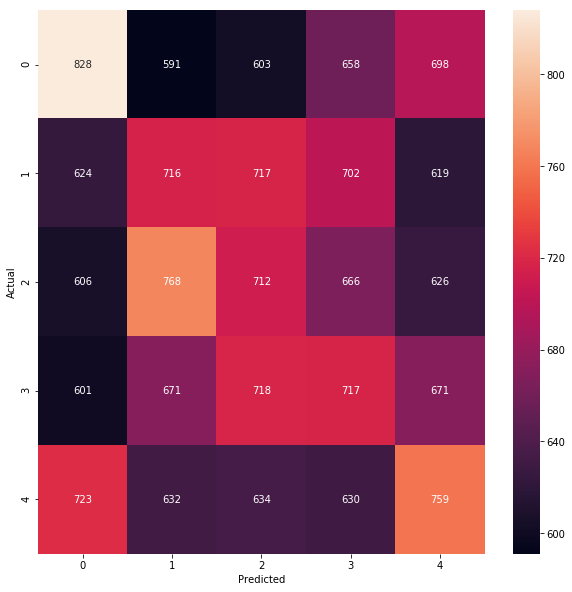

Power_divergenceResult(statistic=array([56.97989355, 28.4920071 , 17.48049645,  7.24458939, 19.4740587 ]), pvalue=array([1.24924412e-11, 9.91277582e-06, 1.55857767e-03, 1.23513672e-01,
       6.34082874e-04]))
[[0.64878626 0.15121374]
 [0.15097691 0.04902309]]
[[ 0.00878626 -0.00878626]
 [-0.00902309  0.00902309]]
Power_divergenceResult(statistic=53.15904381290704, pvalue=1.6956636342291052e-11)
[[0.64239195 0.15760805]
 [0.15760805 0.04239195]]
[[ 0.00239195 -0.00239195]
 [-0.00239195  0.00239195]]
Power_divergenceResult(statistic=3.7747927767910006, pvalue=0.28683179968515765)
[[0.64179988 0.15820012]
 [0.15784488 0.04215512]]
[[ 0.00179988 -0.00179988]
 [-0.00215512  0.00215512]]
Power_divergenceResult(statistic=2.878922439313203, pvalue=0.41067211642668566)
[[0.64274719 0.15725281]
 [0.15754885 0.04245115]]
[[ 0.00274719 -0.00274719]
 [-0.00245115  0.00245115]]
Power_divergenceResult(statistic=4.167036708111308, pvalue=0.24398292667410845)
[[0.64523387 0.15476613]
 [0.15506217 0.04

,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,0.0147258
yearly_vol,0.0710809
yearly_sharpe,0.227831
max_drawdown,-0.428054
sortino,0.103208


In [48]:
backtestmodel = BacktestModel(X, Y, 
                              model=create_keras_model(3,32,0.01), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)

backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')


In [ ]:
.........................................................
